# Braintracer Cell Analysis
Braintracer extends the functionality of cellfinder and brainreg. It takes the downsampled data, registered atlas, and positive cell coordinates, scales them down to downsampled space and assigns them to corresponding atlas brain areas, cleanly displaying the results from multiple datasets.

### Setup

In [1]:
from braintracer.braintracer import analysis as bt
from braintracer.braintracer import file_management as btf
from braintracer.braintracer import plotting as btp
from braintracer.braintracer import area_lists as bta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.colors as clrs
from scipy import signal
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
from tqdm import tqdm
import scipy.stats as stats
import smtplib
import brainglobe_heatmap as bgh
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse

In [2]:
## DEFINE YOUR EXPERIMENT
def retro_expts():
    bt.postsyn_region = 'IO' # You must set a starter region to use some features
    # For quantifications comparing pre and postsynaptic cell populations, you must set the following:
    bt.postsyn_ch = 'r' # The channel(s) containing starter cells (postsynaptics)
    bt.presyn_ch = 'r' # The channel(s) containing input cells (presynaptics)
    bt.presyn_regions_exclude = ['CBX'] # Presynaptic cells are the total cells in presyn_ch - (postsyn_region + presyn_regions_exclude)

    bt.channel_colours = ['r','g','b'] # ordered list of colours channels will take ['r','g','b'] by default
    bt.network_name = 'bt14' # default is Unet
    bt.grouped = True # True by default, set to False if you only have one group
    bt.debug = False # False by default
    
def antero_expts_override():
    bt.postsyn_region = 'CBX'
    bt.presyn_regions_exclude = ['CBN', 'P', 'IO', 'icp']
    
retro_expts()
antero_expts_override()

# normalisation:
# * None - use cell count
# * 'presynaptics' - normalise to the presynaptic cell count
# * 'postsynaptics' - normalise to the postsynaptic cell count
# * 'total' - normalise to the total cell count in the first channel name in Dataset instantiation parameter
# orientation: 'frontal', 'sagittal', 'horizontal' or a tuple (x,y,z)
# poster plotting: plt.style.use('seaborn-poster')

In [3]:
cb = [58920000000, 19150000000, 24760000000, 36480000000, 53200000000, 40880000000, 26600000000, 21890000000]
noise = [29000, 5600, 16000, 12000, 8100, 10000, 45000, 130000]

In [4]:
# make sure to normalise dividing factors around 1 and multiply values by (um^3/px)/10^9 to get normalised labelling (mm^3)
def norm(values, idx):
    divisor = (sum(values) / len(values)) / values[idx]  # relative to 1 (mean)
    return 1 / divisor # inverse because dividing by norm value

In [5]:
# provide the name, group, cell channels, background channel
# LOW CELL COUNTS TO BE EXCLUDED FOR PROBABILITY MAPS: FR195, FR197, FR198, FR209, FR210, SC017, SC028, SC034
## EXCLUDED
bt.network_name = 'Unet'
#bt.Dataset('FR195', 'LS', ['r','g']);
#bt.Dataset('FR211', 'LS', ['r','g']); # CANNOT RUN; has zero cells
#bt.Dataset('SC002', 'LS', ['r','g'], atlas_25=True);
#bt.Dataset('SC004', 'LS', ['r','g']); # CANNOT RUN; never ran cellfinder
bt.network_name = 'bt14' # default is Unet
#bt.Dataset('SC017', 'LS', ['r','g']);
#bt.Dataset('FR198', 'LS', ['r','g'], starters=15);
#bt.Dataset('FR209', 'LS', ['r','g'], starters=59);
#bt.Dataset('FR210', 'LV', ['r','g'], starters=291);
#bt.Dataset('SC028', 'LS', ['r']);
#bt.Dataset('SC029', 'LS', ['r']);
#bt.Dataset('SC034', 'LS', ['r']);
## INCLUDED
bt.network_name = 'Unet' # datasets which haven't been analysed yet with bt14
#bt.Dataset('FR208', 'LV', ['r', 'g']);
#bt.Dataset('SC005', 'LS', ['r', 'g']);
bt.network_name = 'bt14' # default is Unet
bt.Dataset('SC003', 'LS', ['r'], starters=229, atlas_25=True);
bt.Dataset('SC009', 'LS', ['r']);
bt.Dataset('FR200', 'LS', ['r'], starters=1102); # these starters values override the cellfinder count in the starter region for normalisation purposes
bt.Dataset('FR197', 'LV', ['r']);
bt.Dataset('FR199', 'LV', ['r'], starters=477);
bt.Dataset('SC001', 'LV', ['r'], starters=336, atlas_25=True);
bt.Dataset('SC006', 'LV', ['r'], starters=242);
bt.Dataset('SC007', 'LS', ['r']);
bt.Dataset('SC008', 'LS', ['r']);
bt.Dataset('SC010', 'LS', ['r']); # CHANGED from human-defined LV
bt.Dataset('SC011', 'LS', ['r'], starters=202);
bt.Dataset('SC012', 'LV', ['r']);
bt.Dataset('SC016', 'LV', ['r']);
bt.Dataset('SC018', 'LV', ['r'], starters=278);
bt.Dataset('SC027', 'LV', ['r']);
bt.Dataset('SC030', 'LS', ['r']);
bt.Dataset('SC031', 'LV', ['r']);
#bt.Dataset('SC013', 'LS', ['r'], fluorescence=True, skimmed=False, starter_pedestal_norm=0.163, starter_normaliser=norm(cb,0), starters=norm(cb,0), custom_division_norm=norm(noise,0));  # noiseImSize: 2421 noiseImSizeHalf: 1144
#bt.Dataset('SC014', 'LV', ['r'], fluorescence=True, skimmed=False, starter_pedestal_norm=0.376, starter_normaliser=norm(cb,1), starters=norm(cb,1), custom_division_norm=norm(noise,1));  # noiseImSize: 1367 noiseImSizeHalf: 429 
#bt.Dataset('SC015', 'LS', ['r'], fluorescence=True, skimmed=False, starter_pedestal_norm=0.259, starter_normaliser=norm(cb,2), starters=norm(cb,2), custom_division_norm=norm(noise,2));  # noiseImSize: 2199 noiseImSizeHalf: 887 
#bt.Dataset('SC020', 'LS', ['r'], fluorescence=True, skimmed=False, starter_pedestal_norm=0.186, starter_normaliser=norm(cb,3), starters=norm(cb,3), custom_division_norm=norm(noise,3));  # noiseImSize: 1700 noiseImSizeHalf: 571 
#bt.Dataset('SC022', 'LS', ['r'], fluorescence=True, skimmed=False, starter_pedestal_norm=0.103, starter_normaliser=norm(cb,4), starters=norm(cb,4), custom_division_norm=norm(noise,4));  # noiseImSize: 1502 noiseImSizeHalf: 535 
#bt.Dataset('SC023', 'LV', ['r'], fluorescence=True, skimmed=False, starter_pedestal_norm=0.174, starter_normaliser=norm(cb,5), starters=norm(cb,5), custom_division_norm=norm(noise,5));  # noiseImSize: 1506 noiseImSizeHalf: 537 
#bt.Dataset('SC048', 'LV', ['r'], fluorescence=True, skimmed=False, starter_pedestal_norm=0.262, starter_normaliser=norm(cb,6), starters=norm(cb,6), custom_division_norm=norm(noise,6));  # noiseImSize: 3041 noiseImSizeHalf: 1520
#bt.Dataset('SC049', 'LV', ['r'], fluorescence=True, skimmed=False, starter_pedestal_norm=0.229, starter_normaliser=norm(cb,7), starters=norm(cb,7), custom_division_norm=norm(noise,7));  # noiseImSize: 3559 noiseImSizeHalf: 2025
title = '_'.join([i.name for i in bt.datasets])

### Helpers

In [6]:
def send_email_notification():
    content = ("Processing complete.")
    mail = smtplib.SMTP('smtp.gmail.com', 587)
    mail.ehlo()
    mail.starttls()
    mail.login('scloth.dev@gmail.com', 'qmmv tuiw jymk vypp')
    mail.sendmail('scloth.dev@gmail.com', 'sam.clth@gmail.com', content) 
    mail.close()

In [7]:
# plot starter cell counts, perform correction, then show the updated starter cell counts
def correct_retro_starter_cell_count():
    f, axs = plt.subplots(1,3, figsize=(16,5))
    btp.generate_starter_cell_bar(ax=axs[0])
    axs[0].set_ylim(0, 1000)
    region_comparison_scatter(fluorescence=False, config='prePost', labels=True, set_postsyn_values_to_line=True, exclude_dataset_idx_from_line_fit=[])
    btp.generate_starter_cell_scatter(use_manual_count=True, ax=axs[1]) # this function only executes for datasets with fluorescence = False
    btp.generate_starter_cell_bar(ax=axs[2])
    axs[2].set_ylim(0, 1000)

### Region setup

In [6]:
areas_to_combine = {'Pontine reticular nucleus': [146, 1093], 'Spinal nucleus of the trigeminal': [429, 437, 445]}

In [7]:
all_incf_title = 'Retro disynaptic CF input map'
all_inmf_title = 'Antero monosynaptic MF input map'
all_otmo_title = 'Antero monosynaptic output map'
all_otdi_title = 'Antero disynaptic output map'

In [8]:
rg_datasets, rg_num_g1 = btp.fetch_groups(fluorescence=False)
ag_datasets, ag_num_g1 = btp.fetch_groups(fluorescence=True)

In [11]:
rg_di_areas, rg_di_title = bta.di_inputs_retro(0.5, 'total', False)
rg_di_areas.remove(648) # replace M1-L5 with M1
rg_di_areas.append(985)
rg_di_areas.remove(10) # replace SCm-ig and SCm-iw with SCm
rg_di_areas.remove(17)
rg_di_areas.append(294)
rg_di_areas.append(445) # add SPVO for combining with SPVI and SPVC

In [12]:
rg_mi_areas, rg_mi_title = bta.inputs_antero_CF('both') # vbounds=(5000,1800000) # IO value_norm='none'

In [13]:
ag_mi_areas, ag_mi_title = bta.inputs_antero_MF_roi_crop()

In [11]:
ag_cb_areas, ag_cb_title = bta.cerebellar_cortex_antero()

In [15]:
ag_mo_areas, ag_mo_title = bta.mono_outputs_antero()

In [16]:
# (1250, 'custom_pedestal', True), di_outputs_antero(10000, 'custom_pedestal', True)
# 'custom_pedestal' 0.00000005 or 0.0000001
# 'custom_division' 2, 4, 0.25 (number), 0.0001 (1 norm)
ag_do_areas, ag_do_title = bta.di_outputs_antero_roi(0.0001, 'custom_division', True) 

In [22]:
title_m = ag_mo_title + ' + ' + ag_mi_title
title_d = rg_di_title + ' + ' + ag_do_title
title_ii = ag_mi_title + ' + ' + rg_di_title

In [23]:
m_areas = list(set(ag_mi_areas + ag_mo_areas))
d_areas = list(set(rg_di_areas + ag_do_areas))
ii_areas = list(set(ag_mi_areas + rg_di_areas))

In [9]:
all_areas = list(set(rg_di_areas + ag_mi_areas + ag_mo_areas + ag_do_areas))
all_areas_func = bta.custom_rois(all_areas)

### Caches for skipping computations

In [9]:
rg_di_areas, rg_di_title = [549, 549009211, 128, 795, 1100, 222, 230, 1048, 136, 307, 859, 852, 651, 429, 437, 146, 1093, 797, 946, 955, 1098, 1107, 978, 202, 225, 711, 993, 322, 989, 91, 985, 294, 445], 'Disynaptic Inputs'
rg_mi_areas, rg_mi_title = ['Rostral-medial IO', 'Rostral-lateral IO', 'Caudal-medial IO', 'Caudal-lateral IO'], 'CF Inputs (anterograde)'
ag_mi_areas, ag_mi_title = [574, 1093, 931, 938, 7, 867, 621, 679, 235, 701, 372, 852, 101, 395, 437, 445, 1048, 169, 136, 307, 96, 4, 128, 795], 'MF Inputs (anterograde)'
ag_cb_areas, ag_cb_title = [1017, 1033, 1049, 1041, 1025, 1007, 920, 928, 936, 944, 912, 968, 951, 957], 'Cbx (anterograde)'
ag_mo_areas, ag_mo_title = [846, 989, 91, 589508455], 'Monosynaptic Outputs'
ag_do_areas, ag_do_title = [239, 571, 1008, 907, 218, 1020, 362, 629, 685, 733, 834, 294, 214, 795], 'Disynaptic Outputs (ROIs)'

### Setup continued

In [12]:
## Figure 2 data
fig2_areas = [528, 519, 83, 771, 795, 701, 235] # ['CBX', 'CBN', 'IO', 'P', 'PAG', 'VNC', 'LRN']
fig2_scat_areas = [528, 519, 83, 771, 795, 701, 235]
fig2_dmap_subregions = [[1007,928], [846,989,91,589508455], None, [931,146], None, None, None]
fig2_scat_binsizes = [0.0004, 0.002, 0.015, 0.002, 0.002, 0.002, 0.004]
fig2_scat_ulim = [10, 5, 5, 5, 5, 5, 5]
fig2_dmap_axes = [2, 2, 2, 2, 2, 2, 2]
fig2_dmap_padding = [25, 10, 10, 10, 10, 10, 10]
fig2_dmap_sigma = [1, 1, 1, 1, 1, 1, 1, 1, 1]
fig2_dmap_sat = [1.5, 3, 3, 3, 3, 3, 3]
fig2_dmap_lower_lim = [0, 0, 0, 0, 0, 0, 0]

In [13]:
## Figure 5 data
fig5_areas = [83, 997, 795, 500, 549, 771, 519, 294] # ['IO', 'Brain', 'PAG', 'MO', 'TH', 'P', 'CBN', 'SCm'] # Cerebellum is done in 'bt_retroBlue.ipynb'
fig5_scat_areas = [83, 997, 795, 500, 549, 771, 519, 294]
fig5_dmap_subregions = [ None, [528, 83, 795, 294, 500, 549, 771, 519], None, None, [406, 1029, 685], [146], None, None]
fig5_scat_binsizes = [0.001, 0.0004, 0.003, 0.001, 0.003, 0.0006, 0.002, 0.001]
fig5_scat_ulim = [5, 5, 5, 5, 5, 5, 5, 5]
fig5_dmap_axes = [2, 0, 2, 0, 2, 2, 2, 2]
fig5_dmap_padding = [10, 0, 10, 10, 10, 10, 10, 10]
fig5_dmap_sigma = [0.5, 1, 1, 1, 1, 1, 1, 1]
fig5_dmap_sat = [2.5, 10, 4, 3, 2, 3, 5, 3]
fig5_dmap_lower_lim = [0, 0, 0, 0, 0, 0, 0, 0]

In [14]:
## Figure 6 data
fig6_areas = [549, 549, 549, 294] # ['TH', 'VAL', 'VPM', 'SCm']
fig6_scat_areas = [549, 629, 733, 294]
fig6_dmap_subregions = [[629, 733], [629], [733], None]
fig6_scat_binsizes = [0.0005, 0.0008, 0.0006, 0.001]
fig6_scat_ulim = [5, 5, 5, 5]
fig6_dmap_axes = [2, 2, 2, 2]
fig6_dmap_padding = [10, 10, 10, 10]
fig6_dmap_sigma = [1, 1, 1, 1]
fig6_dmap_sat = [1, 2, 2, 1]
fig6_dmap_lower_lim = [0.001, 0, 0, 0]

### Begin plotting

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


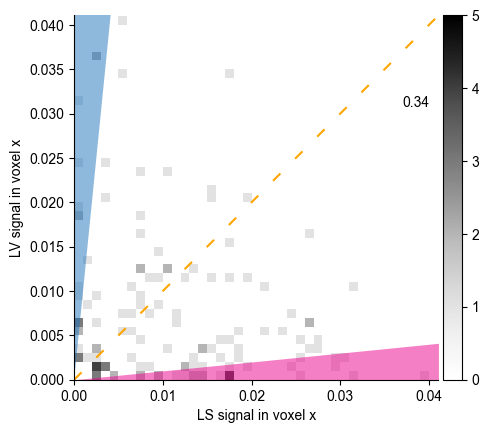

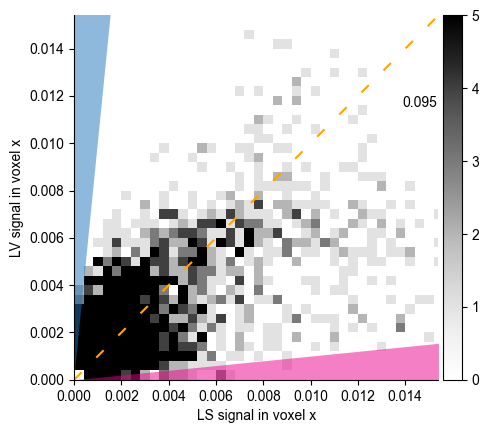

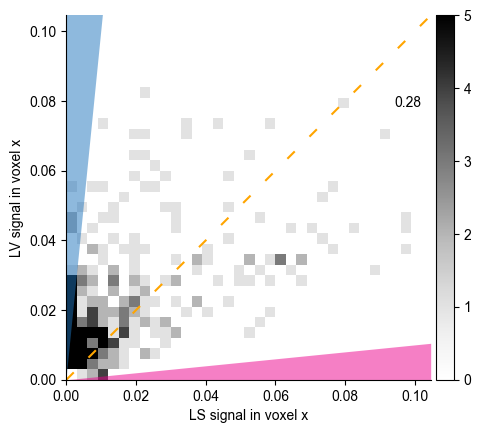

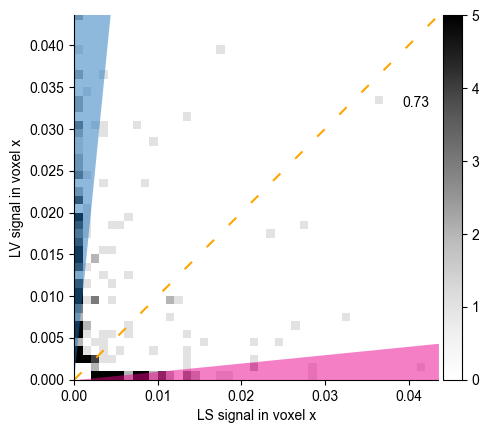

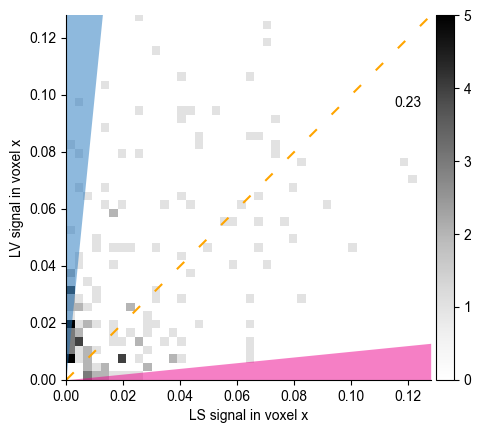

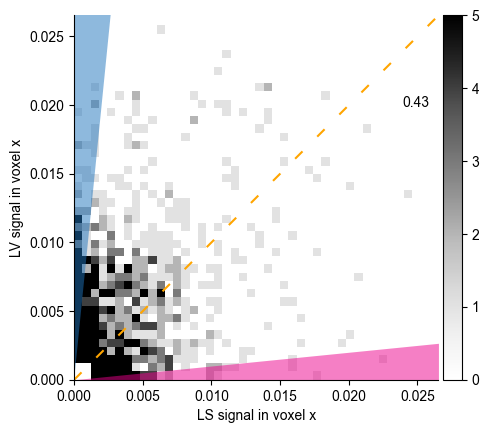

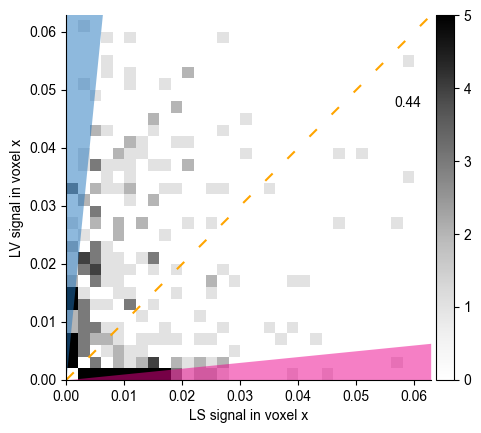

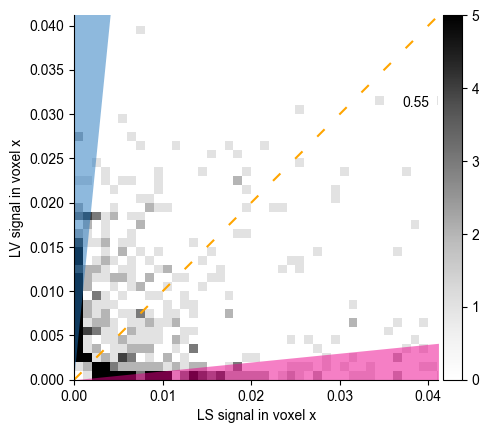

In [ ]:
try:
    for area, binsize, ulim, axis, pad, sig in zip(  fig4_areas,
                                                     fig4_scat_binsizes,
                                                     fig4_scat_ulim,
                                                     fig4_dmap_axes,
                                                     fig4_dmap_padding,
                                                     fig4_dmap_sigma):
        btp.pmap_corr_scatter_binned(('r', False, area, 50, axis, sig), 
                                 lower_lim=0.05, binsize=binsize, gradient=0.1, kde=False, vbounds=(0, ulim))
finally:
    send_email_notification()

Watch out! Remove padding for areas that touch the edge of the atlas.
(0.0, 975.0) (0.0, 628.0)
Watch out! Remove padding for areas that touch the edge of the atlas.
Upper limit: 0.006894113774583923


meta NOT subset; don't know how to subset; dropped


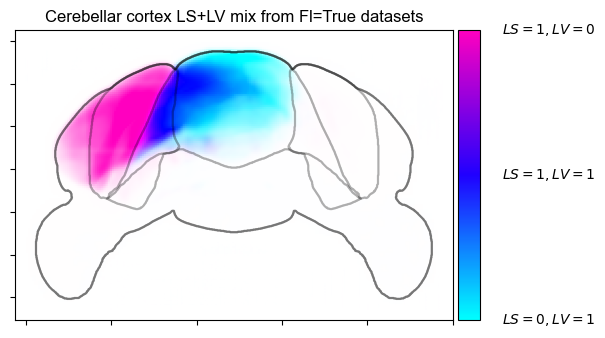

In [ ]:
try:
    for area, subregions, axis, pad, sig, sat, lower_lim in zip(fig2_areas,
                                                                fig2_dmap_subregions,
                                                                fig2_dmap_axes,
                                                                fig2_dmap_padding,
                                                                fig2_dmap_sigma,
                                                                fig2_dmap_sat,
                                                                fig2_dmap_lower_lim):
        if area == 528:
            btp.probability_map_overlap('r', True, area_num=area, subregions=subregions, binsize=50, axis=axis, sigma=sig, projcol='k', padding=pad, lower_lim=lower_lim, saturation_multiplier=sat)
finally:
    send_email_notification()

In [9]:
btp.region_signal_matrix((rg_di_areas, rg_di_title), value_norm='presynaptics', figsize=(7,6), vmax=10, fluorescence=False, log_plot=False, areas_to_combine=areas_to_combine);
btp.region_signal_matrix((rg_mi_areas, rg_mi_title), value_norm=None, figsize=(7,6), vmax=0.0025, fluorescence=True, log_plot=False);
btp.region_signal_matrix((ag_mi_areas, ag_mi_title), value_norm='custom_pedestal', figsize=(7,6), vmax=0.008, fluorescence=True, log_plot=False);
btp.region_signal_matrix((ag_mo_areas, ag_mo_title), value_norm='custom_pedestal', figsize=(7,6), vmax=None, fluorescence=True, log_plot=False); # 750
btp.region_signal_matrix((ag_do_areas, ag_do_title), value_norm='custom_division', figsize=(7,6), vmax=0.002, fluorescence=True, log_plot=False); # 3, old: 40

NameError: name 'areas_to_combine' is not defined

['Pontine reticular nucleus', 'Pontine reticular nucleus, caudal part']
['Spinal nucleus of the trigeminal, caudal part', 'Spinal nucleus of the trigeminal, interpolar part', 'Spinal nucleus of the trigeminal, oral part']


meta NOT subset; don't know how to subset; dropped


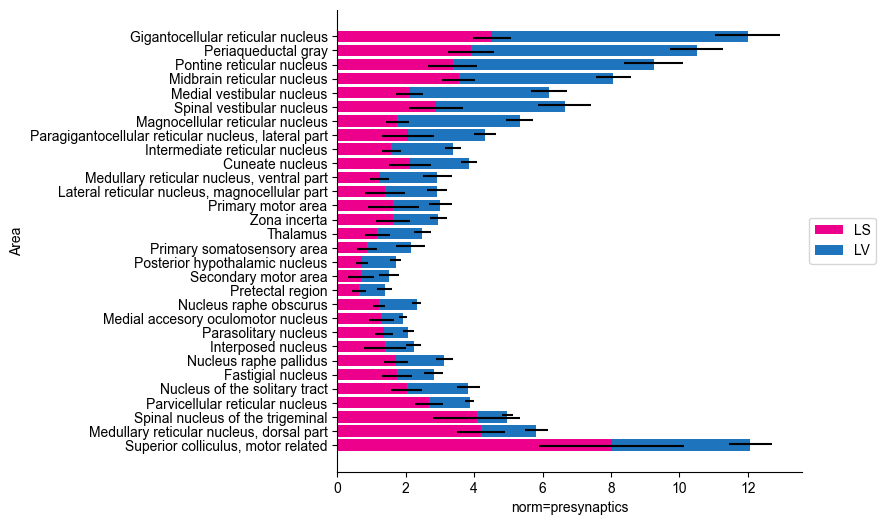

In [37]:
btp.area_total_signal_bar((rg_di_areas, rg_di_title), value_norm='presynaptics', fluorescence=False, areas_to_combine=areas_to_combine)
btp.area_total_signal_bar((rg_mi_areas, rg_mi_title), value_norm=None, fluorescence=True)
btp.area_total_signal_bar((ag_mi_areas, ag_mi_title), value_norm='custom_pedestal', fluorescence=True)
btp.area_total_signal_bar((ag_mo_areas, ag_mo_title), value_norm='custom_pedestal', fluorescence=True)
btp.area_total_signal_bar((ag_do_areas, ag_do_title), value_norm='custom_division', fluorescence=True)

In [116]:
btp.area_selectivity_with_errors((rg_di_areas, rg_di_title), value_norm='presynaptics', fluorescence=False, areas_to_combine=areas_to_combine)
#btp.area_selectivity_with_errors((rg_mi_areas, rg_mi_title), value_norm=None, fluorescence=True)
#btp.area_selectivity_with_errors((ag_mi_areas, ag_mi_title), value_norm='custom_pedestal', fluorescence=True)
#btp.area_selectivity_with_errors((ag_mo_areas, ag_mo_title), value_norm='custom_pedestal', fluorescence=True)
#btp.area_selectivity_with_errors((ag_do_areas, ag_do_title), value_norm='custom_division', fluorescence=True)

NameError: name 'area_selectivity_with_errors' is not defined

Watch out! Remove padding for areas that touch the edge of the atlas.
Watch out! Remove padding for areas that touch the edge of the atlas.
Watch out! Remove padding for areas that touch the edge of the atlas.
Watch out! Remove padding for areas that touch the edge of the atlas.
Watch out! Remove padding for areas that touch the edge of the atlas.
Watch out! Remove padding for areas that touch the edge of the atlas.
['Pontine reticular nucleus', 'Pontine reticular nucleus, caudal part']
['Spinal nucleus of the trigeminal, caudal part', 'Spinal nucleus of the trigeminal, interpolar part', 'Spinal nucleus of the trigeminal, oral part']
Watch out! Remove padding for areas that touch the edge of the atlas.


meta NOT subset; don't know how to subset; dropped


Normalisation was not performed.
Normalisation was not performed.
Normalisation was not performed.
Normalisation was not performed.
Normalisation was not performed.
Normalisation was not performed.
Normalisation was not performed.


meta NOT subset; don't know how to subset; dropped


Normalisation was not performed.
Watch out! Remove padding for areas that touch the edge of the atlas.
Watch out! Remove padding for areas that touch the edge of the atlas.


meta NOT subset; don't know how to subset; dropped


meta NOT subset; don't know how to subset; dropped


meta NOT subset; don't know how to subset; dropped


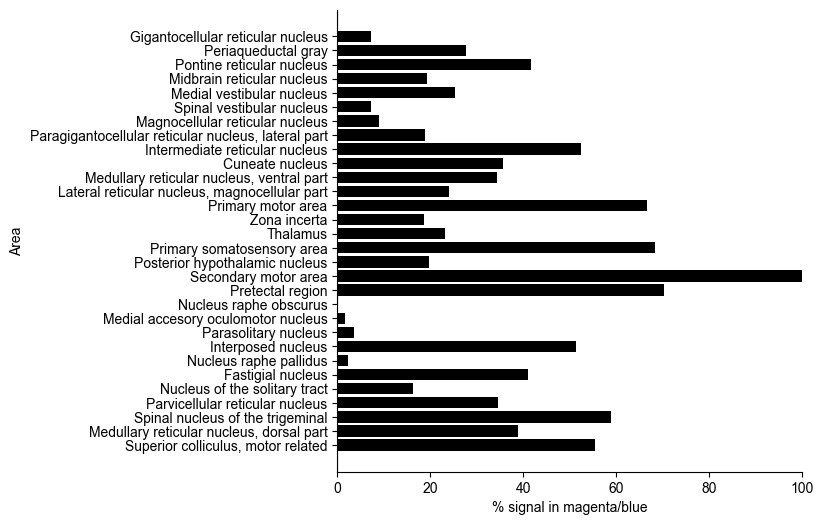

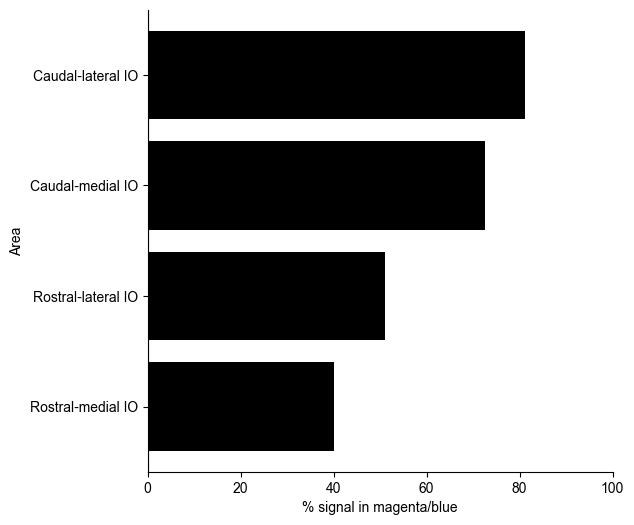

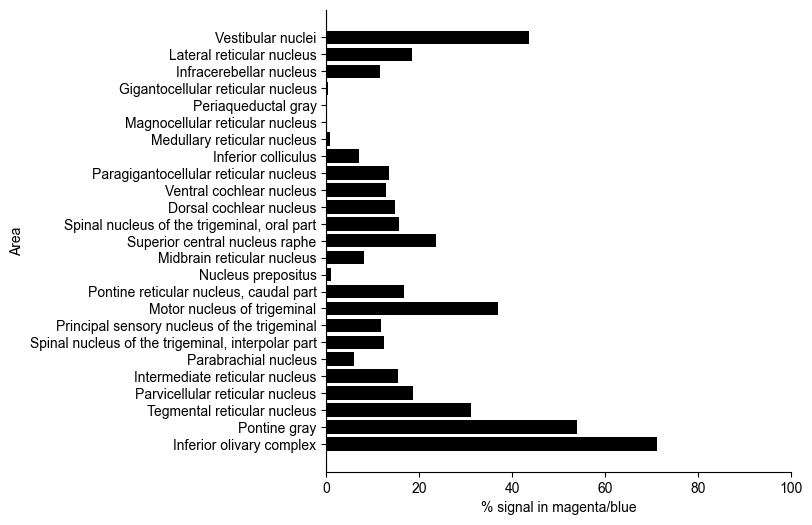

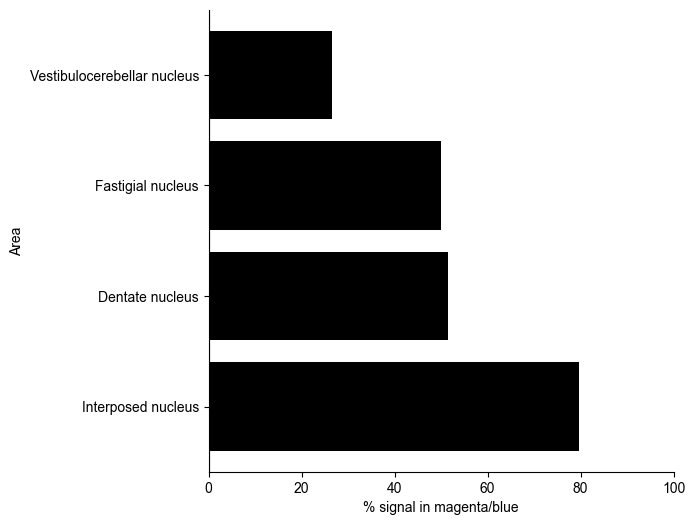

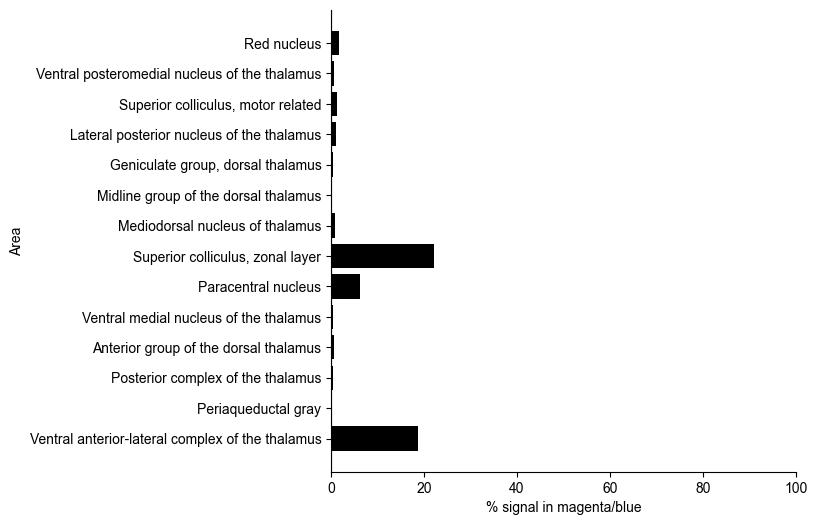

In [21]:
btp.density_map_corr_bar('r', False, (rg_di_areas, rg_di_title), value_norm='presynaptics', areas_to_combine=areas_to_combine)
btp.density_map_corr_bar('r', True,  (rg_mi_areas, rg_mi_title), value_norm=None)
btp.density_map_corr_bar('r', True,  (ag_mi_areas, ag_mi_title), value_norm='custom_pedestal')
btp.density_map_corr_bar('r', True,  (ag_mo_areas, ag_mo_title), value_norm='custom_pedestal')
btp.density_map_corr_bar('r', True,  (ag_do_areas, ag_do_title), value_norm='custom_division')

meta NOT subset; don't know how to subset; dropped


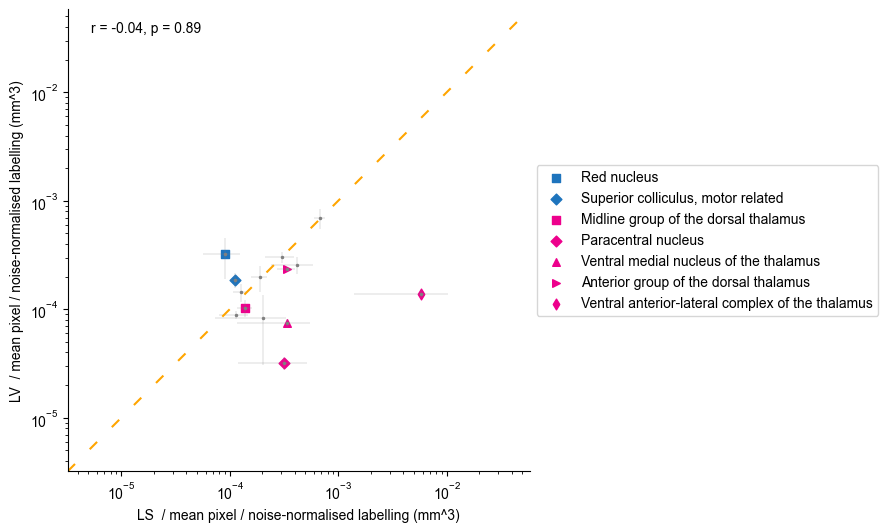

In [12]:
#btp.area_selectivity_scatter((rg_di_areas, rg_di_title), value_norm='presynaptics',    custom_lim=None, fluorescence=False, log=False, areas_to_combine=areas_to_combine)
#btp.area_selectivity_scatter((rg_mi_areas, rg_mi_title), value_norm=None,              custom_lim=None, fluorescence=True,  log=False)
#btp.area_selectivity_scatter((ag_mi_areas, ag_mi_title), value_norm='custom_pedestal', custom_lim=None, fluorescence=True,  log=False)
#btp.area_selectivity_scatter((ag_mo_areas, ag_mo_title), value_norm='custom_pedestal', custom_lim=None, fluorescence=True,  log=False)
btp.area_selectivity_scatter((ag_do_areas, ag_do_title), value_norm='custom_division', custom_lim=None, fluorescence=True,  log=True)

In [ ]:
#btp.region_signal_matrix((ag_cb_areas, ag_cb_title), value_norm=None, figsize=(7,6), vmax=None, fluorescence=True, log_plot=False);
#btp.area_total_signal_bar((ag_cb_areas, ag_cb_title), value_norm=None, fluorescence=True)
#btp.area_selectivity_with_errors((ag_cb_areas, ag_cb_title), value_norm=None, fluorescence=True)
#btp.density_map_corr_bar('r', True, (ag_cb_areas, ag_cb_title), value_norm=None)
btp.area_selectivity_scatter((ag_cb_areas, ag_cb_title), value_norm=None, custom_lim=None, fluorescence=True, log=False)

In [25]:
def generate_fig7_heatmaps(channel, fluorescence, areas, title, norm, orientation='sagittal', pair_plot_vmax=None, spatialseg_vmax=None, position=None, legend=True, areas_to_combine=None):
    datasets, num_g1 = btp.fetch_groups(fluorescence=fluorescence)
    dataset_cells, cbar_label = bt._cells_in_areas_in_datasets(areas, datasets, 'r', normalisation=norm)
    
    area_labels = bt.get_area_info(areas)[0]
    if areas_to_combine is not None:
        _, dataset_cells, _ = btp.replace_areas_with_combined_area(areas_to_combine, area_labels, np.array(dataset_cells), do_not_merge=True)
    
    cells_g1 = np.array(dataset_cells)[0:num_g1,:]
    cells_g2 = np.array(dataset_cells)[num_g1:,:]
    
    area_labels = bt.get_area_acronyms(areas)
    
    #if vmax is None:
        #vmax = np.max(np.concatenate([[mean_g1, mean_g2]], axis=1)) # get max value in the two arrays to set the same vmax for both plots
    def make_paired_plots(areas, cells_g1, cells_g2, title):
        mean_global = np.mean(np.array(dataset_cells), axis=0)
        mean_g1, mean_g2 = np.mean(cells_g1, axis=0), np.mean(cells_g2, axis=0)
        mean_global /= np.sum(mean_global)
        mean_g1 /= np.sum(mean_g1)
        mean_g2 /= np.sum(mean_g2)
        global_regions = dict(zip(areas, mean_global))
        g1_regions = dict(zip(areas, mean_g1))
        g2_regions = dict(zip(areas, mean_g2))
        f1 = bgh.heatmap(global_regions, position=position, orientation=orientation, title=f'{title}: Global', thickness=1000, atlas_name='allen_mouse_10um', format='2D', vmin=0, vmax=None, cmap=btp.cmap_LV_LS_mix).show(show_legend=legend, cbar_label=cbar_label)
        plt.figure(f1)
        btf.save(f'heatmap_means_{title}_ch={channel}_o={orientation}_group=global', as_type='pdf')
        f2 = bgh.heatmap(g1_regions, position=position, orientation=orientation, title=f'{title}: {btp.__get_bt_groups()[0]}', thickness=1000, atlas_name='allen_mouse_10um', format='2D', vmin=0, vmax=pair_plot_vmax, cmap=btp.cmap_LS).show(show_legend=legend, cbar_label=cbar_label)
        plt.figure(f2)
        btf.save(f'heatmap_means_{title}_ch={channel}_o={orientation}_group={btp.__get_bt_groups()[0]}', as_type='pdf')
        f3 = bgh.heatmap(g2_regions, position=position, orientation=orientation, title=f'{title}: {btp.__get_bt_groups()[1]}', thickness=1000, atlas_name='allen_mouse_10um', format='2D', vmin=0, vmax=pair_plot_vmax, cmap=btp.cmap_LV).show(show_legend=legend, cbar_label=cbar_label)
        plt.figure(f3)
        btf.save(f'heatmap_means_{title}_ch={channel}_o={orientation}_group={btp.__get_bt_groups()[1]}', as_type='pdf')
        
    def make_SI_plot(areas, cells_g1, cells_g2, title):
        avgs, _ = btp.calculate_SI_from_means(cells_g2, cells_g1)
        bounds = np.abs(avgs).max()
        regions = dict(zip(areas, avgs))
        cbar_SI_label = f'LS - LV ({cbar_label})'
        f = bgh.heatmap(regions, position=position, orientation=orientation, title=f'{title}: SI', thickness=1000, atlas_name='allen_mouse_10um', format='2D', vmin=-bounds, vmax=bounds, cmap=btp.cmap_LV_to_LS).show(show_legend=legend, cbar_label=cbar_SI_label)
        plt.figure(f)
        btf.save(f'heatmap_SI_{title}_ch={channel}_o={orientation}', as_type='pdf')

    make_paired_plots(area_labels, cells_g1, cells_g2, title)
    make_SI_plot(area_labels, cells_g1, cells_g2, title)
    btp.heatmap_spatial_segregation('r', fluorescence, area_labels, orientation, gradient=0.1, vmax=spatialseg_vmax, position=position, cmap='Greys', legend=False, areas_to_combine=areas_to_combine)

['Pontine reticular nucleus', 'Pontine reticular nucleus, caudal part']
['Spinal nucleus of the trigeminal, caudal part', 'Spinal nucleus of the trigeminal, interpolar part', 'Spinal nucleus of the trigeminal, oral part']


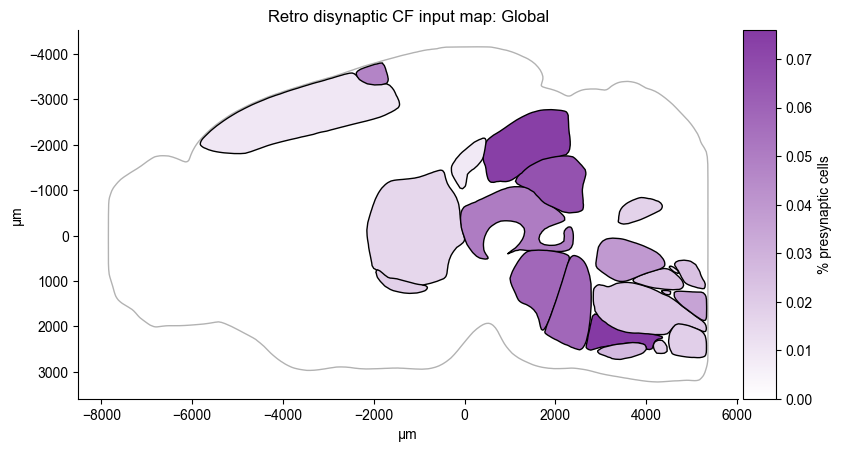

meta NOT subset; don't know how to subset; dropped


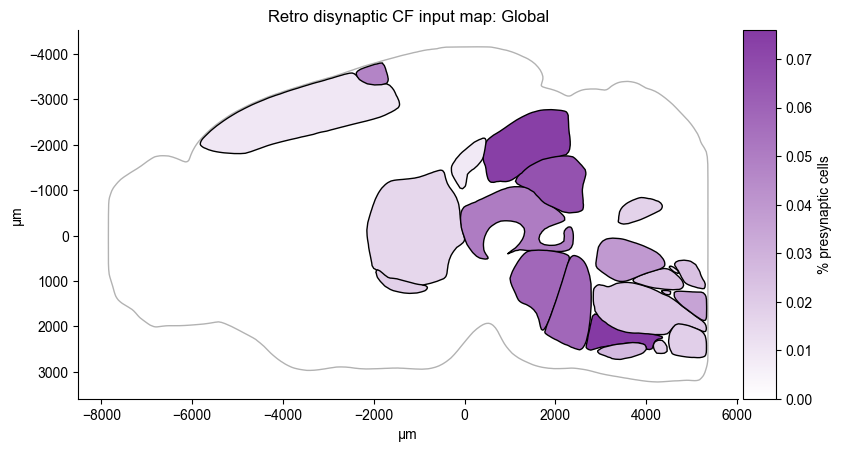

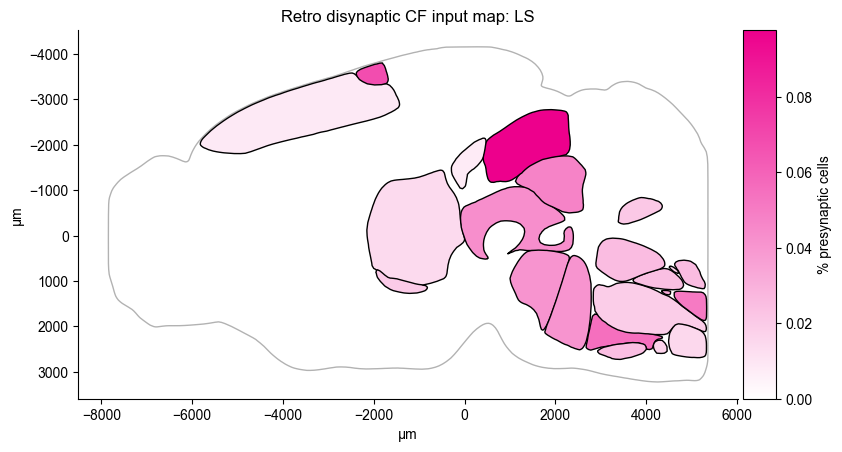

meta NOT subset; don't know how to subset; dropped


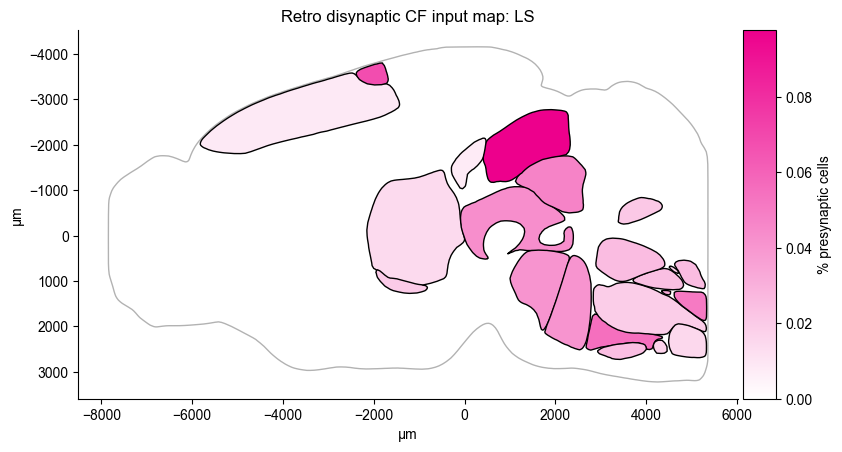

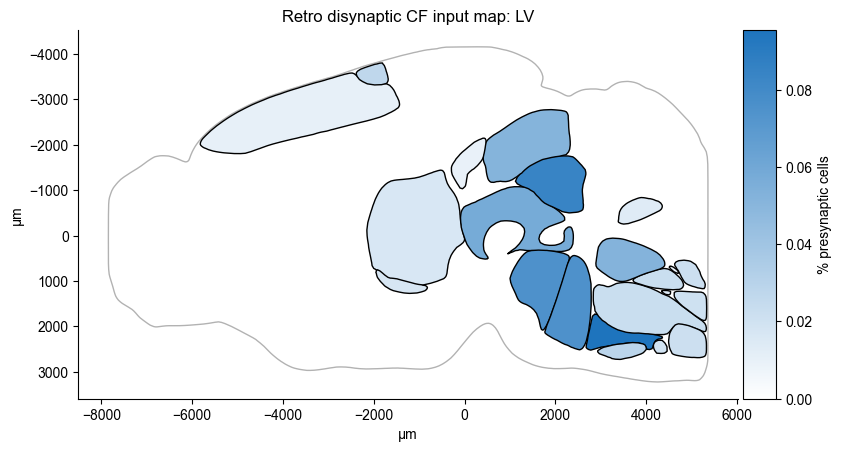

meta NOT subset; don't know how to subset; dropped


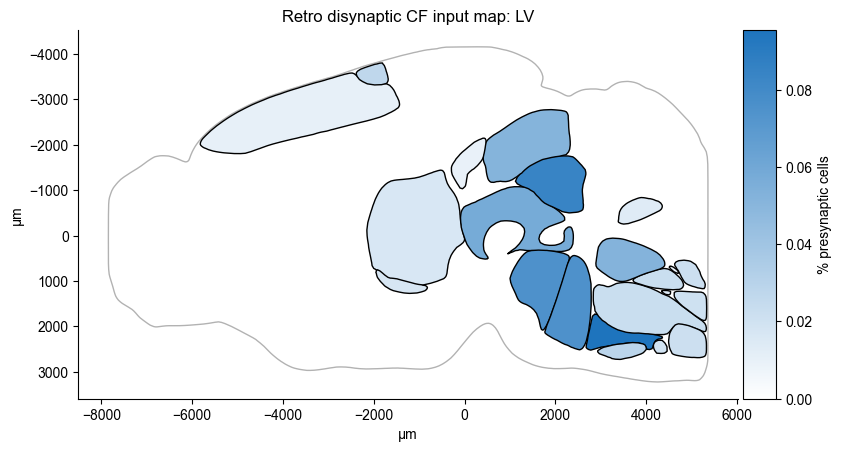

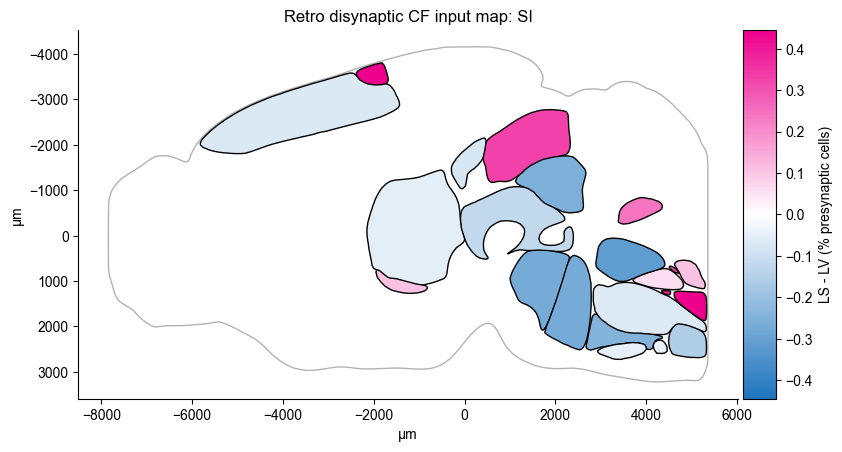

meta NOT subset; don't know how to subset; dropped


Watch out! Remove padding for areas that touch the edge of the atlas.
Watch out! Remove padding for areas that touch the edge of the atlas.
Watch out! Remove padding for areas that touch the edge of the atlas.
Watch out! Remove padding for areas that touch the edge of the atlas.
Watch out! Remove padding for areas that touch the edge of the atlas.
Watch out! Remove padding for areas that touch the edge of the atlas.
['Pontine reticular nucleus', 'Pontine reticular nucleus, caudal part']
['Spinal nucleus of the trigeminal, caudal part', 'Spinal nucleus of the trigeminal, interpolar part', 'Spinal nucleus of the trigeminal, oral part']
Watch out! Remove padding for areas that touch the edge of the atlas.


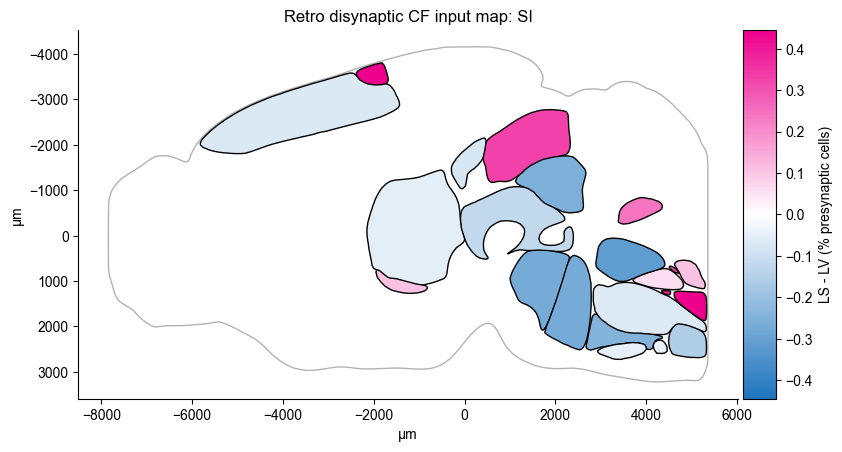

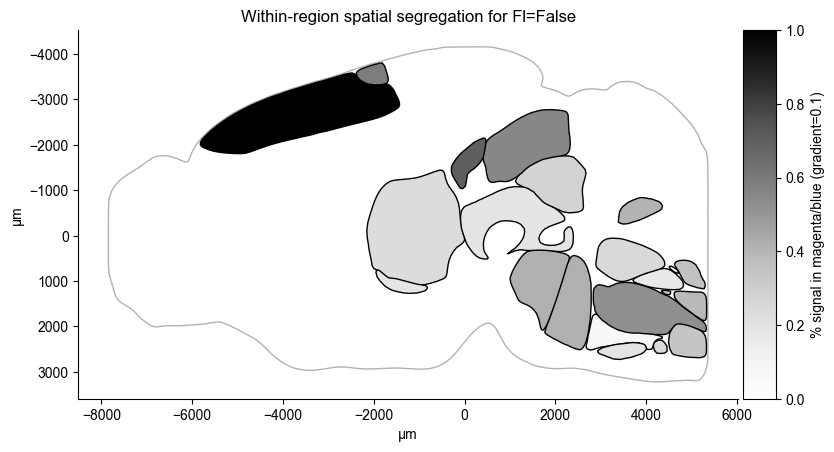

meta NOT subset; don't know how to subset; dropped


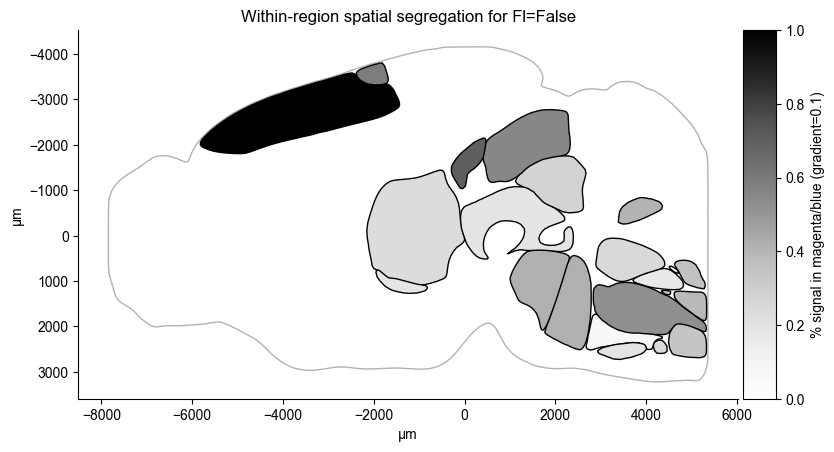

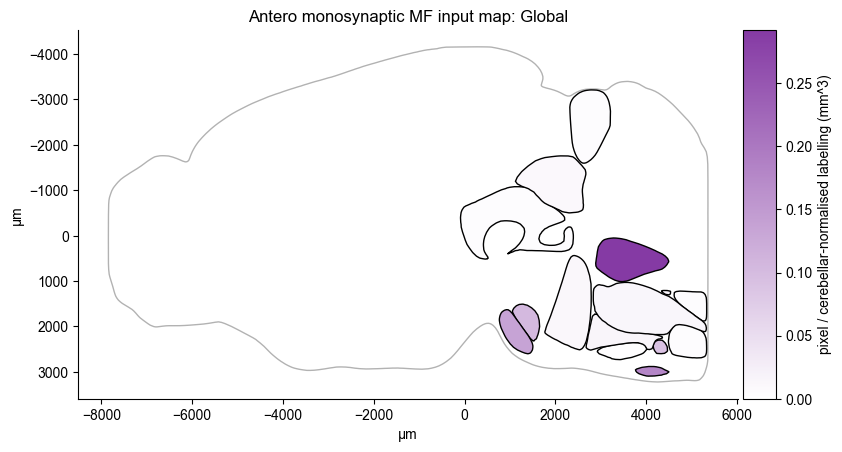

meta NOT subset; don't know how to subset; dropped


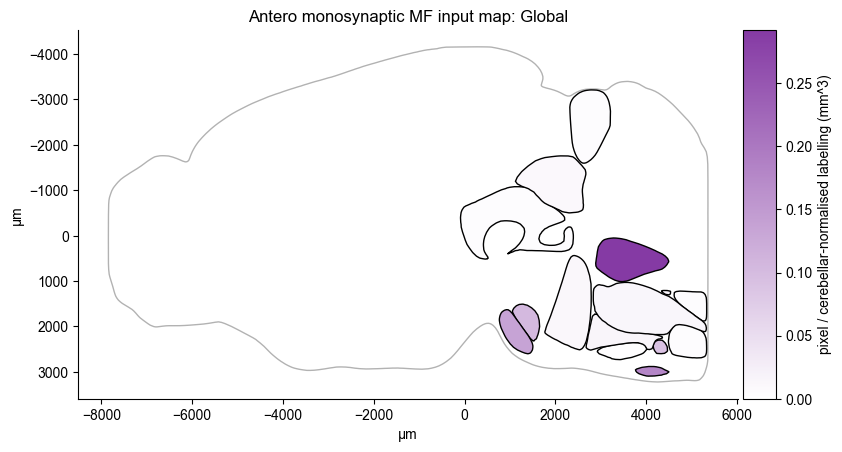

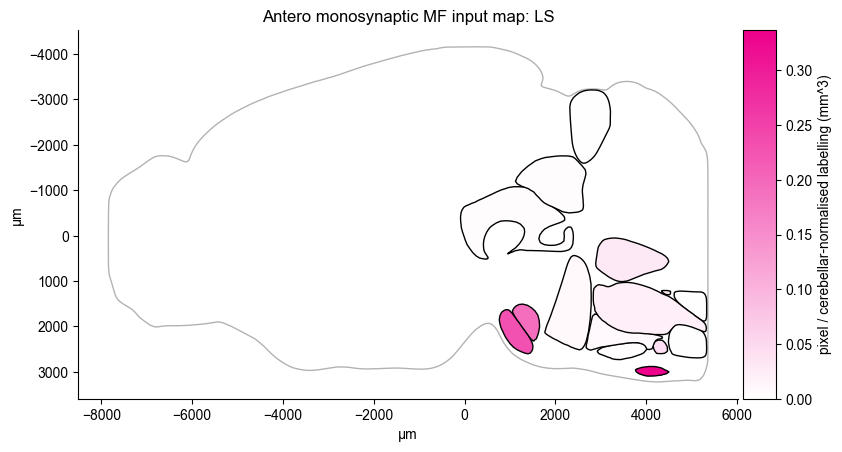

meta NOT subset; don't know how to subset; dropped


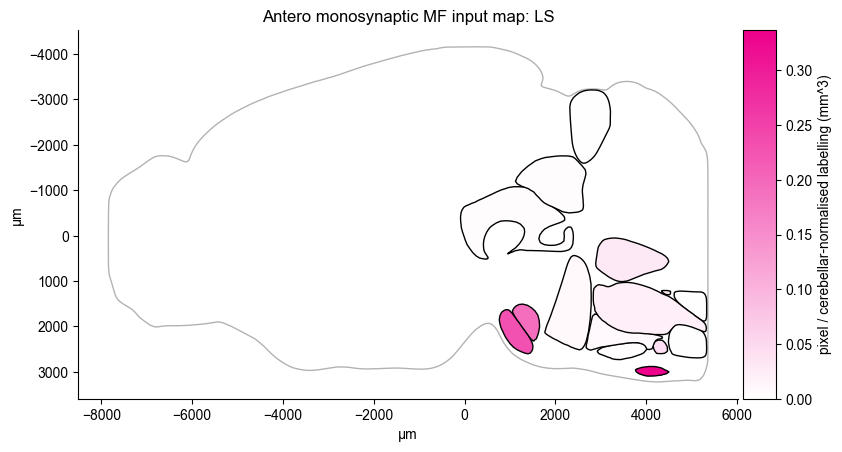

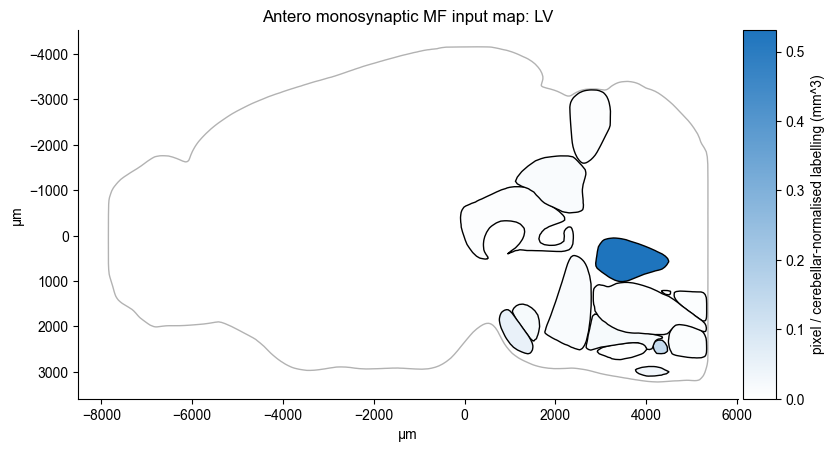

meta NOT subset; don't know how to subset; dropped


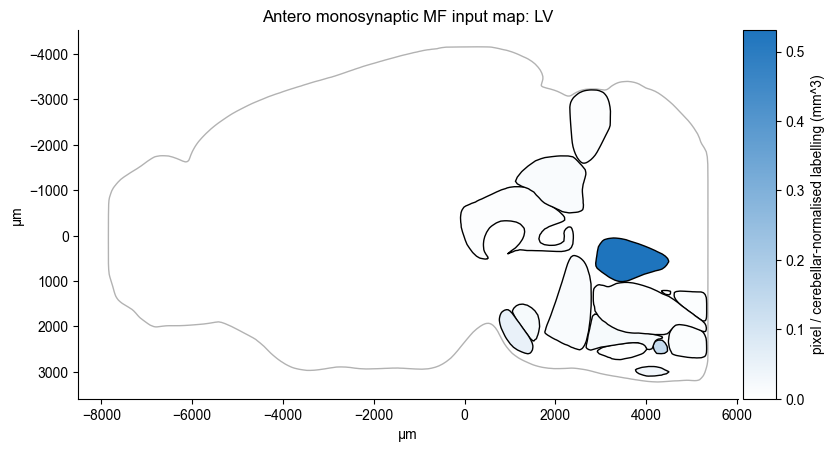

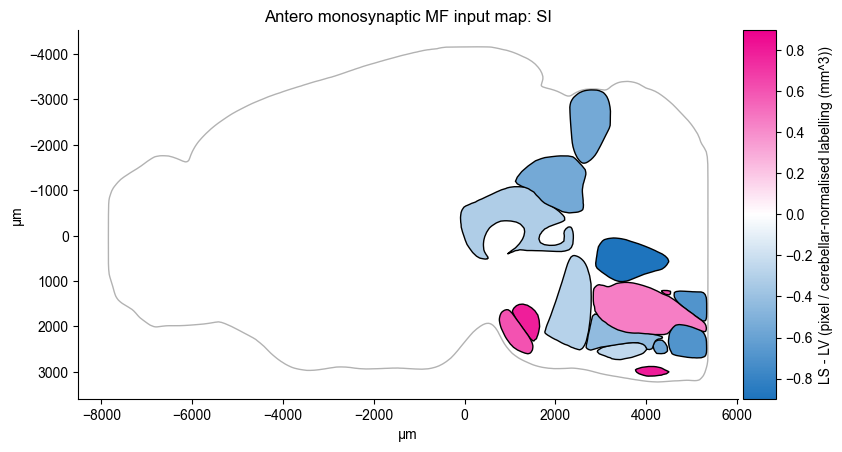

meta NOT subset; don't know how to subset; dropped


Watch out! Remove padding for areas that touch the edge of the atlas.
Watch out! Remove padding for areas that touch the edge of the atlas.


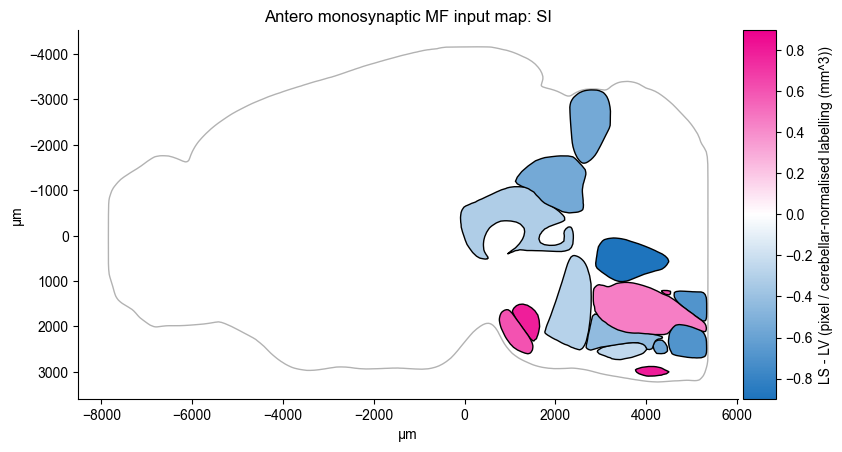

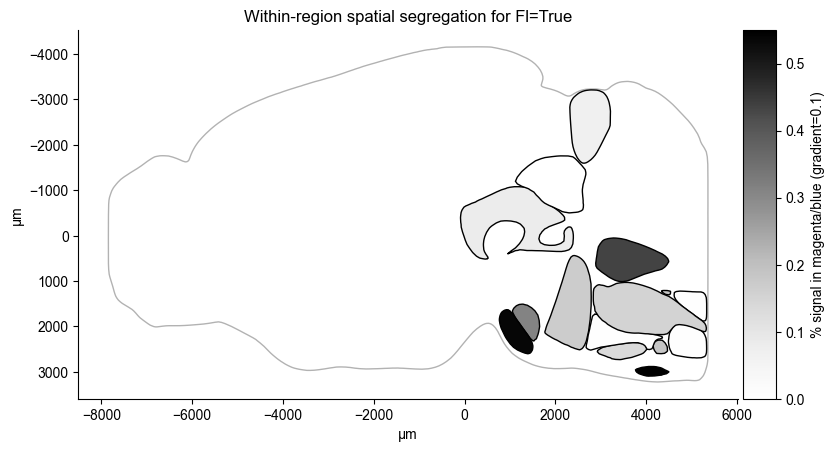

meta NOT subset; don't know how to subset; dropped


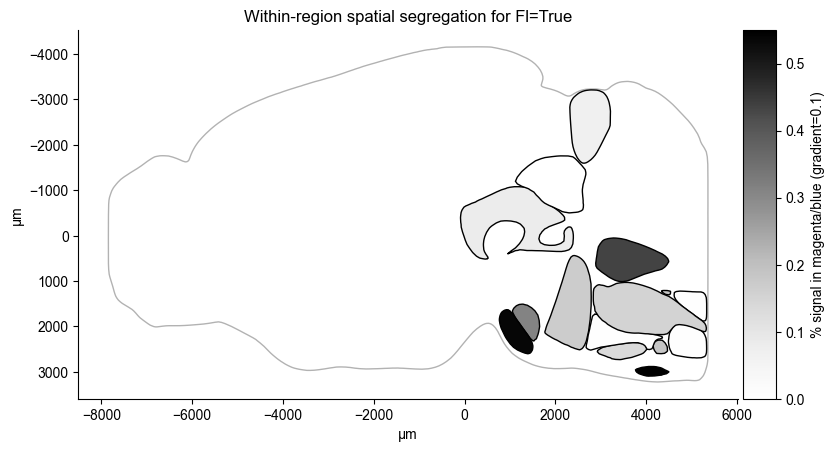

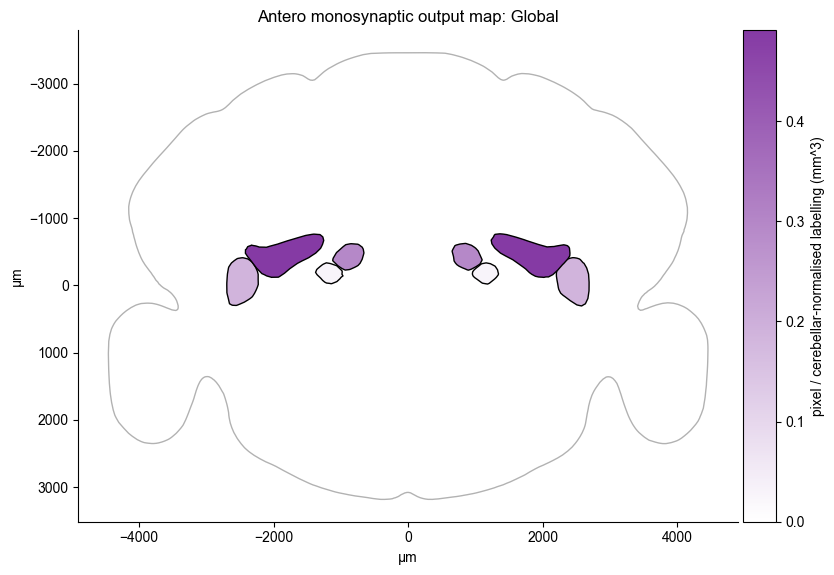

meta NOT subset; don't know how to subset; dropped


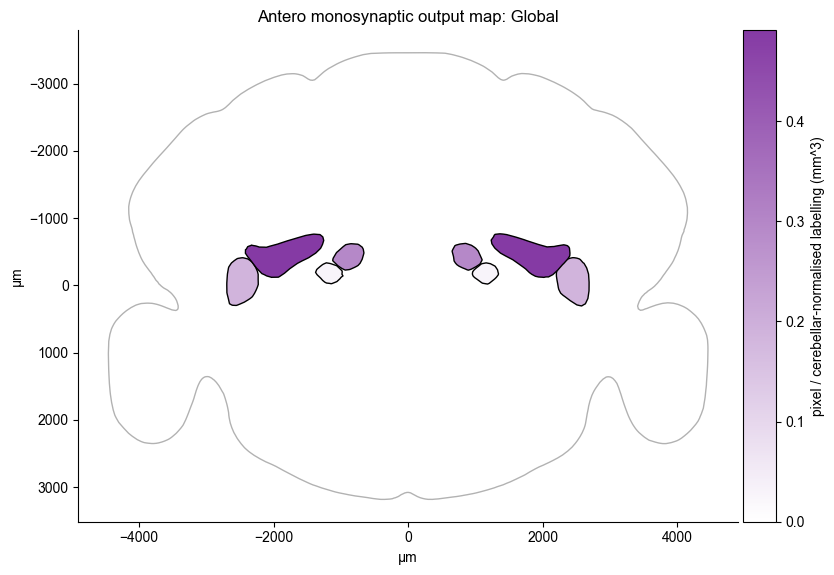

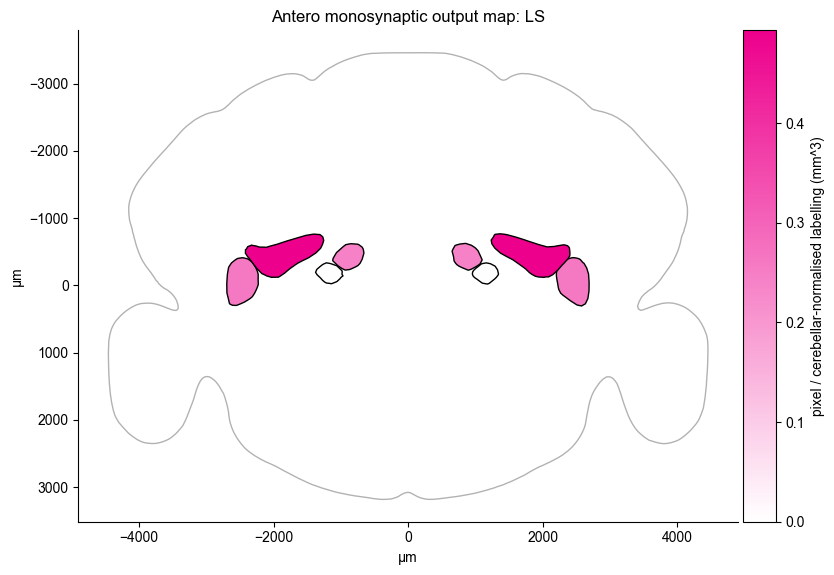

meta NOT subset; don't know how to subset; dropped


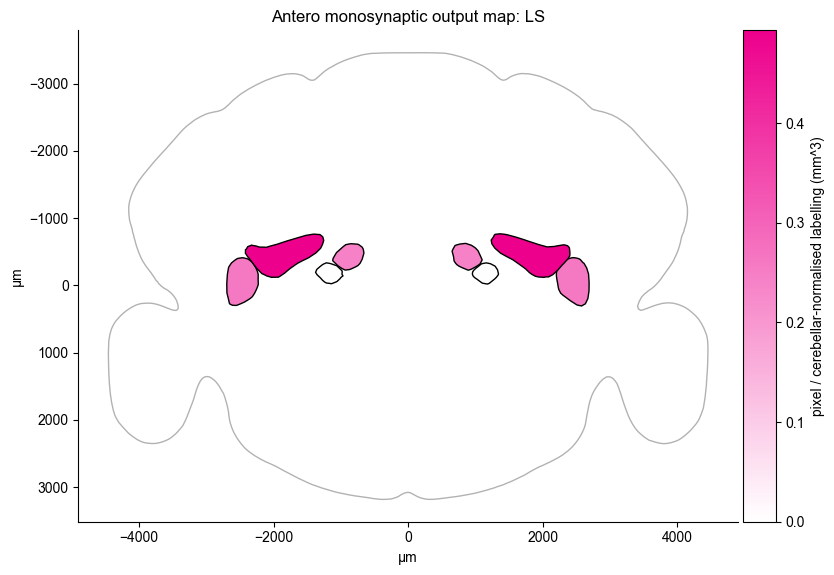

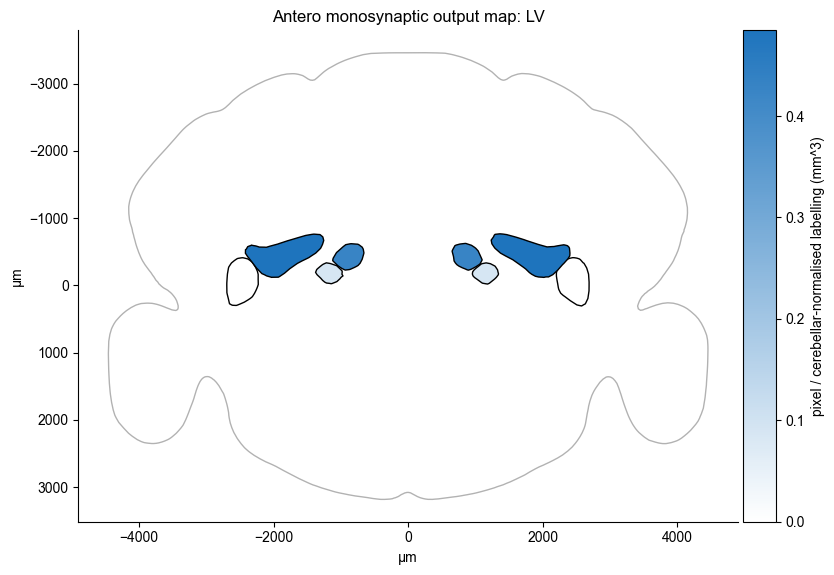

meta NOT subset; don't know how to subset; dropped


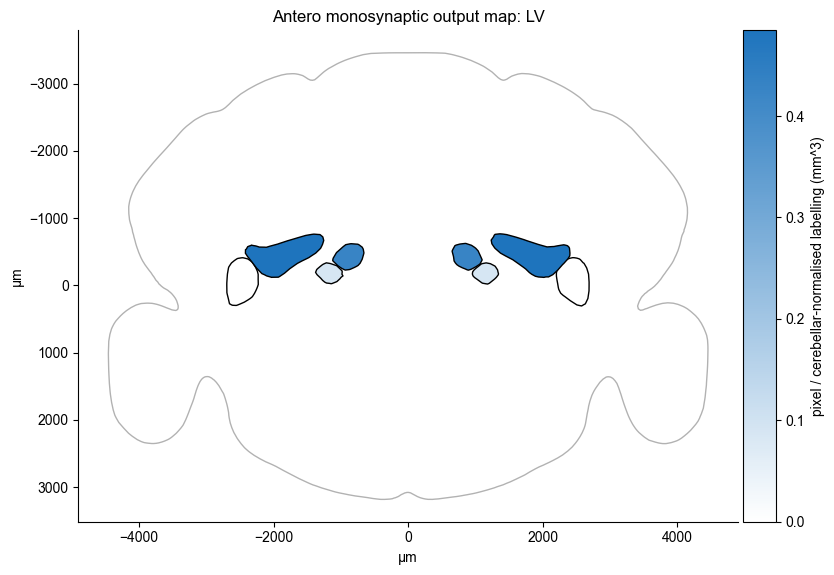

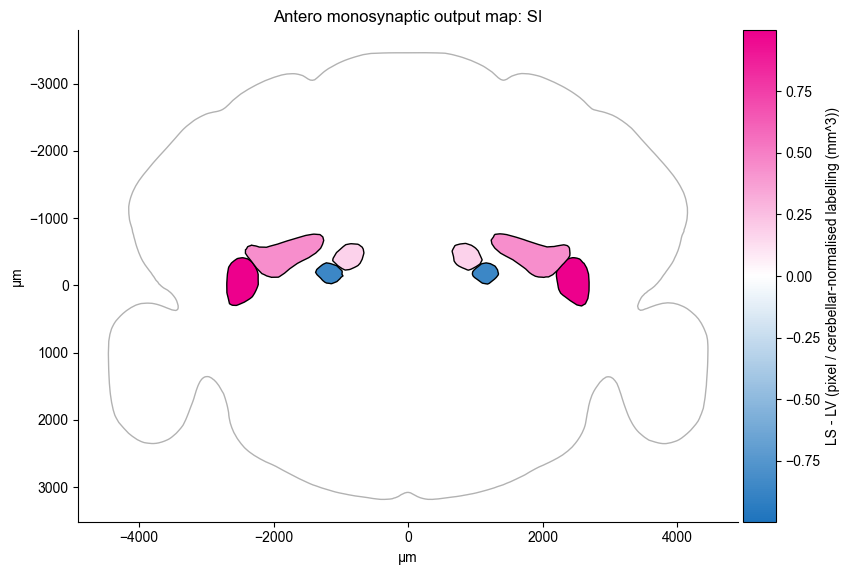

meta NOT subset; don't know how to subset; dropped


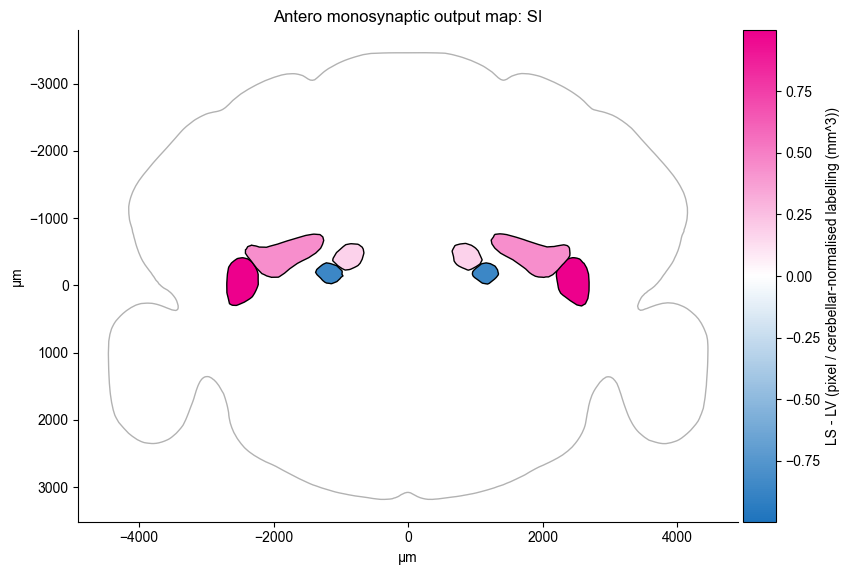

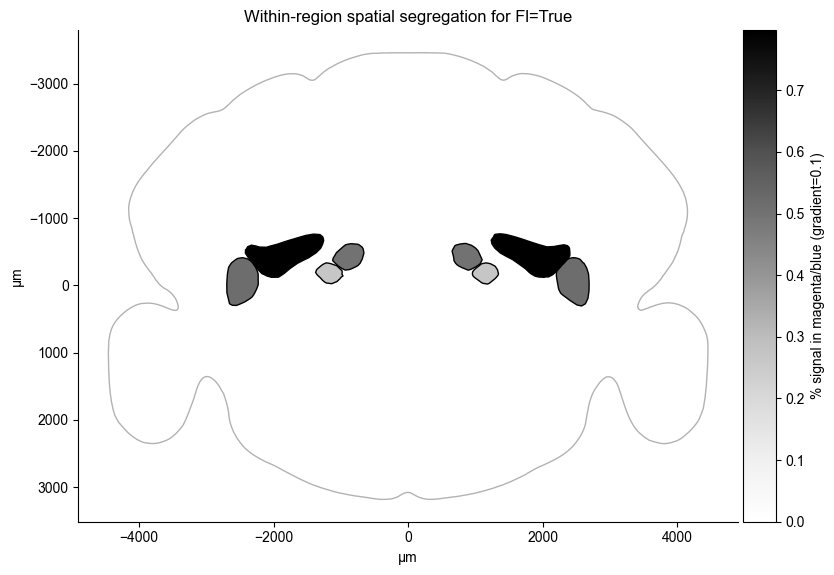

meta NOT subset; don't know how to subset; dropped


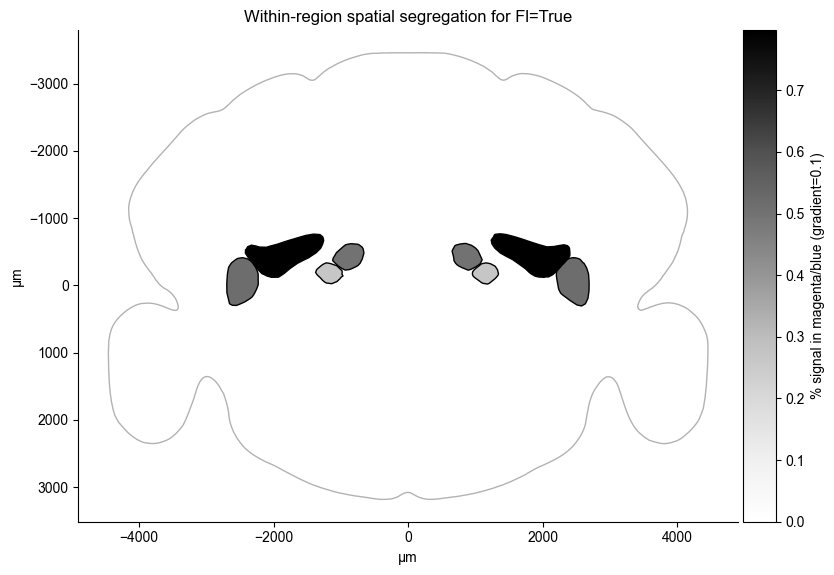

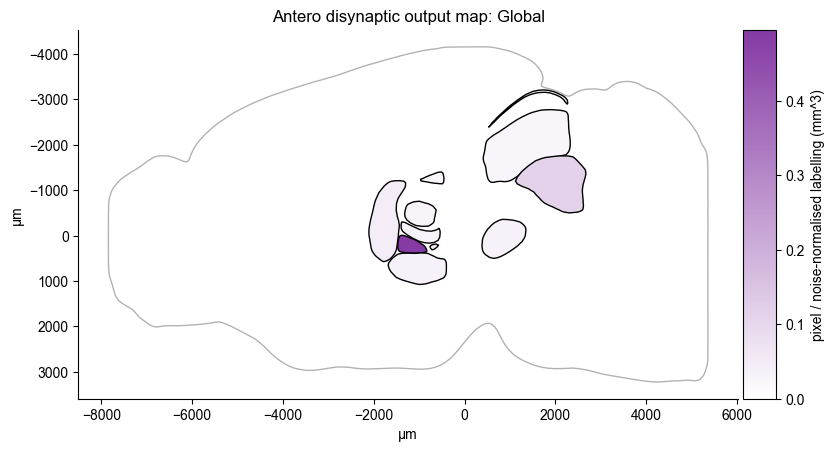

meta NOT subset; don't know how to subset; dropped


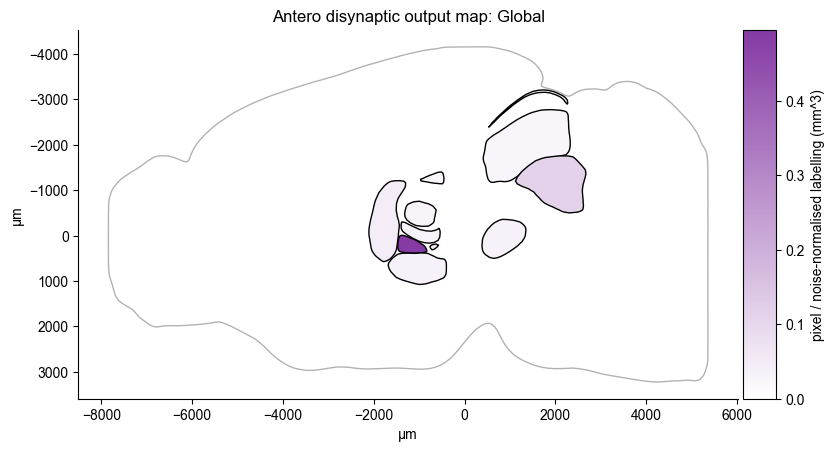

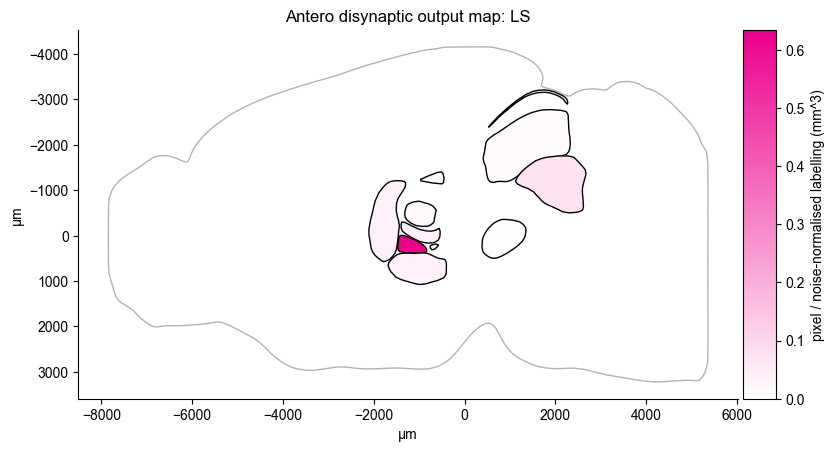

meta NOT subset; don't know how to subset; dropped


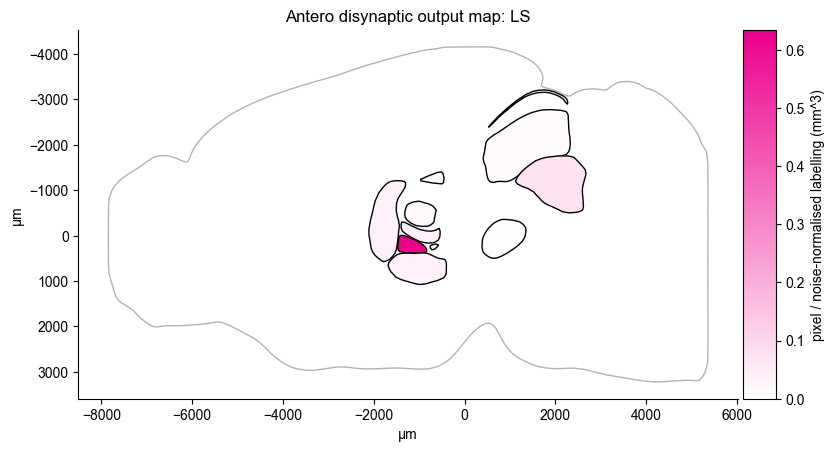

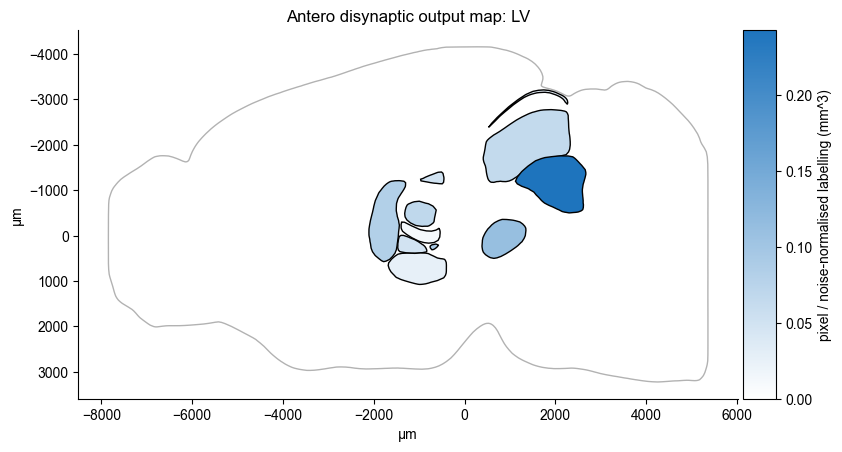

meta NOT subset; don't know how to subset; dropped


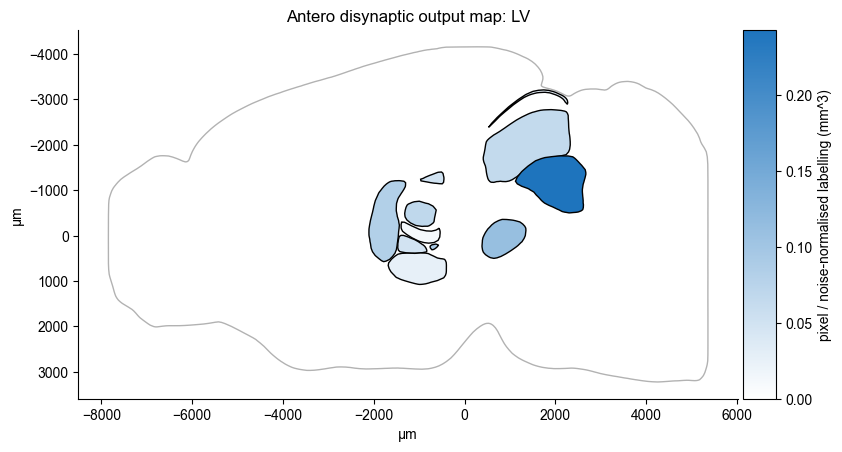

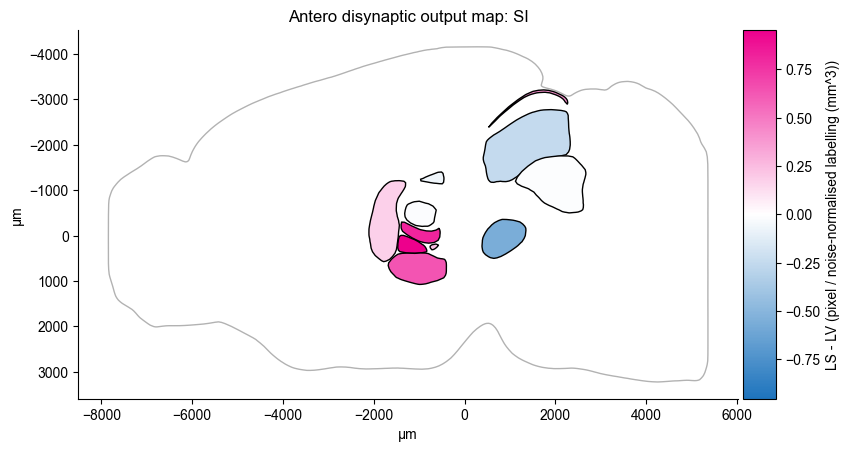

meta NOT subset; don't know how to subset; dropped


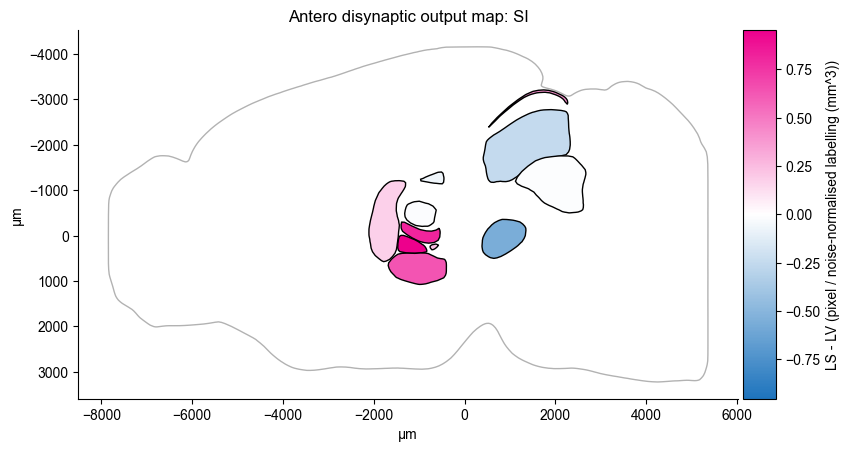

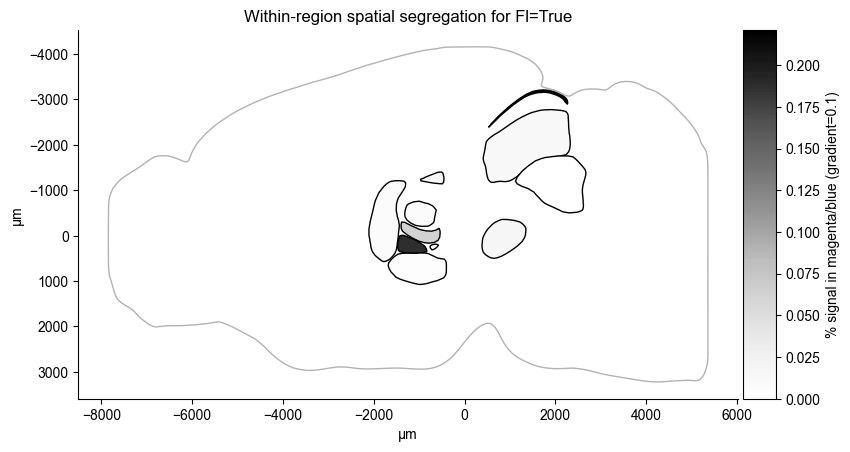

meta NOT subset; don't know how to subset; dropped


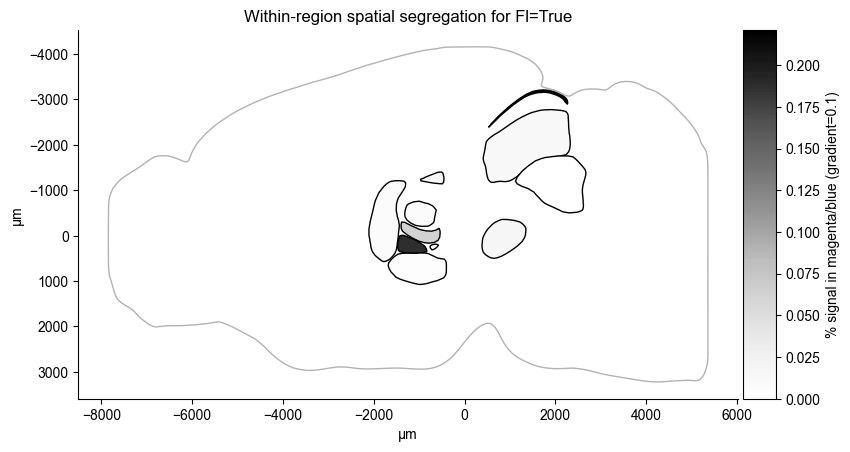

In [26]:
generate_fig7_heatmaps('r', False, rg_di_areas, all_incf_title, norm='presynaptics'    , orientation='sagittal', pair_plot_vmax=None, spatialseg_vmax=None, position=6500,  legend=False, areas_to_combine=areas_to_combine)
generate_fig7_heatmaps('r', True,  ag_mi_areas, all_inmf_title, norm='custom_pedestal', orientation='sagittal', pair_plot_vmax=None, spatialseg_vmax=0.55, position=6500,  legend=False)
generate_fig7_heatmaps('r', True,  ag_mo_areas, all_otmo_title, norm='custom_pedestal', orientation='frontal',  pair_plot_vmax=None, spatialseg_vmax=None, position=11300, legend=False)
generate_fig7_heatmaps('r', True,  ag_do_areas, all_otdi_title, norm='custom_division', orientation='sagittal', pair_plot_vmax=None, spatialseg_vmax=None, position=6500,  legend=False)

### Unknown function

In [51]:
def plot_sorted_input_output_matrices(area_func):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(18,10))
    btp.region_signal_matrix(area_func, value_norm='presynaptics', postprocess_for_scatter=True, vmax=None, figsize=(3,6), fluorescence=False, log_plot=False, ax=ax1)
    btp.region_signal_matrix(area_func, value_norm='custom_division', postprocess_for_scatter=True, vmax=None, figsize=(3,6), fluorescence=True, log_plot=False, ax=ax2)

C:\Users\Sam\miniconda3\envs\bt\lib\site-packages\braintracer\braintracer\plotting.py:1467: RuntimeWarning: invalid value encountered in double_scalars
  return ((g1_labelling - g2_labelling) / (g1_labelling + g2_labelling))


meta NOT subset; don't know how to subset; dropped


meta NOT subset; don't know how to subset; dropped


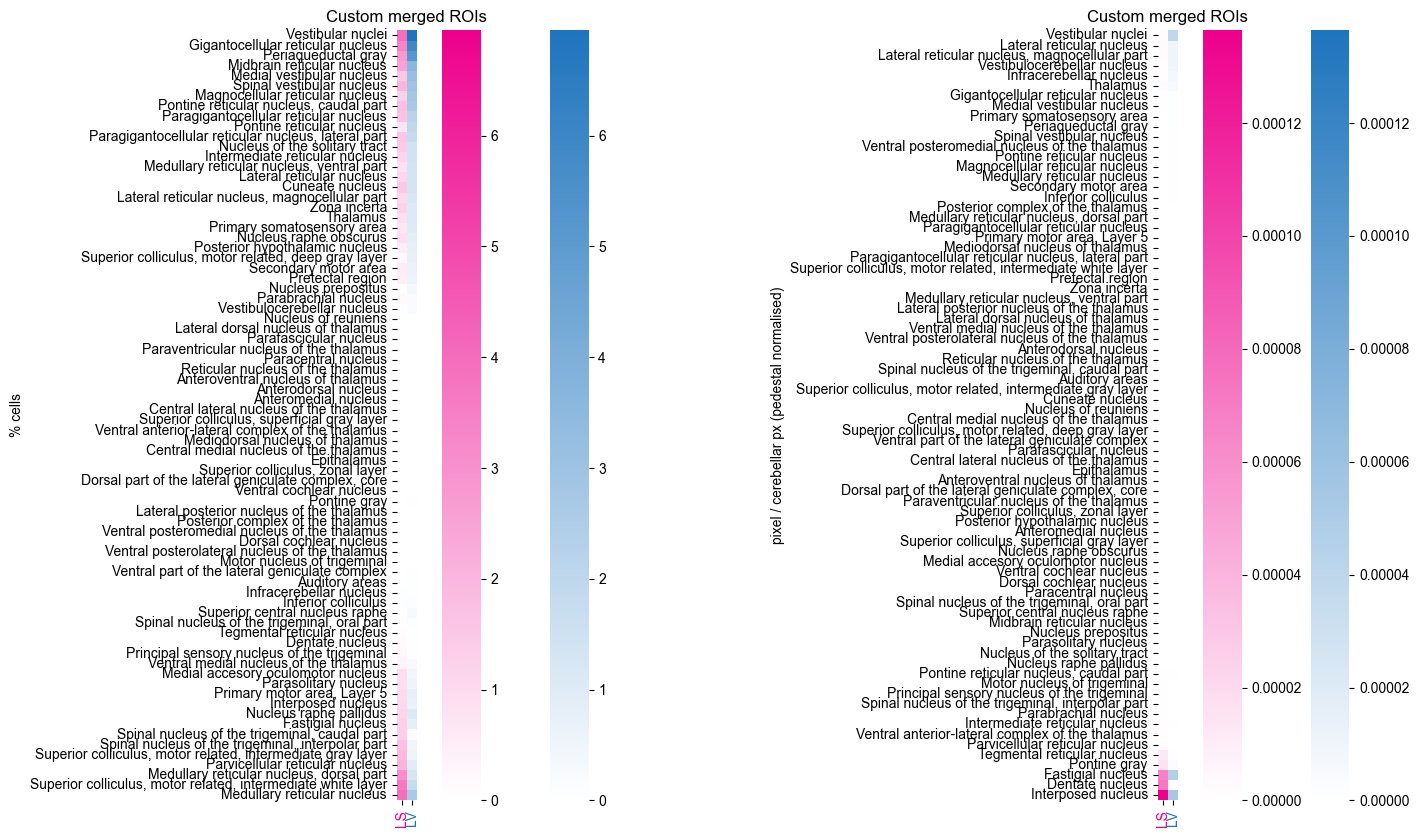

In [52]:
plot_sorted_input_output_matrices(all_areas_func)

### Global input-output analysis

In [211]:
def scatter_inputs_outputs(area_func, area_sets_for_marker_shape={}, areas_to_colour=[], areas_to_combine=None, log=False):
    f, axs = plt.subplots(1,3, figsize=(22,12))
    
    area_labels_i, cells_i, datasets, areas_title, axis_title_i = btp.get_matrix_data(area_func, postprocess_for_scatter=True, fluorescence=False, value_norm='presynaptics')
    area_labels_o, cells_o, _, _, axis_title_o = btp.get_matrix_data(area_func, postprocess_for_scatter=True, fluorescence=True, value_norm='custom_division')
    
    if areas_to_combine is not None:
        area_labels_i, cells_i, _ = btp.replace_areas_with_combined_area(areas_to_combine, area_labels_i, cells_i)
        area_labels_o, cells_o, _ = btp.replace_areas_with_combined_area(areas_to_combine, area_labels_o, cells_o)
    
    cells_o /= np.sum(cells_o)
    
    #btp.region_signal_matrix(area_func, postprocess_for_scatter=True, vmax=None, log_plot=False, sorting=False, ax=axs[0,1], fluorescence=False, value_norm='presynaptics', areas_to_combine=areas_to_combine)
    #btp.region_signal_matrix(area_func, postprocess_for_scatter=True, vmax=None, log_plot=False, sorting=False, ax=axs[0,2], fluorescence=True, value_norm='custom_division', areas_to_combine=areas_to_combine)
    
    def fit_model(model, y, x, name, c, log=False, labely=0.95, ax=None):
        X = np.array(x).reshape(len(x),1)
        line_X = np.arange(min(x), max(x))[:, np.newaxis]
        model.fit(X, y)
        line_y = model.predict(line_X)
        if log:
            line_y = np.exp(line_y)
        loss = mse(y, model.predict(X)) # compare true y values with the predictions based on x values
        if not log:
            loss = np.log(loss)
        r, p = stats.pearsonr(x, y)
        if ax != None:
            ax.plot(line_X, line_y, color=c, linewidth=1, label=f'{name}\nloss={loss:.2f}\nr={r:.6f}\np={p:.6f}')
            #ax.annotate(f'r = {r:.2f}, p = {p:.3f}', xy=(0.05, labely), xycoords='axes fraction')
        return model.estimator_.coef_, model.estimator_.intercept_, loss
    
    def check_merge_areas(name, function):
        if areas_to_combine is None:
            return None
        for idx, new_name in enumerate(areas_to_combine.keys()): # if no match was found, check if area name is in areas_to_combine
            if name == new_name:
                children = list(areas_to_combine.values())[idx]
                children_names = [bt.get_area_info(child)[0][0] for child in children]
                print(children_names)
                children_results = [function(name) for name in children_names]
                print(children_results)
                if all(children_results[0] == result for result in children_results): # if all children return the same result from the function, return that value
                    return children_results[0]
        return None
    
    def plot_with_data(col_num, title, cells_x, cells_y, area_names):
        xlim = np.max(cells_i) * 1.1
        
        cells_y_log = np.log(cells_y)
        coef = np.polyfit(cells_x, cells_y_log, 1)
        poly1d_fn = np.poly1d(coef) # poly1d_fn is now a function which takes in x and returns an estimate for y
        line_vals = np.linspace(0, xlim, 100)
        
        # calculate the marker shape and colour for each point
        assert cells_x.size == len(area_names), 'There should be the same number of points as area names!'
        markers = ['s', 'D', '^', '>', '2', 'H']
        colours = [list(colour) for colour in btp.cm.rainbow(np.linspace(0, 1, len(areas_to_colour)))] # as list
        area_labels_for_marker_shape = [bt.get_area_info(i)[0] for i in area_sets_for_marker_shape.values()]
        def marker_shape(area_name):
            for idx, labels in enumerate(area_labels_for_marker_shape):
                if area_name in labels:
                    return markers[idx]
            merge_shape = check_merge_areas(area_name, marker_shape)
            alt_shape = 'o' if merge_shape is None else merge_shape
            return alt_shape
        def marker_colour(area_name):
            for idx, region in enumerate(areas_to_colour):
                if area_name in bt.get_area_info(bt.children_from(region, depth=0)[1])[0]:
                    return colours[idx]
            merge_colour = check_merge_areas(area_name, marker_colour)
            alt_colour = 'k' if merge_colour is None else merge_colour
            return alt_colour
        xy_markers = [marker_shape(i) for i in area_names]
        xy_colours = [marker_colour(i) for i in area_names]
        
        # create the legend        
        for idx, colour in enumerate(xy_colours):
            if xy_colours.index(colour) == idx: # if first unique element
                label = areas_to_colour[colours.index(colour)] if colour != 'k' else 'Rest of Brain'
                axs[col_num].plot(-100, -100, 'o', c=colour, label=label)
        for idx, shape in enumerate(xy_markers):
            if xy_markers.index(shape) == idx:
                label = list(area_sets_for_marker_shape.keys())[markers.index(shape)] if shape != 'o' else 'Error'
                axs[col_num].plot(-100, -100, shape, c='k', label=label)
        
        for x, y, m, c in zip(cells_x, cells_y, xy_markers, xy_colours):
            axs[col_num].plot(x, y, m, c=c, ms=1.5)
        axs[col_num].set_title(f'{title} ({areas_title})')
        axs[col_num].set_xlabel(f'Input / {axis_title_i}')
        axs[col_num].set_ylabel(f'Output / {axis_title_o} (norm to 1)')
        if log:
            axs[col_num].set_yscale('log')
        ylim_mult = 0.1 if log else -0.1
        axs[col_num].set_ylim(np.min(cells_o) * ylim_mult, np.max(cells_o) * 10)
        axs[col_num].set_xlim(-xlim / 10, xlim)
        
        #axs[col_num].plot(line_vals, np.exp(left_poly1d_fn(line_vals)), '-r', label='Least squares (log tr.)')
        ransac_log = linear_model.RANSACRegressor(max_trials=30)
        ransac_loglin = linear_model.RANSACRegressor(max_trials=30)
        ransac = linear_model.RANSACRegressor(max_trials=30)
        #m, c, loss = fit_model(ransac, cells_y, cells_x, 'RANSAC (linear data)', c='b', log=False, ax=axs[col_num])
        m, c, loss = fit_model(ransac_loglin, cells_y, cells_x, 'RANSAC (linear data)', c='b', log=False, ax=axs[col_num])
        m, c, loss = fit_model(ransac_log, cells_y_log, cells_x, 'RANSAC (log data)', c='m', log=True, ax=axs[col_num], labely=0.9)
        axs[col_num].legend()
    
    plot_with_data(0, 'Global', cells_i.flatten(), cells_o.flatten(), area_labels_i * 2)
    plot_with_data(1, 'LS', cells_i[0], cells_o[0], area_labels_i)
    plot_with_data(2, 'LV', cells_i[1], cells_o[1], area_labels_i)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


['Pontine reticular nucleus', 'Pontine reticular nucleus, caudal part']
['Spinal nucleus of the trigeminal, caudal part', 'Spinal nucleus of the trigeminal, interpolar part', 'Spinal nucleus of the trigeminal, oral part']
['Pontine reticular nucleus', 'Pontine reticular nucleus, caudal part']
['Spinal nucleus of the trigeminal, caudal part', 'Spinal nucleus of the trigeminal, interpolar part', 'Spinal nucleus of the trigeminal, oral part']
['Spinal nucleus of the trigeminal, caudal part', 'Spinal nucleus of the trigeminal, interpolar part', 'Spinal nucleus of the trigeminal, oral part']
['s', 's', 's']
['Spinal nucleus of the trigeminal, caudal part', 'Spinal nucleus of the trigeminal, interpolar part', 'Spinal nucleus of the trigeminal, oral part']
['s', 's', 's']
['Spinal nucleus of the trigeminal, caudal part', 'Spinal nucleus of the trigeminal, interpolar part', 'Spinal nucleus of the trigeminal, oral part']
[[1.0, 1.2246467991473532e-16, 6.123233995736766e-17, 1.0], [1.0, 1.224646

meta NOT subset; don't know how to subset; dropped


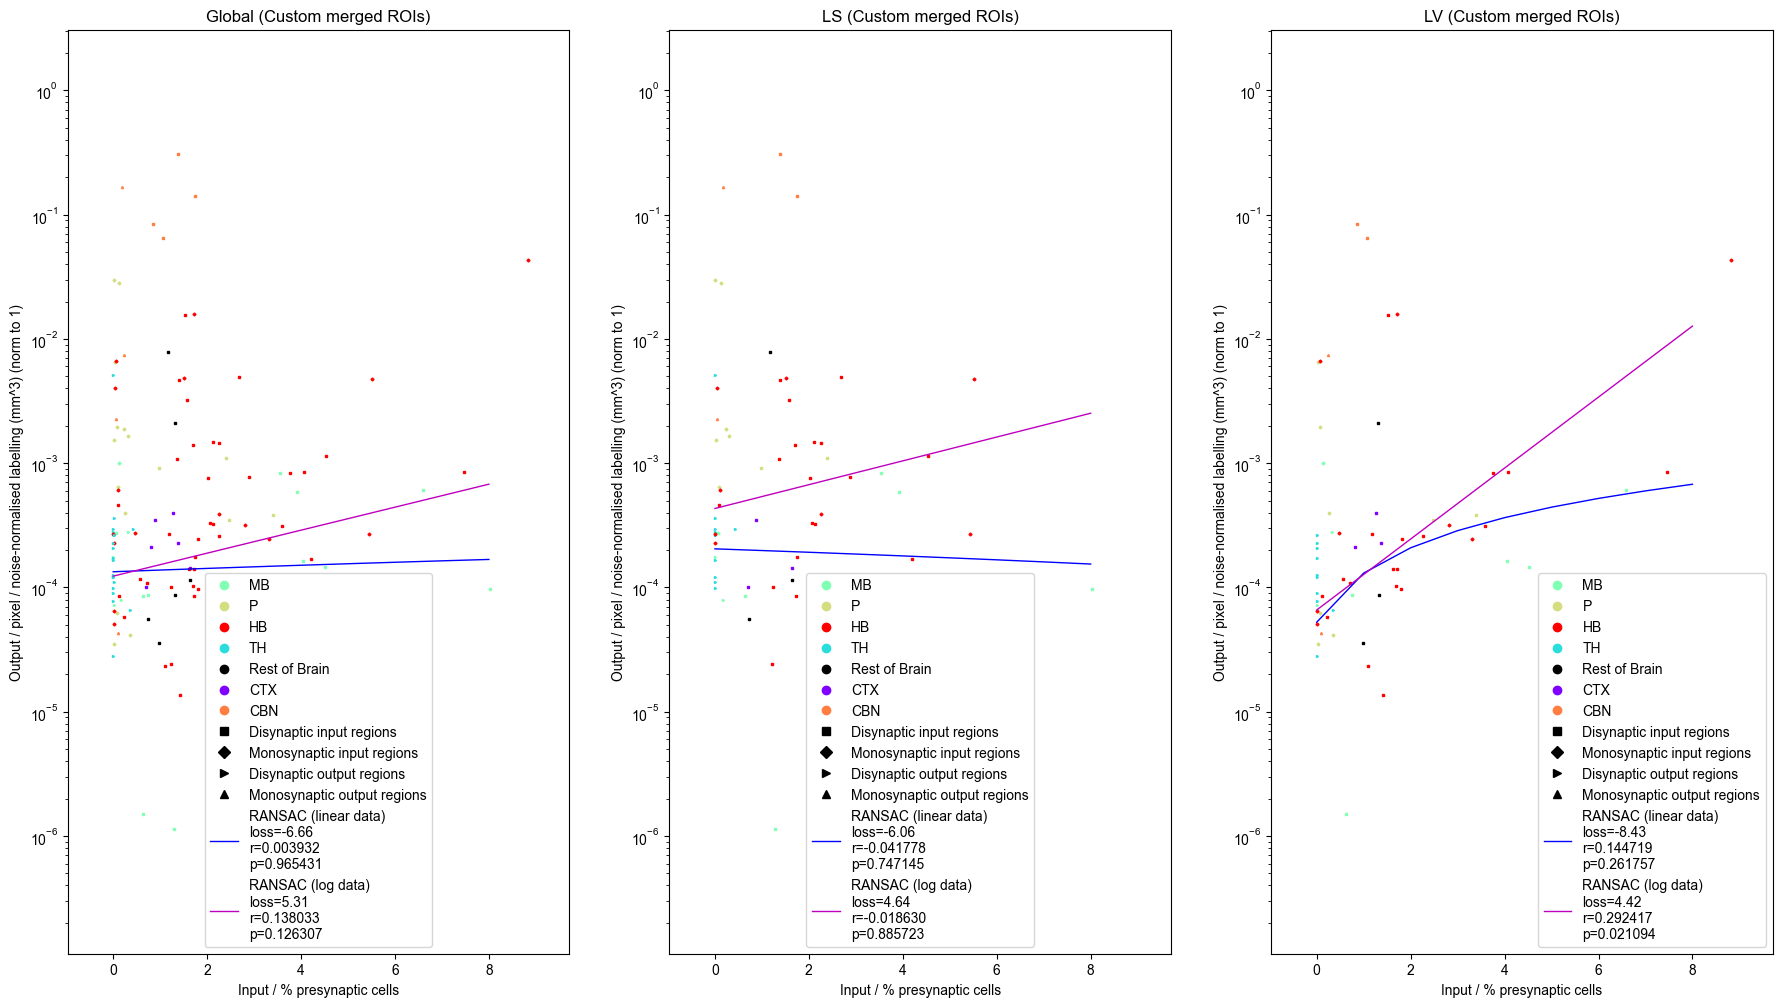

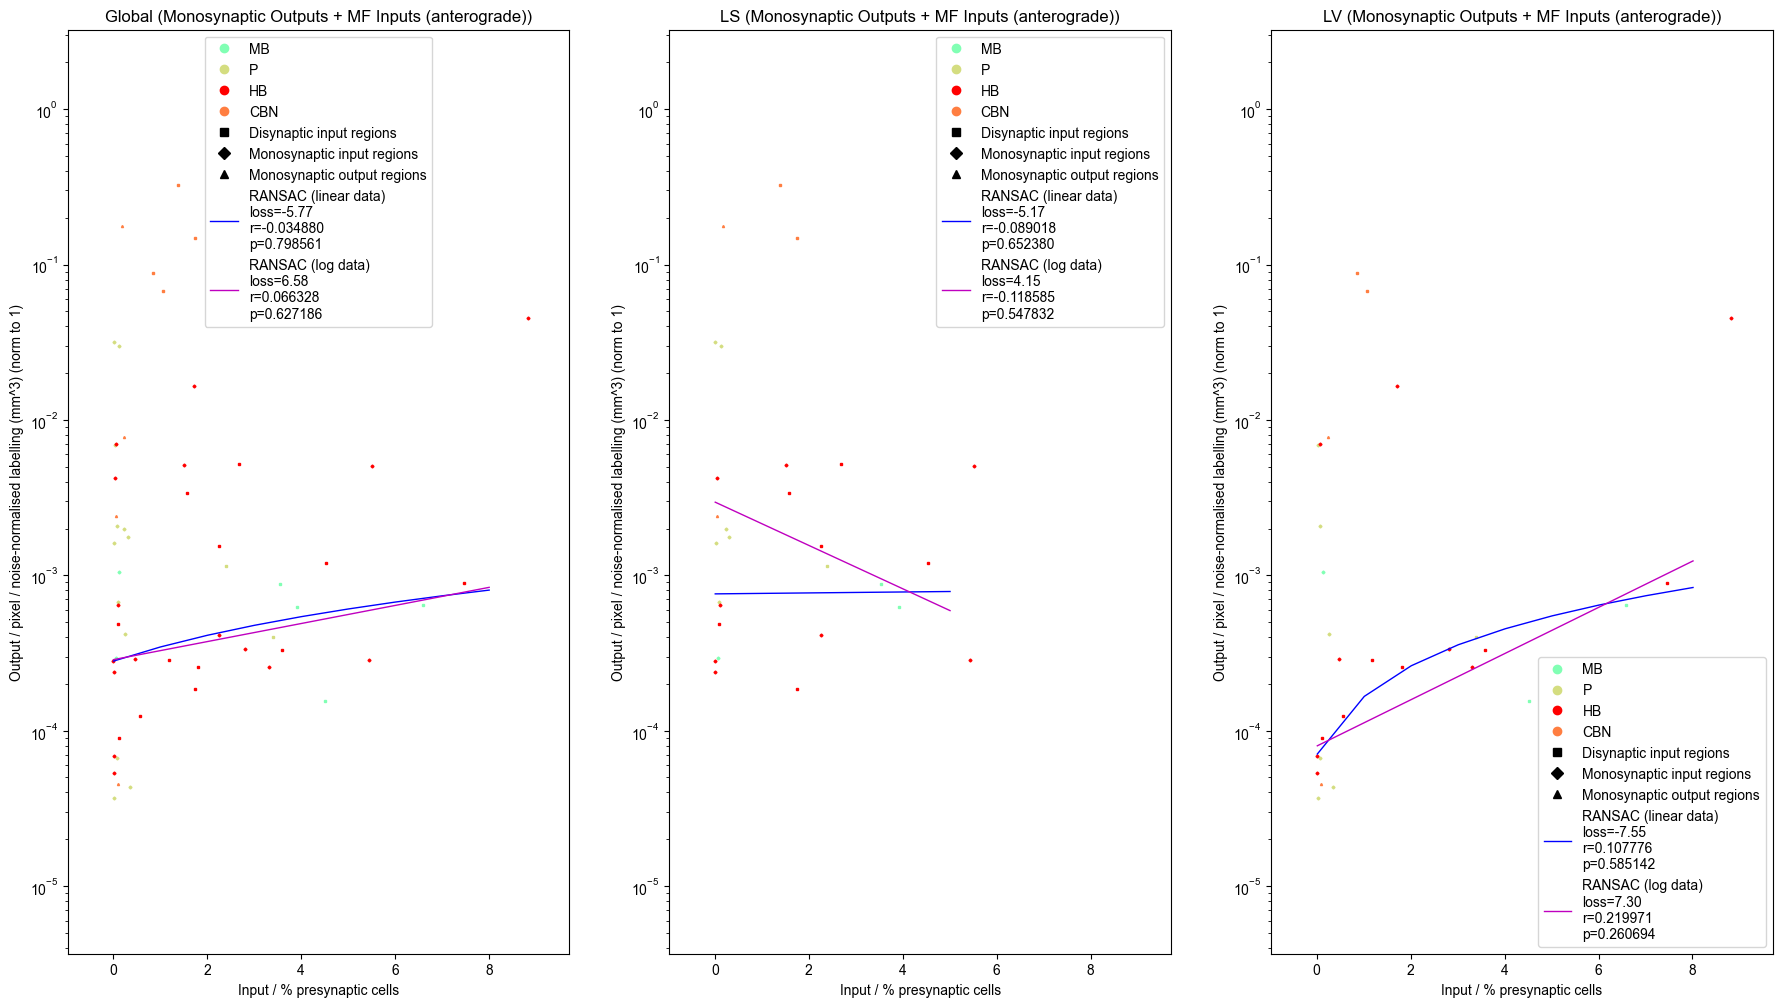

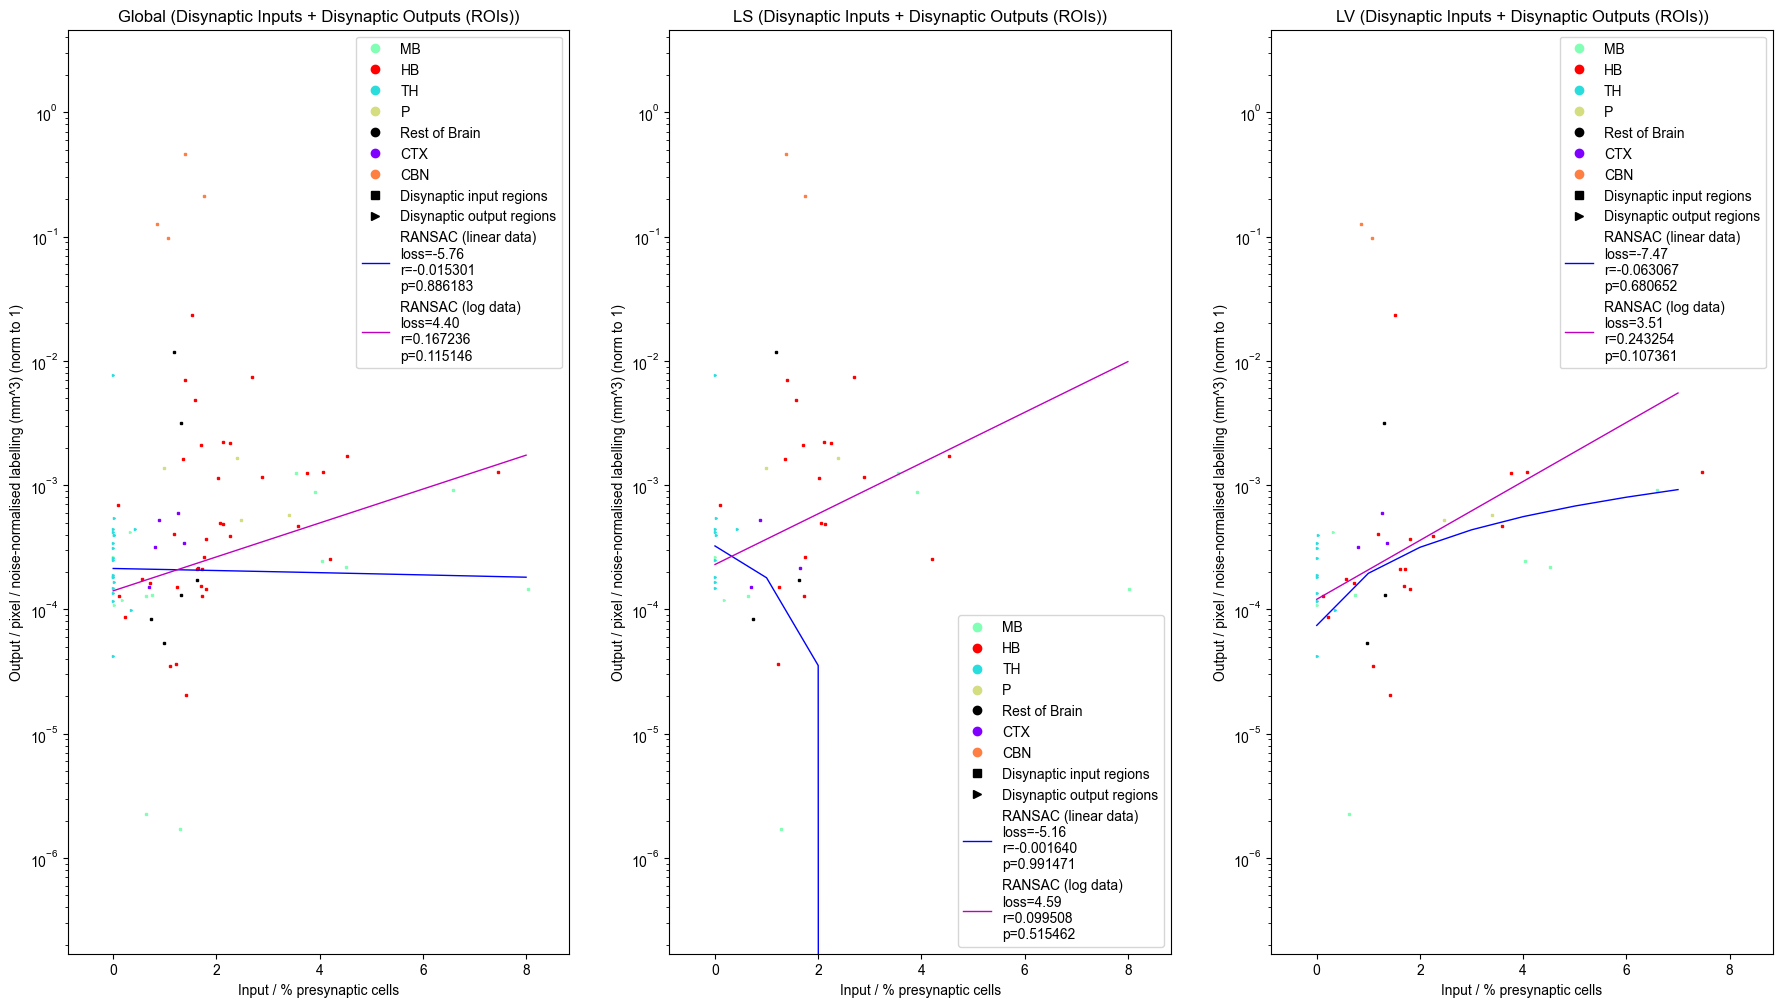

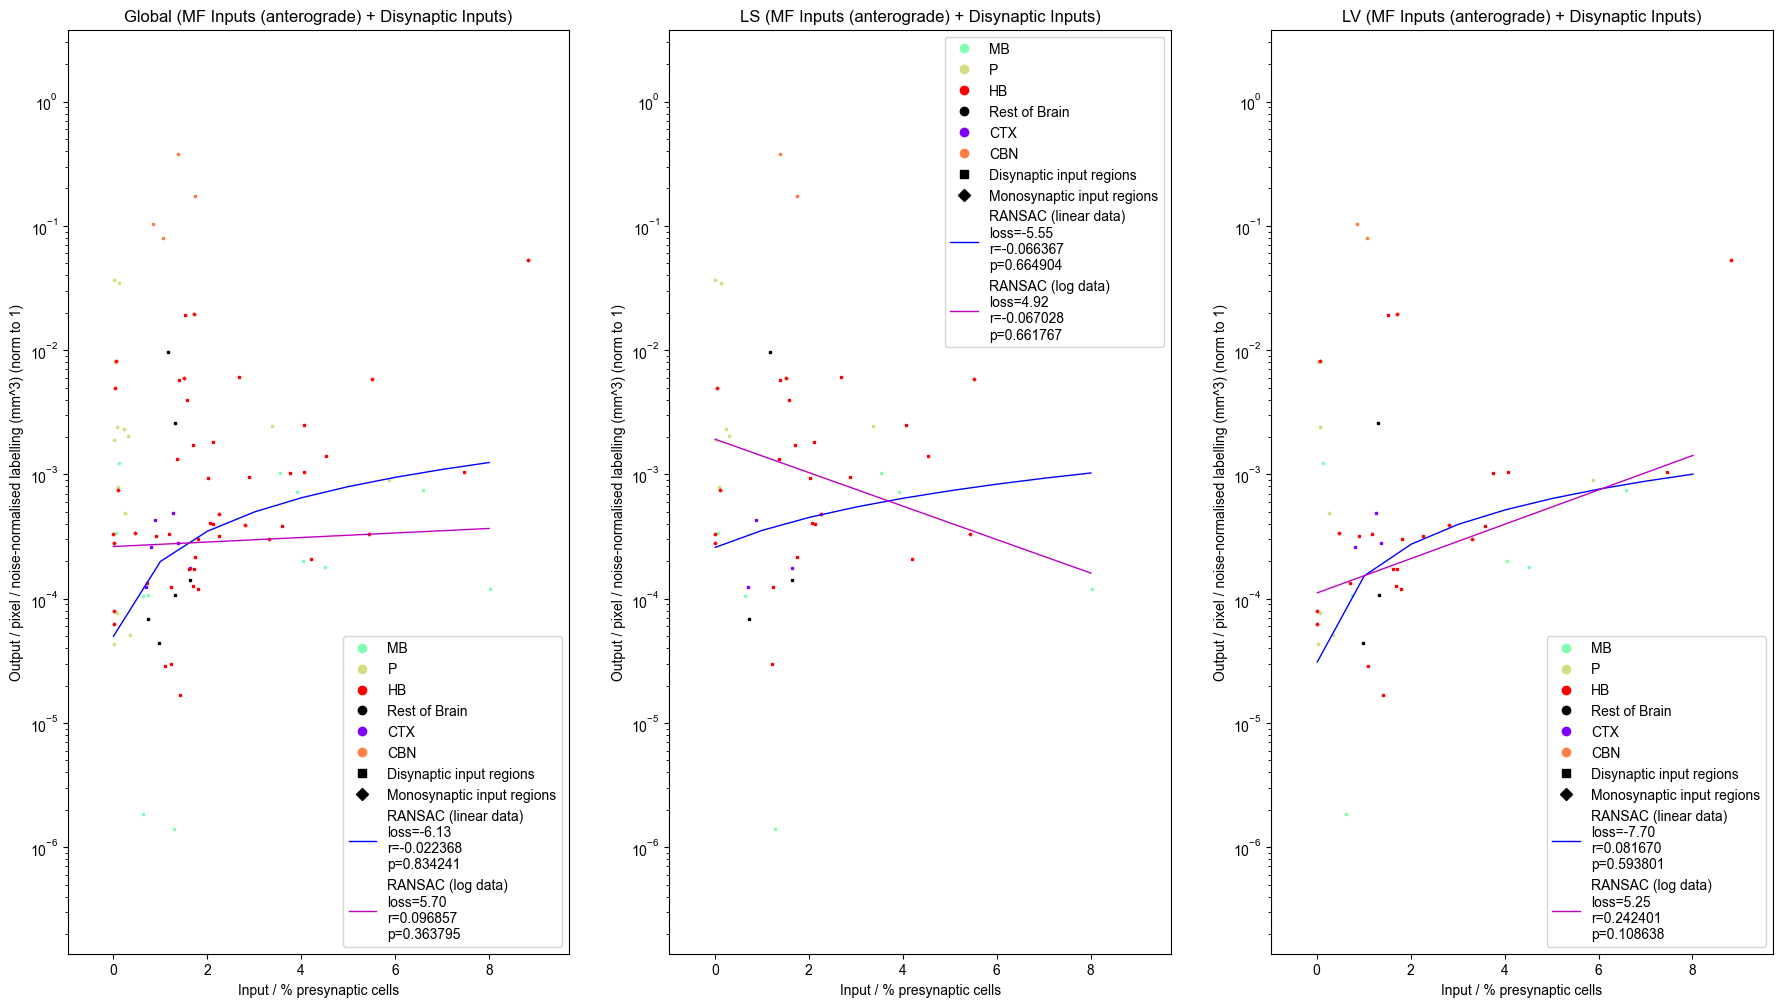

In [212]:
regions_to_colour = ['CTX','STR','TH','MB','P','CBN','HB'] # add IO back
area_sets_for_marker_shape = {'Disynaptic input regions':rg_di_areas,
                              'Monosynaptic input regions':ag_mi_areas,
                              'Monosynaptic output regions':ag_mo_areas,
                              'Disynaptic output regions':ag_do_areas}
for area_func in [all_areas_func, (m_areas, title_m), (d_areas, title_d), (ii_areas, title_ii)]:
    combi_areas = areas_to_combine if area_func[0] == ii_areas else None
    scatter_inputs_outputs(area_func, area_sets_for_marker_shape, regions_to_colour, areas_to_combine=combi_areas, log=True)
    btf.save(f'input-output scatter_{area_func[1]}', as_type='pdf')

### Global selectivity and spatial congruence analysis

In [103]:
def delete_below_threshold(area_labels, dataset_cells, correlations, threshold):
    sum_regions = np.sum(dataset_cells, axis=0)
    thresh = np.max(sum_regions) * threshold
    idxs_to_del = np.argwhere(sum_regions < thresh)
    dataset_cells = np.delete(dataset_cells, idxs_to_del, axis=1)
    area_labels = np.delete(area_labels, idxs_to_del, axis=0)
    correlations = np.delete(correlations, idxs_to_del, axis=0)
    return area_labels.tolist(), dataset_cells, correlations

In [106]:
def get_SI_and_corrs(channel, area_func, fluorescence, value_norm, threshold=None, gradient=0.1, areas_to_combine=None):
    area_labels, dataset_cells, _, _, _ = btp.get_matrix_data(area_func=area_func, postprocess_for_scatter=False, sort_matrix=False, fluorescence=fluorescence, value_norm=value_norm)
    correlations = btp.get_corr_indexes(channel, fluorescence, area_labels, gradient=gradient)
    
    if areas_to_combine is not None:
        area_labels, dataset_cells, correlations = btp.replace_areas_with_combined_area(areas_to_combine, area_labels, dataset_cells=dataset_cells, 
                                                                                        correlations=correlations, corr_channel=channel, corr_fl=fluorescence, corr_gradient=gradient)
    
    if threshold is not None:
        area_labels, dataset_cells, correlations = delete_below_threshold(area_labels, dataset_cells, correlations, threshold)
    
    _, num_g1 = btp.fetch_groups(fluorescence) # get sum across each group
    LS, LV = dataset_cells[0:num_g1,:], dataset_cells[num_g1:,:]
    SI_avgs, _, _ = btp.calculate_SI_with_errors(LS, LV)
    
    return SI_avgs, correlations

In [107]:
avgs_mi, corr_mi = get_SI_and_corrs('r', (ag_mi_areas, ag_mi_title), True, 'custom_pedestal', threshold=None, gradient=0.1)
avgs_mo, corr_mo = get_SI_and_corrs('r', (ag_mo_areas, ag_mo_title), True, 'custom_pedestal', threshold=None, gradient=0.1)
avgs_di, corr_di = get_SI_and_corrs('r', (rg_di_areas, rg_di_title), False, 'presynaptics', threshold=None, gradient=0.1, areas_to_combine=areas_to_combine)
avgs_do, corr_do = get_SI_and_corrs('r', (ag_do_areas, ag_do_title), True, 'custom_division', threshold=None, gradient=0.1)

Watch out! Remove padding for areas that touch the edge of the atlas.
Watch out! Remove padding for areas that touch the edge of the atlas.
Watch out! Remove padding for areas that touch the edge of the atlas.
Watch out! Remove padding for areas that touch the edge of the atlas.
Watch out! Remove padding for areas that touch the edge of the atlas.
Watch out! Remove padding for areas that touch the edge of the atlas.
Watch out! Remove padding for areas that touch the edge of the atlas.
Watch out! Remove padding for areas that touch the edge of the atlas.
['Pontine reticular nucleus', 'Pontine reticular nucleus, caudal part']
['Spinal nucleus of the trigeminal, caudal part', 'Spinal nucleus of the trigeminal, interpolar part', 'Spinal nucleus of the trigeminal, oral part']
Watch out! Remove padding for areas that touch the edge of the atlas.


### Caches for skipping computations in previous cell

In [12]:
# cached alternative at threshold=0.05, gradient=0.1
avgs_mi, corr_mi = [-0.7757690406743882, -0.4963943857566841, 0.5773600157981882, 0.8790497490022536, 0.5769699269509503, -0.5852323032863922, 0.20579254696643384, -0.5039100365834072], [0.3121951219512195, 0.5381526104417671, 0.18533604887983707, 0.43491422805247226, 0.11494252873563218, 0.18697829716193656, 0.004431314623338257, 0.15412186379928317]
avgs_mo, corr_mo = [-0.997141718679466, -0.1969055597968884, -0.4368004721513688, 0.7501610700187007], [0.5155709342560554, 0.5, 0.7972972972972973, 0.2661290322580645]
avgs_di, corr_di = [-0.997141718679466, -0.1969055597968884, -0.4368004721513688, 0.7501610700187007], [0.5155709342560554, 0.5, 0.7972972972972973, 0.2661290322580645]
avgs_do, corr_do = [-0.13934338594597676, -0.3557913487055629, -0.10187149497790932, -0.025132406516346593, -0.6076544606073396, -0.2445748237312996, 0.05469579813921099, 0.4858200076404808, -0.01262271531813506], [0.007009345794392523, 0.0625, 0.004043126684636119, 0.008116883116883116, 0.18806509945750452, 0.0038461538461538464, 0.007017543859649123, 0.017369727047146403, 0.0]

In [14]:
# cached alternative at threshold=None, gradient=0.1
avgs_mi, corr_mi = [-0.7757690406743882, -0.07607709306558788, -0.4963943857566841, 0.15944529200008492, -0.6459927038516244, -0.23432220274132273, -0.7078782504299166, -0.33057721496820164, 0.5773600157981882, 0.8790497490022536, 0.5769699269509503, -0.5852323032863922, -0.204327874614177, 0.3414569292491312, -0.5349543071493025, -0.16136306838642556, 0.20579254696643384, -0.0031546047498047652, -0.5039100365834072, 0.48338559207305665, -0.17435600339911259, 0.5179646480412834, -0.0052852423980394025, 0.3117817846922843],[0.3121951219512195, 0.16791044776119404, 0.5381526104417671, 0.13543599257884972, 0.11708253358925144, 0.05865921787709497, 0.37, 0.237012987012987, 0.18533604887983707, 0.43491422805247226, 0.11494252873563218, 0.18697829716193656, 0.12943632567849686, 0.008379888268156424, 0.12398373983739837, 0.15689981096408318, 0.004431314623338257, 0.010362694300518135, 0.15412186379928317, 0.0, 0.14886164623467601, 0.0695142378559464, 0.08026315789473684, 0.0]
avgs_mo, corr_mo = [-0.997141718679466, -0.1969055597968884, -0.4368004721513688, 0.7501610700187007], [0.5155709342560554, 0.5, 0.7972972972972973, 0.2661290322580645]
avgs_di, corr_di = [0.07608246837745776, -0.3086851447723645, 0.11581179382361292, 0.24481262933309406, 0.09711619263665115, -0.032942762759072, -0.048821282748976014, 0.2265886003262361, 0.06903809995141587, 0.3526067508025342, -0.310725741349222, -0.330303991097727, -0.019342191965443005, 0.049515067843517856, 0.12890574754134812, 0.2256468441774374, -0.4382754440151895, 0.06285407978023967, 0.1807097370216657, 0.3112101204118935, 0.14923462015506728, 0.04562872321667838, 0.14976240649022532, 0.08169521627143793, -0.18429484396521775, -0.03196209464085939, 0.03938234655656549, -0.23309584317571336, 0.25880525539175486, -0.4395592142109072],[0.23204419889502761, 0.017543859649122806, 0.19290780141843972, 0.27765726681127983, 0.7019867549668874, 0.0, 0.023809523809523808, 0.07344632768361582, 0.5247148288973384, 0.09, 0.03571428571428571, 0.34573304157549234, 0.163727959697733, 0.18729096989966554, 0.19672131147540983, 0.24015748031496062, 0.3888888888888889, 0.34294871794871795, 0.1895910780669145, 0.25272331154684097, 0.07279693486590039, 0.35714285714285715, 1.0, 0.6839378238341969, 0.4090909090909091, 0.5136612021857924, 0.6666666666666666, 0.5539845758354756, 0.4165202108963093, 0.5892193308550185]
avgs_do, corr_do = [-0.13934338594597676, -0.13850254016850883, -0.023412442162089413, -0.3557913487055629, 0.043768414277705586, -0.10187149497790932, -0.025132406516346593, -0.6076544606073396, -0.2445748237312996, 0.05469579813921099, -0.1759178084556532, 0.2167499709590341, 0.4858200076404808, -0.01262271531813506],[0.007009345794392523, 0.0027472527472527475, 0.004511278195488722, 0.0625, 0.011306532663316583, 0.004043126684636119, 0.008116883116883116, 0.18806509945750452, 0.0038461538461538464, 0.007017543859649123, 0.22105263157894736, 0.013354700854700854, 0.017369727047146403, 0.0]

In [15]:
avgs_m = avgs_mi + avgs_mo
avgs_d = avgs_di + avgs_do
corr_m = corr_mi + corr_mo
corr_d = corr_di + corr_do

In [17]:
from scipy.optimize import curve_fit, minimize
from scipy.special import factorial
from scipy.optimize import minimize

In [18]:
def lognorm(x, mu, sigma):
    return 1/(np.sqrt(2*np.pi)*sigma*x)*np.exp(-((np.log(x)- mu)**2)/(2*sigma**2))

In [19]:
def min_function(params, x, y):
    model = lognorm(x, *params)
    residual = ((y - model) ** 2).sum()
    
    #if model[0] > 0.01:
    #    residual += 1000  # Just some large value

    return residual

In [85]:
def plot_ks(title, dist1, dist2, x0, cumulative=False, isVertical=True, legend=True, ax=None):
    if ax is None:
        f, ax = plt.subplots(figsize=(8,5))
    #ax.set_title('KS Test')
    statistic, p = stats.kstest(dist1, dist2, alternative='two_sided')
    
    orientation = 'vertical' if isVertical else 'horizontal'
    
    ax.annotate(f's={statistic:.2g}, p={p:.2g}', xy=(.3,.7), xycoords="axes fraction")
    
    def add_cumulative_line(dist, colour, title_fit, ax):
        dist_len = len(dist)
        dist_sorted = sorted(dist)
        dist_sorted.insert(0, 0)
        line_y_coords = [idx / dist_len for idx, val in enumerate(dist_sorted)]
        x, y = dist_sorted, line_y_coords
        if not isVertical:
            x, y = y, x
        ax.plot(x, y, color=colour, label=f"{title_fit}")
        ax.set_ylabel('Frequency')
        ax.set_xlabel(title)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1);
    
    def add_lognorm_fit(dist, colour, title_fit, ax):
        orientation = 'vertical' if isVertical else 'horizontal'
        y_vals, _, _ = ax.hist(dist, color=colour, alpha=0.5, bins=bins, label=f"{title_fit}", orientation=orientation);
        x_dummy = np.linspace(-0.5, 1.5, 10_000)
        x_vals = bin_centres
        
        res = minimize(min_function, x0=x0, args=(x_vals, y_vals))
        print(f'{res.message} (After {res.nit} iterations.)')
        
        x = x_dummy
        y = lognorm(x_dummy, *res.x)
        if not isVertical:
            x, y = y, x
        ax.plot(x, y, color=colour, label=f'Lognorm: func={res.fun:.2g}')
        
        if isVertical:
            ax.set_ylabel('Frequency')
            ax.set_xlabel(title)
            ax.set_xlim(-0.1, 1.1)
            ax.set_ylim(0, np.max(y_vals) * 1.25);
        else:
            ax.set_xlabel('Frequency')
            ax.set_ylabel(title)
            ax.set_ylim(-0.1, 1.1)
            ax.set_xlim(0, np.max(y_vals) * 1.25);
    
    if cumulative:
        add_cumulative_line(dist1, 'tab:gray', title_m, ax)
        add_cumulative_line(dist2, 'tab:purple', title_d, ax)
    else:
        add_lognorm_fit(dist1, 'tab:gray', title_m, ax)
        add_lognorm_fit(dist2, 'tab:purple', title_d, ax)
    if legend:
        ax.legend()
    
    btf.save(f'ks_test_{title}', as_type='pdf')

In [ ]:
plot1_mono, plot1_di, plot2_mono, plot2_di = np.abs(np.nan_to_num(avgs_m, nan=0)), np.abs(np.nan_to_num(avgs_d, nan=0)), np.abs(np.nan_to_num(corr_m, nan=0)), np.abs(np.nan_to_num(corr_d, nan=0))
bins=np.histogram(np.hstack((plot1_mono, plot1_di, plot2_mono, plot2_di)), bins=25)[1]
bin_centres = 0.5 * (bins[1:] + bins[:-1])

Optimization terminated successfully. (After 8 iterations.)
Optimization terminated successfully. (After 15 iterations.)


C:\Users\Sam\AppData\Local\Temp\ipykernel_8152\266889240.py:2: RuntimeWarning: invalid value encountered in log
  return 1/(np.sqrt(2*np.pi)*sigma*x)*np.exp(-((np.log(x)- mu)**2)/(2*sigma**2))
meta NOT subset; don't know how to subset; dropped


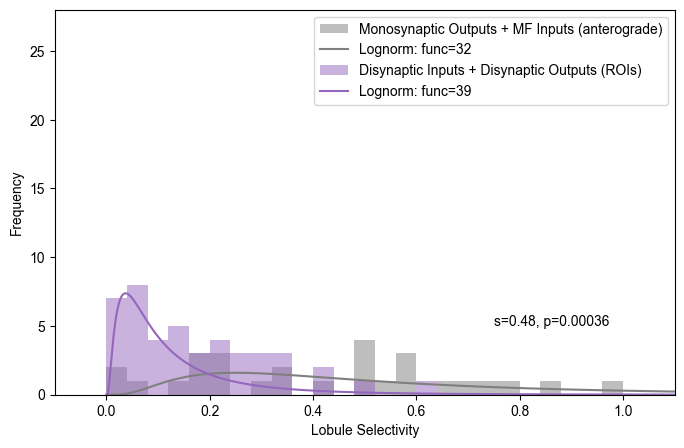

In [24]:
plot_ks('Selectivity Index', plot1_mono, plot1_di, isVertical=True)

Optimization terminated successfully. (After 13 iterations.)
Optimization terminated successfully. (After 22 iterations.)


C:\Users\Sam\AppData\Local\Temp\ipykernel_8152\266889240.py:2: RuntimeWarning: invalid value encountered in log
  return 1/(np.sqrt(2*np.pi)*sigma*x)*np.exp(-((np.log(x)- mu)**2)/(2*sigma**2))
meta NOT subset; don't know how to subset; dropped


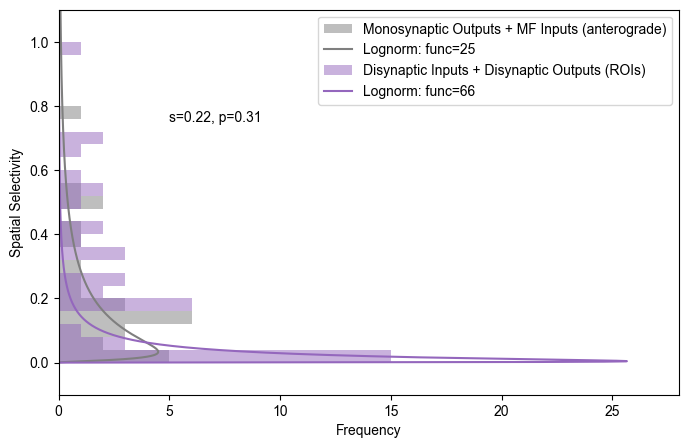

In [25]:
plot_ks('Spatial Dissimilarity', plot2_mono, plot2_di, isVertical=False)

In [93]:
def si_vs_sd_scatter(title_1, title_2, plt_1_1, plt_1_2, plt_2_1, plt_2_2, si_1, si_2, sd_1, sd_2, x0, cumulative=False):
    f, axs = plt.subplots(2, 2, figsize=(10,10), width_ratios=[1,3], height_ratios=[3,1])
    axs[1,0].axis('off')
    plot_ks('', plt_1_1, plt_1_2, x0=x0, cumulative=cumulative, isVertical=False, legend=False, ax=axs[0,0]) # Spatial Selectivity
    plot_ks('', plt_2_1, plt_2_2, x0=x0, cumulative=cumulative, isVertical=True, legend=False, ax=axs[1,1]) # Lobule Selectivity
    axs[0,0].invert_xaxis()
    axs[1,1].invert_yaxis()
    axs[0,0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    axs[1,1].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    axs[0,1].scatter(np.abs(si_1), sd_1, c='tab:gray', marker='^', label=title_1)
    axs[0,1].scatter(np.abs(si_2), sd_2, c='tab:purple', marker='^', label=title_2)
    #axs[0,1].scatter(np.abs(avgs_mo), corr_mo, c='tab:gray', marker='.', label='Monosynaptic outputs')
    #axs[0,1].scatter(np.abs(avgs_do), corr_do, c='tab:purple', marker='.', label='Disynaptic outputs')
    axs[0,1].set_title('SI vs SD')
    axs[0,1].set_xlabel('Selectivity Index')
    axs[0,1].set_ylabel('Spatial Dissimilarity')
    axs[0,1].legend()
    axs[0,1].grid()
    axs[0,1].set_xlim(-0.02, 1.02); axs[1,1].set_xlim(-0.02, 1.02)
    axs[0,1].set_ylim(-0.02, 1.02); axs[0,0].set_ylim(-0.02, 1.02)
    btf.save(f'SI_corrs_scatter_{title_1}_vs_{title_2}_cmltv={cumulative}', as_type='pdf')

In [94]:
# Only inputs
plot_mi_si, plot_di_si, plot_mi_sd, plot_di_sd = np.abs(np.nan_to_num(avgs_mi, nan=0)), np.abs(np.nan_to_num(avgs_di, nan=0)), np.abs(np.nan_to_num(corr_mi, nan=0)), np.abs(np.nan_to_num(corr_di, nan=0))
bins=np.histogram(np.hstack((plot_mi_si, plot_di_si, plot_mi_sd, plot_di_sd)), bins=25)[1]
bin_centres = 0.5 * (bins[1:] + bins[:-1])

Optimization terminated successfully. (After 14 iterations.)
Optimization terminated successfully. (After 11 iterations.)


C:\Users\Sam\AppData\Local\Temp\ipykernel_8152\266889240.py:2: RuntimeWarning: invalid value encountered in log
  return 1/(np.sqrt(2*np.pi)*sigma*x)*np.exp(-((np.log(x)- mu)**2)/(2*sigma**2))
meta NOT subset; don't know how to subset; dropped


Optimization terminated successfully. (After 13 iterations.)
Optimization terminated successfully. (After 16 iterations.)


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


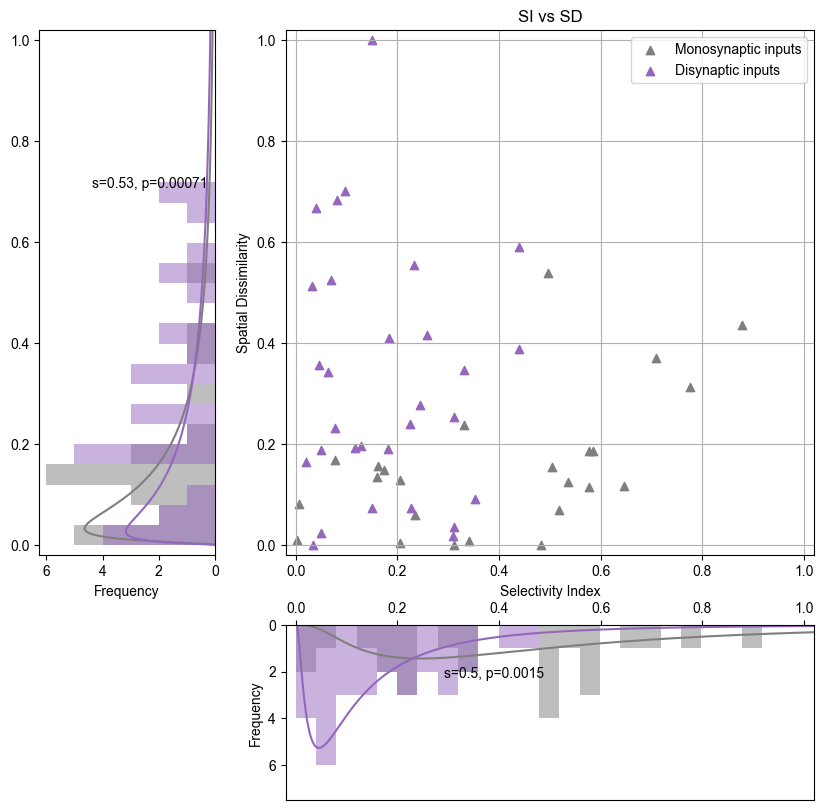

In [98]:
si_vs_sd_scatter('Monosynaptic inputs', 'Disynaptic inputs', plot_mi_sd, plot_di_sd, plot_mi_si, plot_di_si, avgs_mi, avgs_di, corr_mi, corr_di, x0=(0.8, 0.8), cumulative=False)

In [101]:
# Only outputs
plot_mo_si, plot_do_si, plot_mo_sd, plot_do_sd = np.abs(np.nan_to_num(avgs_mo, nan=0)), np.abs(np.nan_to_num(avgs_do, nan=0)), np.abs(np.nan_to_num(corr_mo, nan=0)), np.abs(np.nan_to_num(corr_do, nan=0))
bins=np.histogram(np.hstack((plot_mo_si, plot_do_si, plot_mo_sd, plot_do_sd)), bins=25)[1]
bin_centres = 0.5 * (bins[1:] + bins[:-1])

Optimization terminated successfully. (After 9 iterations.)
Optimization terminated successfully. (After 15 iterations.)


C:\Users\Sam\AppData\Local\Temp\ipykernel_8152\266889240.py:2: RuntimeWarning: invalid value encountered in log
  return 1/(np.sqrt(2*np.pi)*sigma*x)*np.exp(-((np.log(x)- mu)**2)/(2*sigma**2))
meta NOT subset; don't know how to subset; dropped


Optimization terminated successfully. (After 9 iterations.)
Optimization terminated successfully. (After 9 iterations.)


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


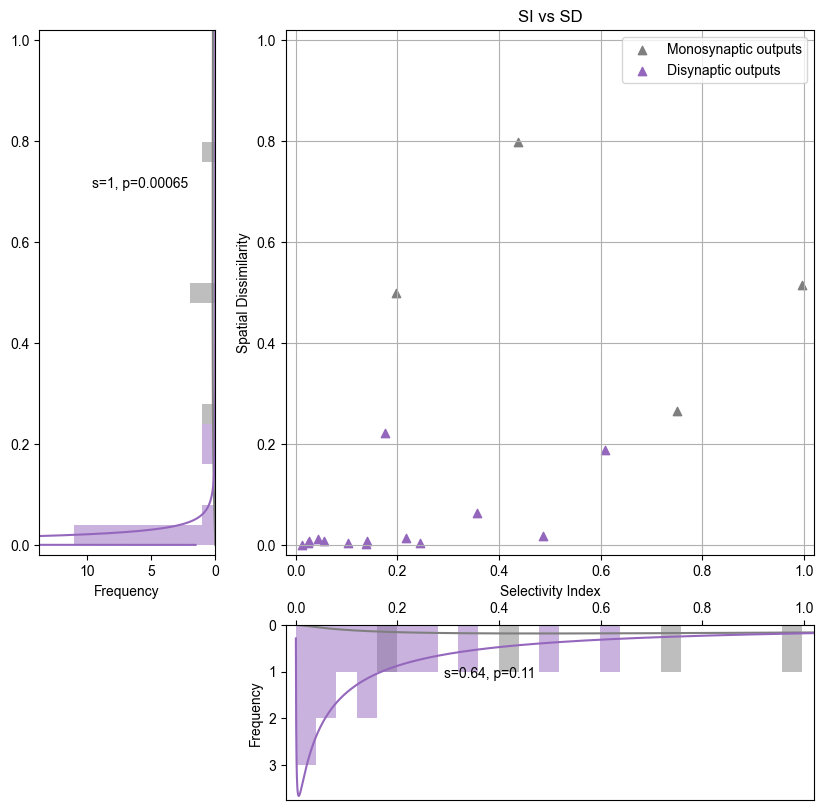

In [102]:
si_vs_sd_scatter('Monosynaptic outputs', 'Disynaptic outputs', plot_mo_sd, plot_do_sd, plot_mo_si, plot_do_si, avgs_mo, avgs_do, corr_mo, corr_do, x0=(0, 1), cumulative=False)

## Image Stack Functions

In [1]:
bt.datasets[0].show_coronal_section(slice_frac=(5,2751), cells_pm=5)
#btf.save('FR210_coronal_section', as_type='png')

NameError: name 'bt' is not defined

(0.0, 1319.0) (0.0, 799.0)


((365, 145, 823), (775, 340, 1023))

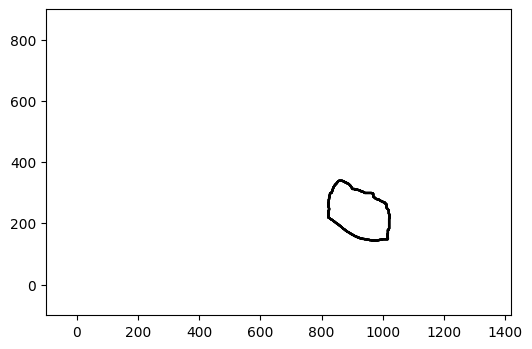

In [14]:
f, ax = plt.subplots(figsize=(6,6))
btp.plot_projection(ax, 294, padding=100, axis=2)

(0.0, 1319.0) (0.0, 799.0)


C:\Users\Sam\miniconda3\envs\bt\lib\site-packages\braintracer\braintracer\plotting.py:553: RuntimeWarning: divide by zero encountered in log
  data_projection = np.log(stack.max(axis=2-axis))


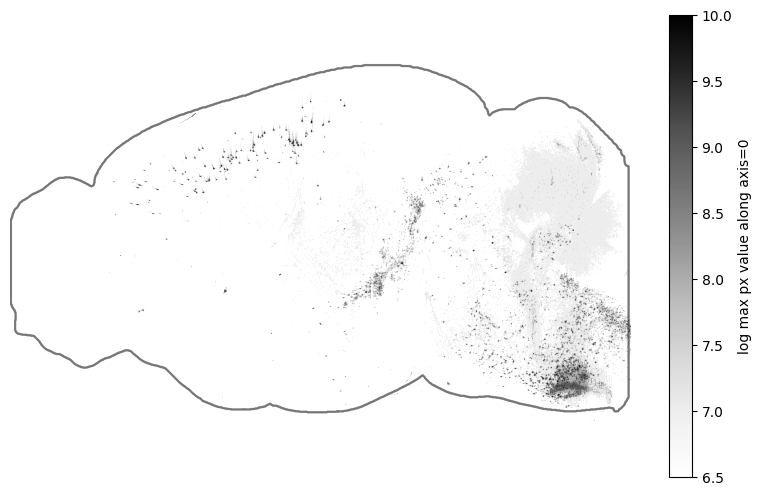

In [9]:
dataset = bt.datasets[15] # LS: 2, 7, (15), LV: 4, 5, 6, (16)
top = False
vmin = 6.5
btp.generate_brain_overview(dataset, axis=0, vmin=vmin, cmap='Greys', padding=None)
btf.save(f'rawProj_{dataset.name}_side={top}_min={vmin}', as_type='pdf')
# show the raw image stack projection, top_down gives orientation

## 3D Spatial Binning

In [13]:
# IO: [8, 10, 12, 9, 16, 15, 0, 7, 5, 6, 13, 2, 3, 11, 4, 1, 14]
btp.bin_3D_matrix(83, binsize=100, aspect='auto', vbounds=(0,1), sigma=2, threshold=0, cmap='gray', order_method='average', blind_order=True, covmat=True, figsize=(20,7))

TypeError: 'dict' object is not callable

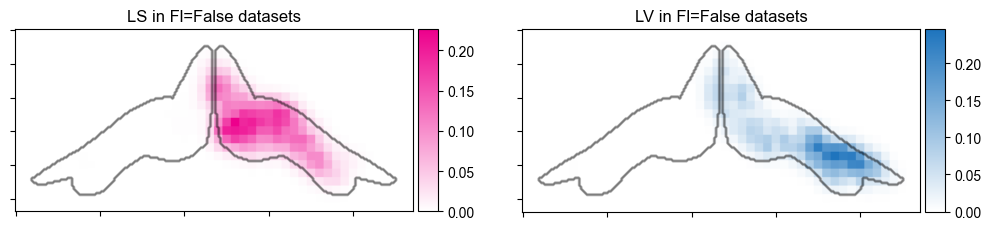

In [7]:
btp.probability_map('r', False, area_num=83, binsize=50, axis=2, sigma=1, subregions=None, projcol='k', padding=10)
# Axis: coronal (2), horizontal (1), or sagittal (0)

(0.0, 609.0) (0.0, 507.0)
Upper limit: 0.13167748048302425


meta NOT subset; don't know how to subset; dropped


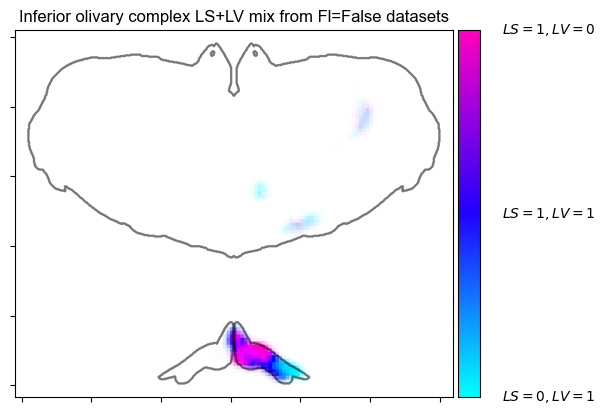

In [7]:
btp.probability_map_overlap('r', False, area_num=[83,549], binsize=50, axis=2, sigma=1, saturation_multiplier=3)

Bins of last dataset: (115, 81, 133), average number of bins containing cells: 28.11764705882353
604065 voxels removed by threshold=0, unless showing correlation matrix.


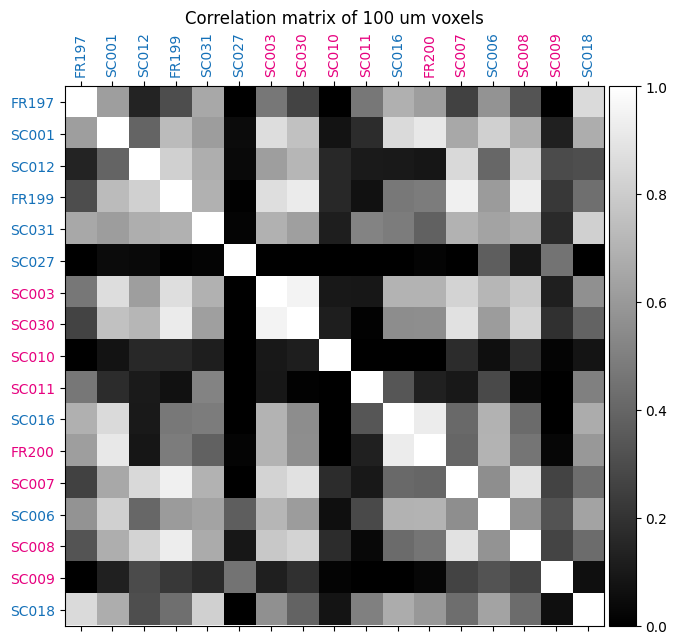

In [9]:
btp.bin_3D_matrix(549, binsize=100, aspect='auto', vbounds=(0,1), sigma=2, threshold=0, cmap='gray', order_method='average', blind_order=True, override_order=[8, 10, 12, 9, 16, 15, 0, 7, 5, 6, 13, 2, 3, 11, 4, 1, 14], covmat=True, figsize=(20,7))
# BIN INTO VOXELS
# this function is slightly complicated because it can make multiple different plots
# count matrix: covmat=False. only need aspect, vbounds, threshold, cmap, and figsize.
# correlation matrix: covmat=True. set area_num to correlate one region, None for whole brain. Sorting: set order_method e.g. 'average', set blind_order to determine if supervised with site label, set override_order to order by another matrix's order regardless of other sorting parameters

All areas: [1129, 313, 688, 354, 771, 1097, 549, 323, 379, 370, 386, 1117, 987, 290, 128, 795, 294, 230, 1048, 136, 235, 307, 395, 938, 852, 701, 720, 651, 437, 146, 1093, 797, 10, 17, 500, 453, 955, 1098, 1107, 978, 202, 225, 711, 985]
Area 1129 contains: [1097, 549, 290, 797]
Area 313 contains: [323, 128, 795, 294, 10, 17]
Area 688 contains: [500, 453, 985]
Area 354 contains: [379, 370, 386, 230, 1048, 136, 235, 307, 395, 938, 852, 701, 720, 651, 437, 955, 1098, 1107, 978, 202, 225, 711]
Area 771 contains: [1117, 987, 146, 1093]


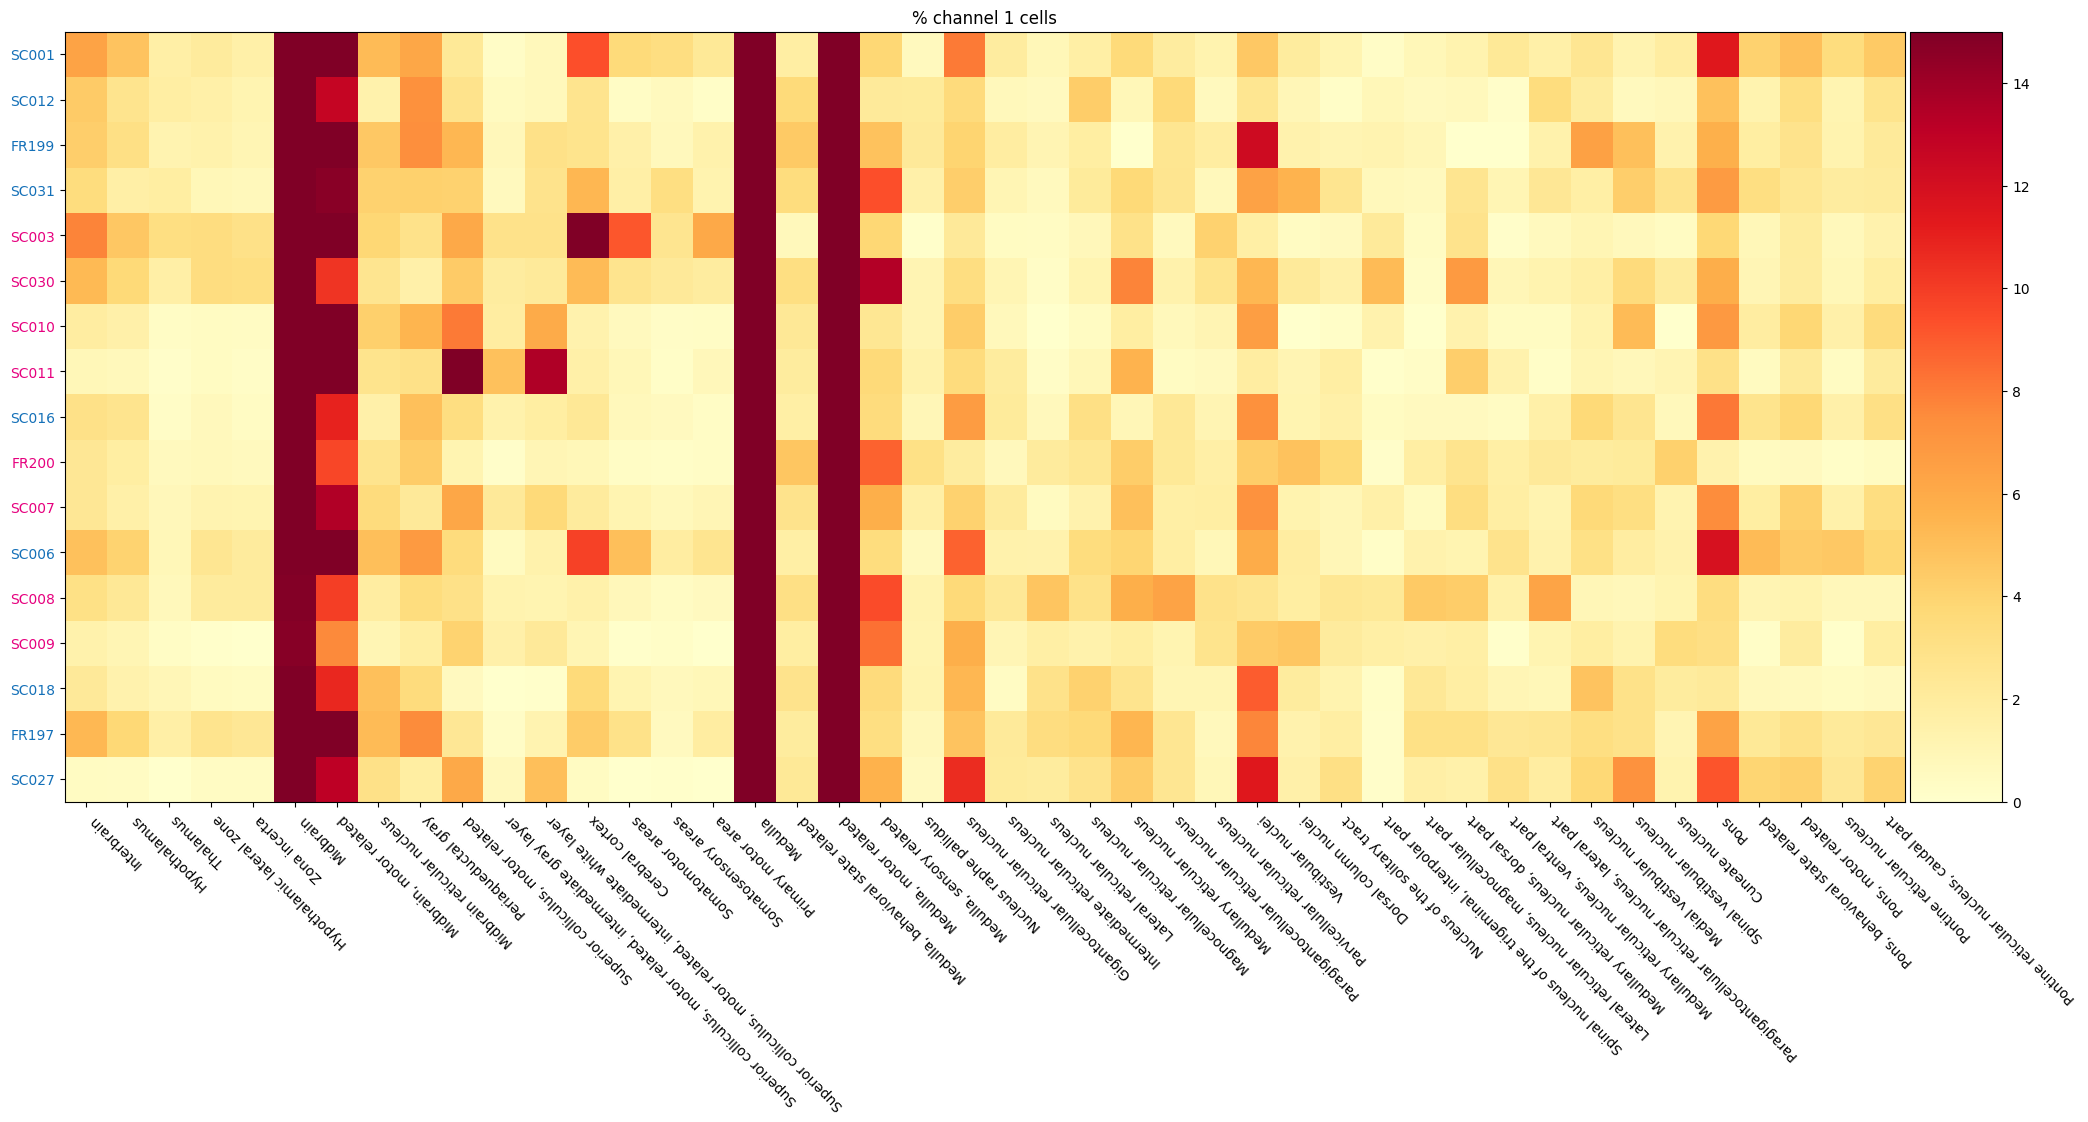

In [4]:
parent, children = bt.children_from('CB', depth=0)
children = np.array(children)
children = np.append(children, [512, 8, 1009, 960, 728, 83]) # big areas + IO
children = np.append(children, [567, 695, 315]) # duplicate cerebral cortex regions
children = np.append(children, [343, 1065]) # remove areas that inherit everything, e.g. brainstem

btp.generate_matrix_plot(threshold=1, ignore=children, vbounds=(0,15), normalisation='ch1', override_order=[10, 12, 9, 16, 0, 7, 5, 6, 13, 2, 3, 11, 4, 1, 14, 8, 15], covmat=False, rowvar=1, zscore=False, cmap='YlOrRd', figsize=(25,10), aspect='auto')
#btf.save('matrix_whole_brain_areas_unsupervised', as_type='pdf')
# BIN INTO REGIONS
# count matrix: covmat=False. threshold selects regions by minimum, ignore=[] regions to exclude, normalisation ['postsynaptics':per starter, 'ch1':% all, None:#cells], rowvar selects variable on x/y axis
# correlation matrix: covmat=True.

## General Functions

In [6]:
bt.get_area_info(['IO'], bt.datasets[0].ch1_cells_by_area)
# get information about an individual region

(['Inferior olivary complex'], [83], [4])

In [5]:
bt.datasets[0].num_cells(ch1=True)
# total cells in a dataset

1955

In [7]:
sum_cells = 0
for dataset in bt.datasets:
    sum_cells = sum_cells + bt.get_area_info(519, dataset.ch1_cells_by_area)[2][0]
    print(bt.get_area_info('CBN', dataset.ch1_cells_by_area)[2][0])
sum_cells / len(bt.datasets)
# mean number of cells in an area

109
28
12
11
119
47
53
315
63
40
37
29
75
15
56
101
234


79.05882352941177

View results in braintracer/TRIO.


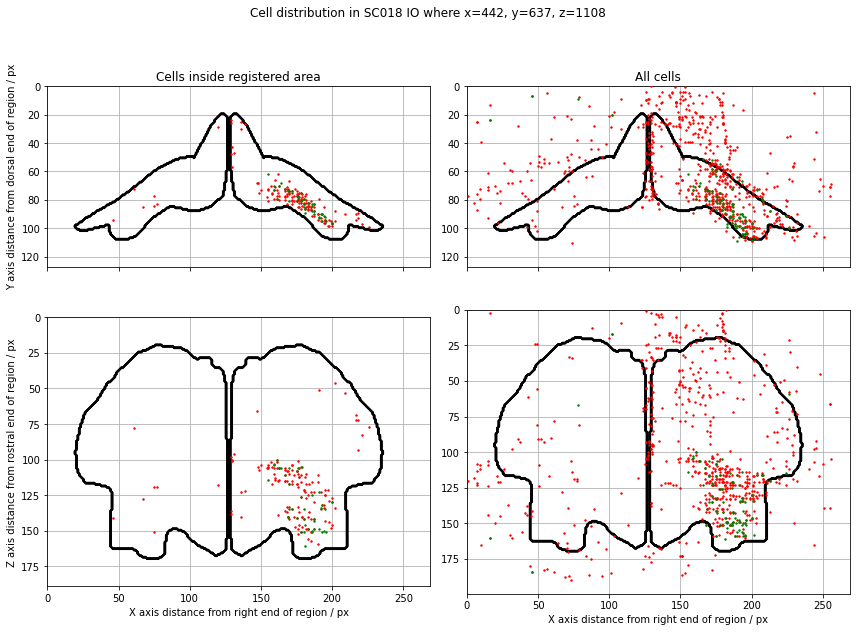

In [4]:
btp._generate_starter_validation_plot(padding=20)
# confirm where cell detections are in the starter region of each imported dataset

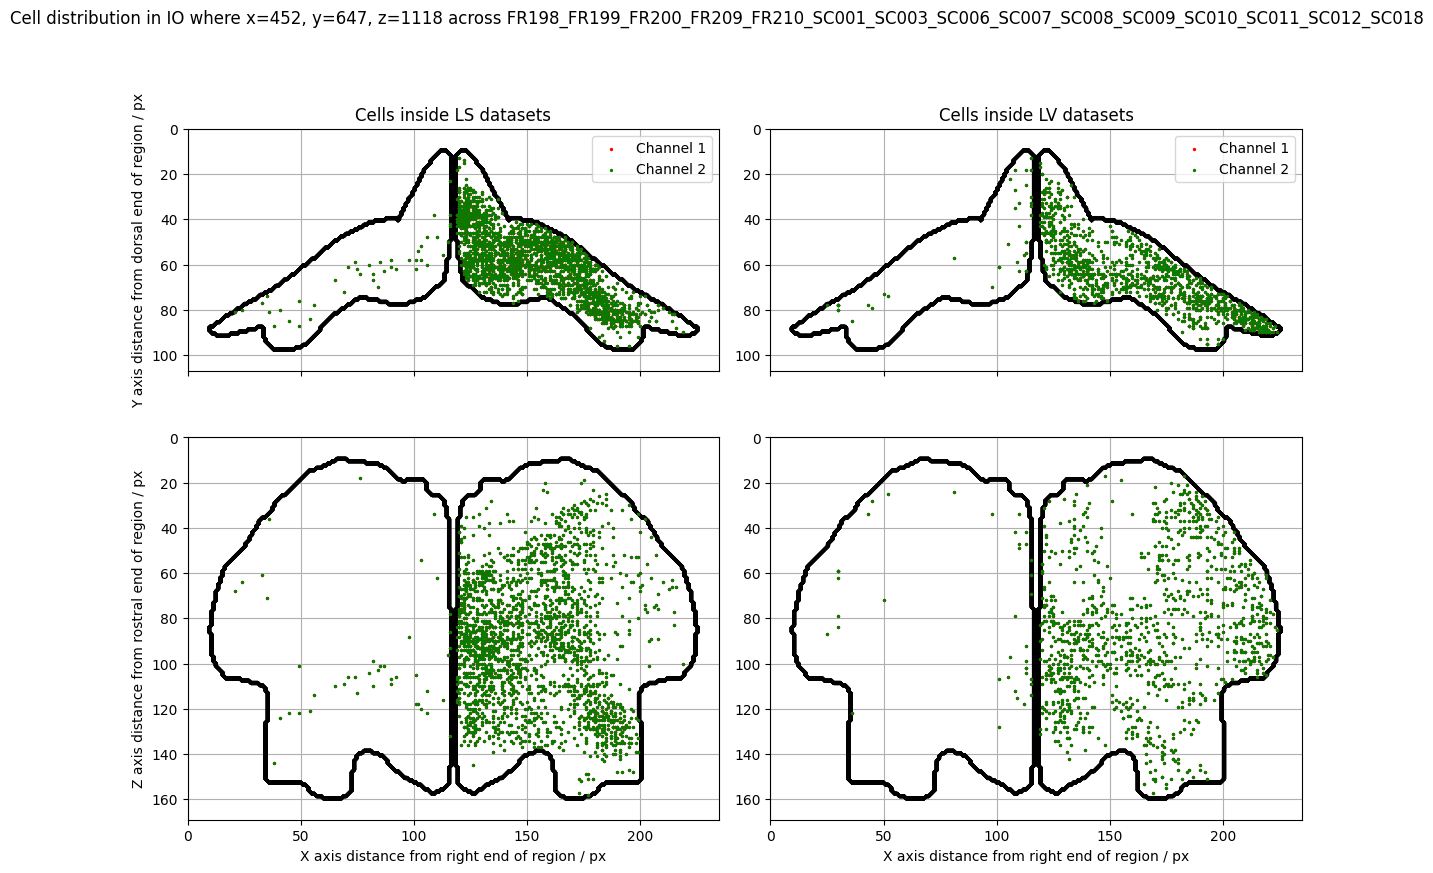

In [35]:
btp.generate_projection_plot('IO')
#btf.save(f'IO_projection_{title}', as_type='png')
# plot all cell coordinates by group in area

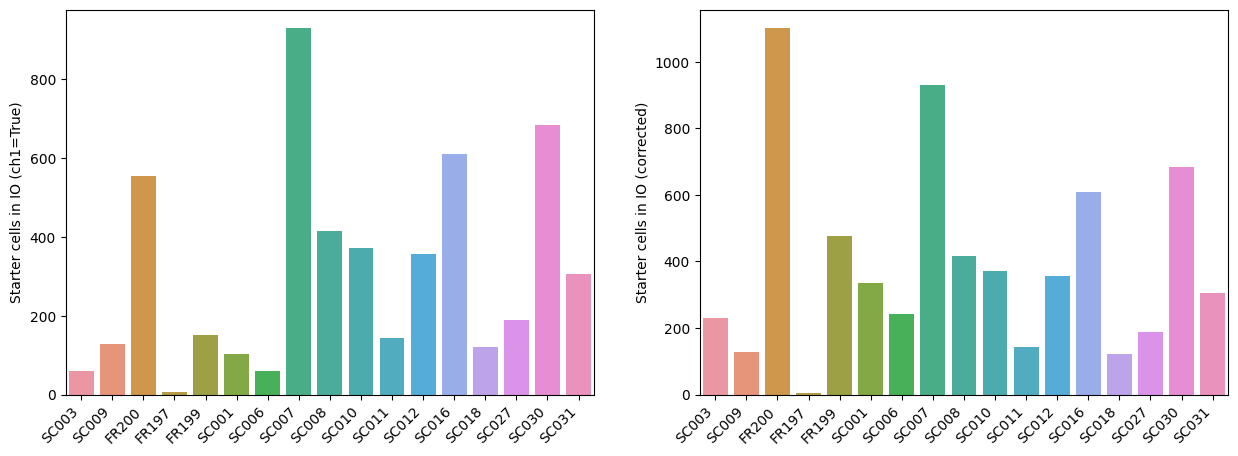

In [4]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
f.set_facecolor('white')
btp.generate_starter_cell_plot(ax=ax1, true_only=True)
btp.generate_starter_cell_plot(ax=ax2)
# plot the number of starter cells across datasets

meta NOT subset; don't know how to subset; dropped


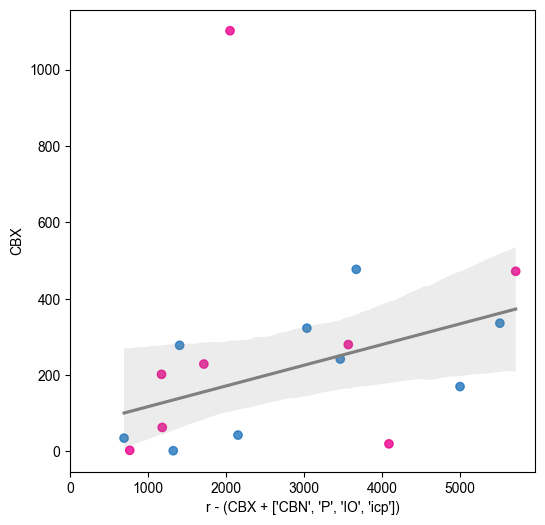

In [9]:
btp.region_comparison_scatter(False, 'prePost', set_postsyn_values_to_line=False, exclude_dataset_idx_from_line_fit=[])

[23384497 15496704 20066462 37301411 10844051 23088270 15735538 17829494]
[58920000000 24760000000 36480000000 53200000000 19150000000 40880000000
 26600000000 21890000000]


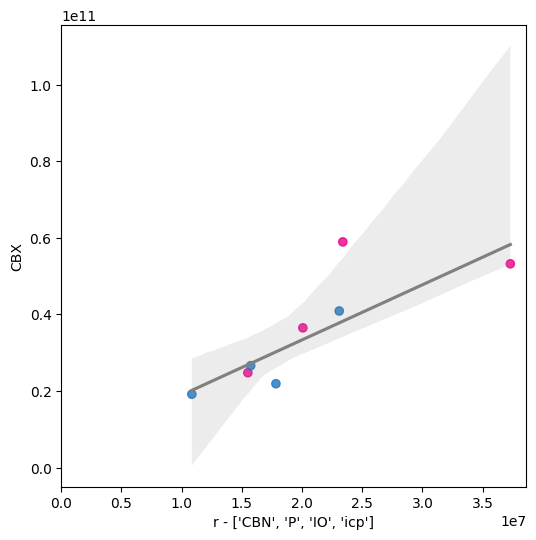

In [14]:
# IMPORTANT: this function corrects extreme starter cell counts FOR DOWNSTREAM ANALYSIS when set_postsyn_values_to_line=False
try:
    btp.region_comparison_scatter(True, 'prePostAntero', set_postsyn_values_to_line=False, exclude_dataset_idx_from_line_fit=[])
finally:
    send_email_notification()

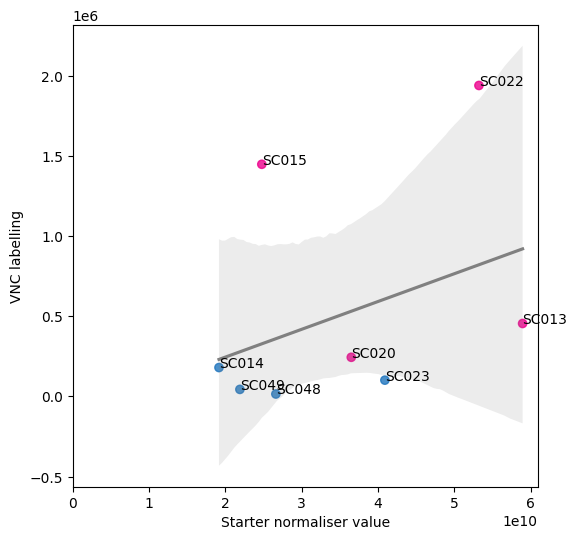

In [97]:
#areas = ['IO', 'CBN', 'P', 'VNC']
#for area in areas:
region_comparison_scatter(True, 'areaStarterNorm', areas=['IO'])

C:\Users\Sam\miniconda3\envs\bt\lib\site-packages\statsmodels\robust\robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
C:\Users\Sam\miniconda3\envs\bt\lib\site-packages\statsmodels\robust\robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
C:\Users\Sam\miniconda3\envs\bt\lib\site-packages\statsmodels\robust\robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
C:\Users\Sam\miniconda3\envs\bt\lib\site-packages\statsmodels\robust\robust_linear_model.py:288: ConvergenceWarning: Estimated 

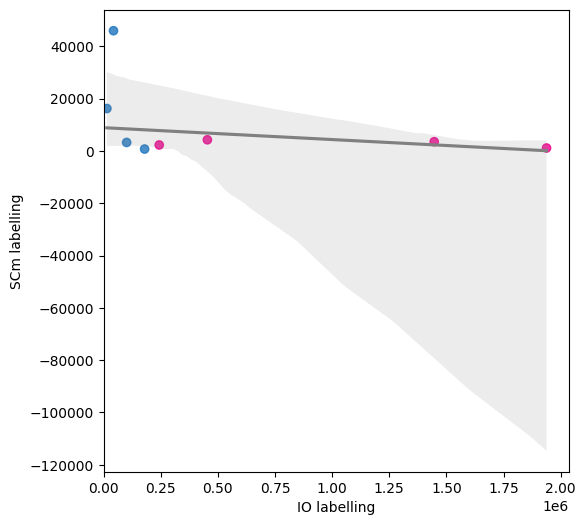

In [87]:
region_comparison_scatter(True, areas=['IO', 'SCm'])

## Cell Positions

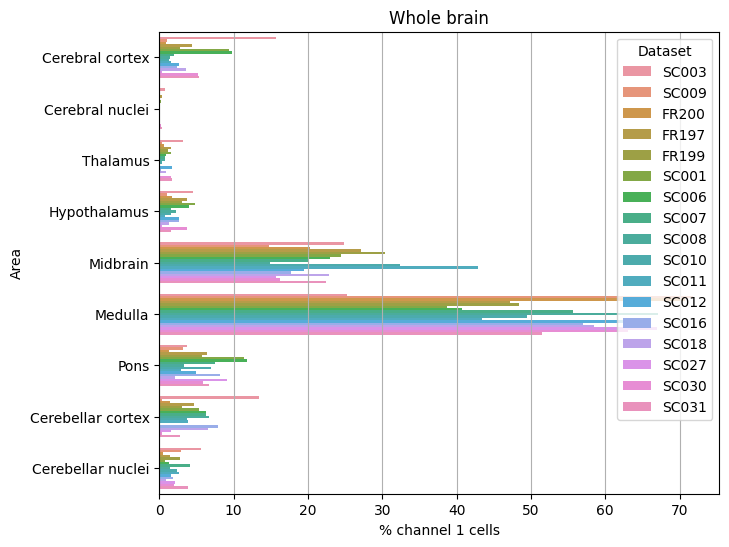

In [5]:
btp.generate_summary_plot()

In [5]:
# AREA SELECTIONS TO CHOOSE FROM
sfn_areas = ['MDRN','SCm','MRN','GRN','MARN','PRNr','VTA','PAG','P']
reward = ['ORB','VTA','STRv','SNc','ACB','CS','ACA','BLA','CEA','LHA']
motor = ['MO','MOp','MOs','STRd','VAL','VENT','GPi','SNr','SCm','MY-mot','MBmot','P-mot','DORsm','ILA','PL']
sensory = ['SS','SSp','SSp-ll','SSp-ul','SSs','MY-sen','MBsen','P-sen','PSV','SCs','DORsm']
other = ['FN','IP','DN','RAmb','RM','RO','RPA','RPO','CS','LC','STN','PAG','SPFm','POL','VM','LAT','ZI']
plot1 = ['SS','MO','PAG']
motor2 = ['MOs','PAG','MRN','GRN','SCm']
basal_ganglia = ['GPi','SNr','ACB','SNc','VTA','STRv']
uchida = ['VNC','IO','GRN','MRN','DCN','STRv']
cb_interesting1 = oof = ['SPF','LHA','PAS','ND','SUV']
cb_interesting2 = ['MOB','PAS','PARN','nst','NOT','mfsbshy','AUDv1']
cb_lobules = ['SIM','AN']
cb_regions = ['FN','IP','DN','cbc','MARN','GRN','PARN','SPIV']
heatmap_6100_differences = ['MV','SCm','PAG','MRN','VNC','MDRN','RN']
heatmap_6100_sagittal = ['MOs','MEZ','GRN','MV','TRN','PG','PAL','TH','RSP','ACA','ILA','PL','STR','SCm','SCs','IC','RN','PAG','MRN','VNC','GRN','MDRN']
heatmap_11400_frontal = ['FN','IP','DN','cbc','MARN','GRN','PARN','SPIV']
heatmap_5500_frontal = ['MOp','MOs','SSp','SSp-ll','SSp-ul','SSs','CP','PVZ','PVR','MEZ','LZ','PIR','PAL'] # ,'MO','SS'
ctx_differences = ['MOp','MOs','SSp','CP']

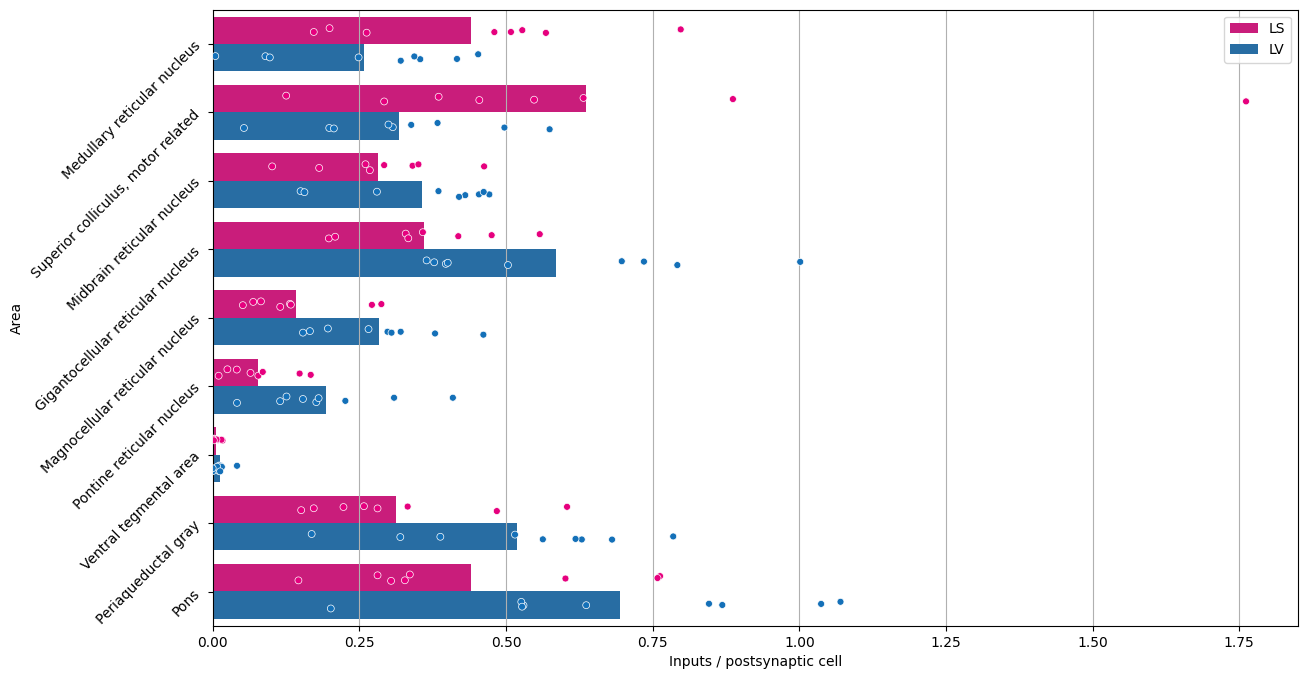

In [49]:
bt.grouped = True # False plots datasets individually, True plots as injection site groups
f, ax = plt.subplots(figsize=(14,8))
btp.generate_custom_plot(sig_areas, title='', normalisation='postsynaptics', ax=ax)
plt.yticks(rotation=45)
#btf.save(f'posterDimFrench_significant_{title}', as_type='pdf')
# PLOT HISTOGRAM OF ALL DATASETS ACROSS AREAS
# provide areas, title, normalisation ['postsynaptics':per starter, 'ch1':% all, None:#cells]

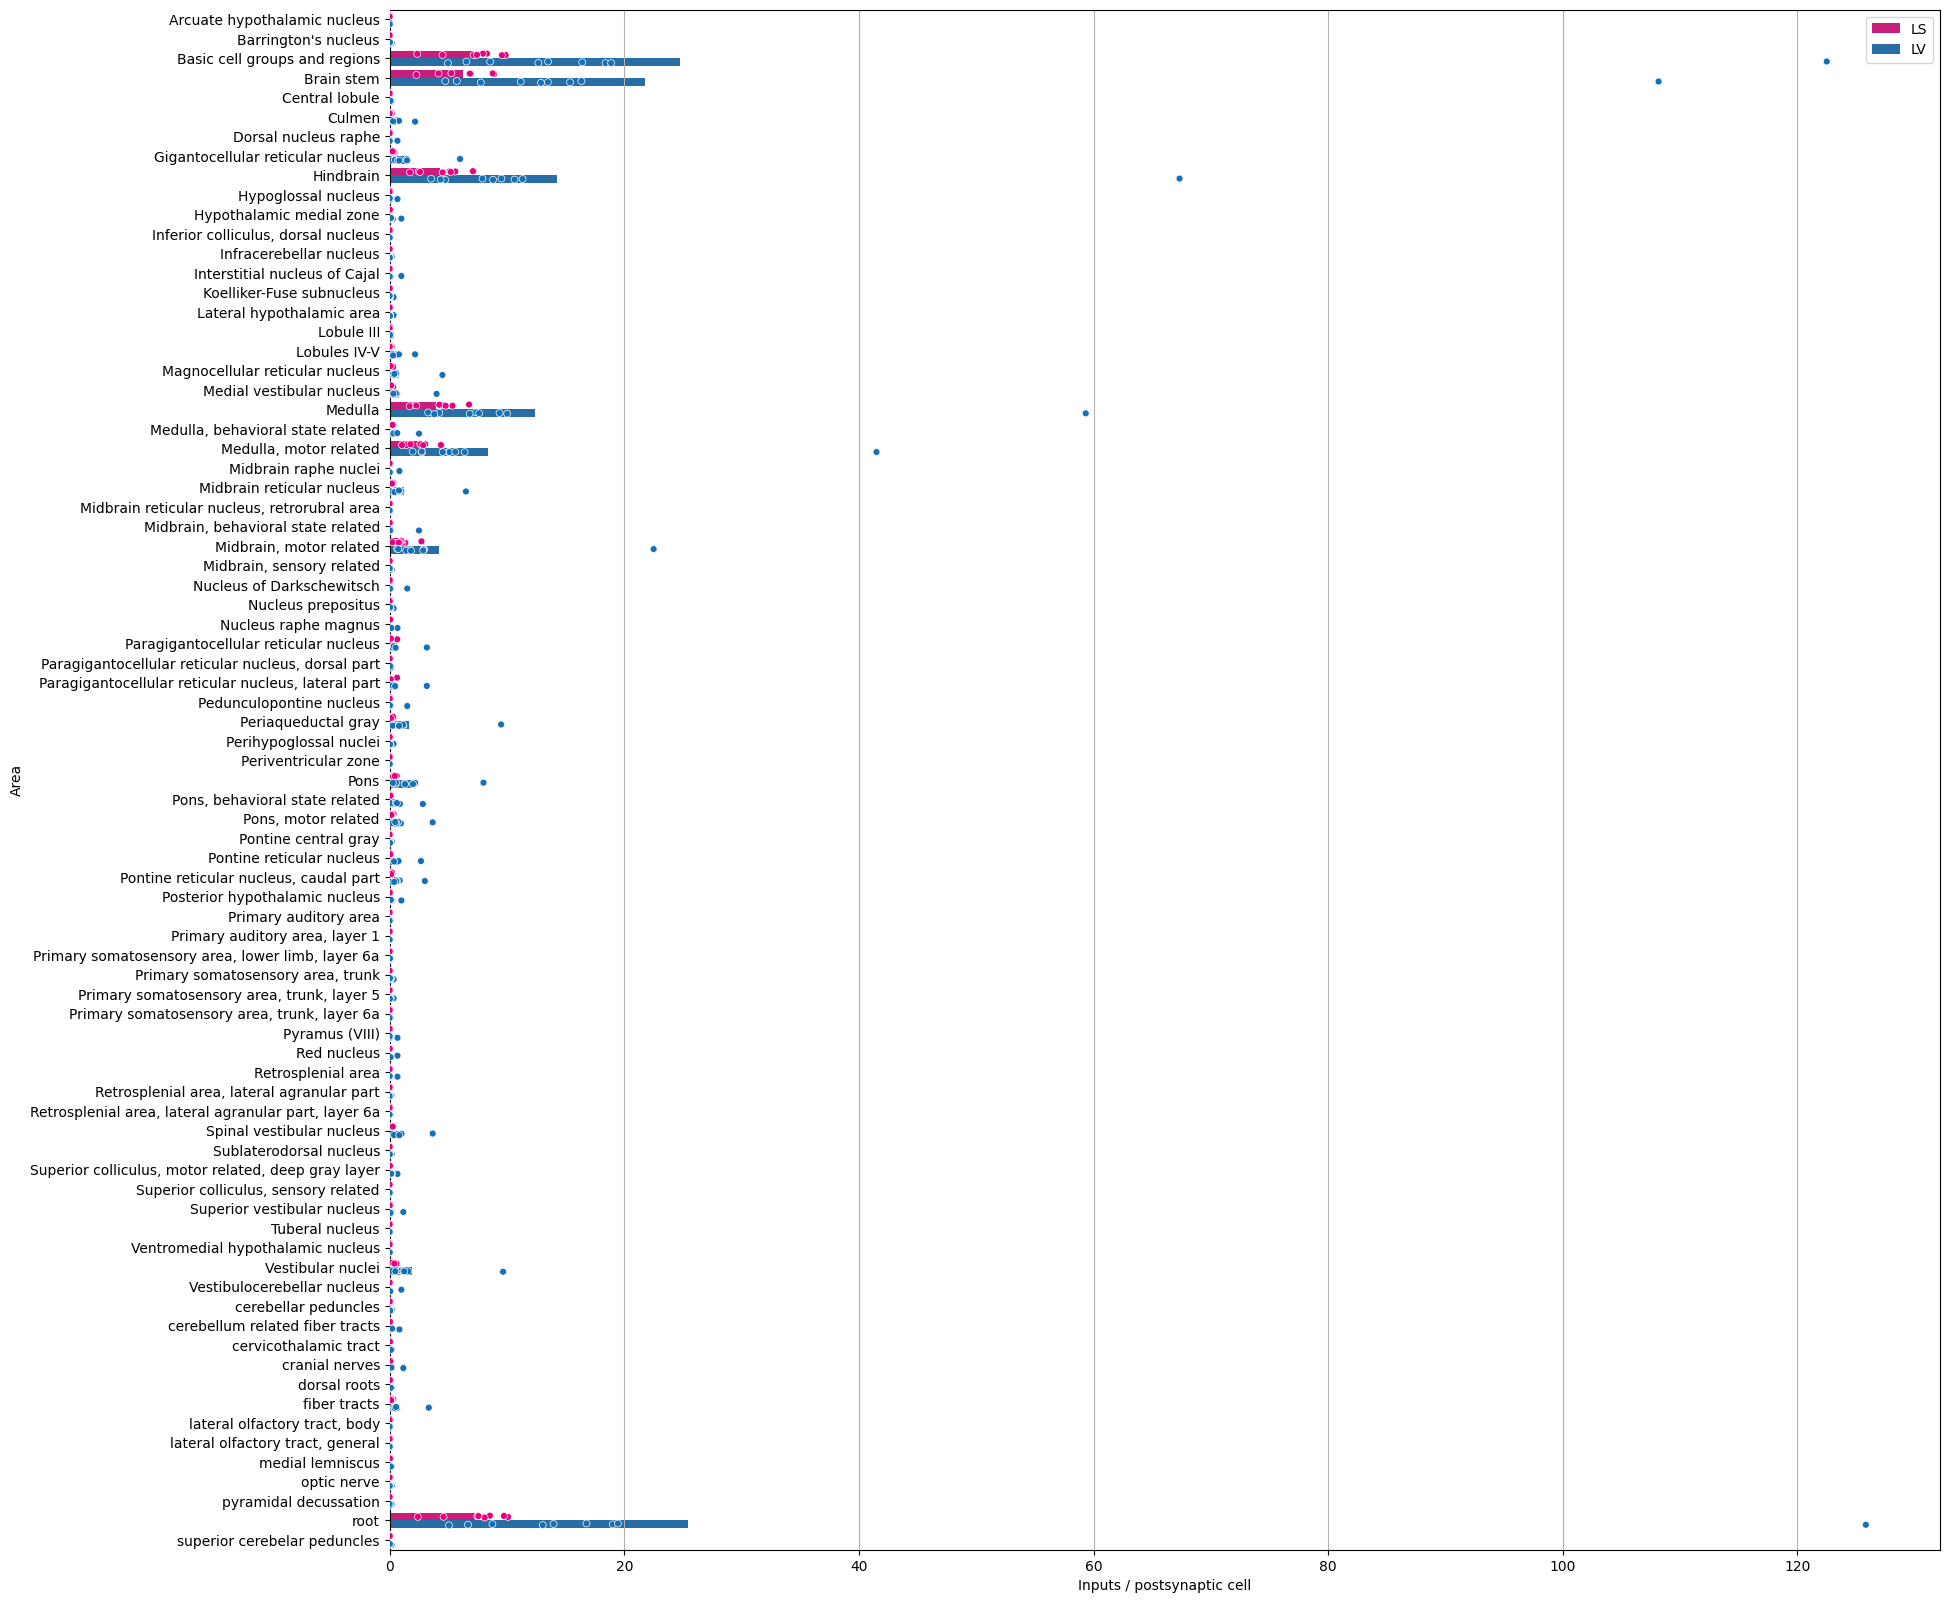

In [16]:
sig_list = [i for i in bt.area_indexes['acronym'] if bt.mwu(i)[1] < 0.05]
f, ax1 = plt.subplots(figsize=(20,20))
f.set_facecolor('white')
btp.generate_custom_plot(sig_list, title='', normalisation='postsynaptics', ax=ax1)
#btf.save(f'significant_{title}', as_type='png')
# show significantly different areas for an overview

In [ ]:
btp.custom_plot('r', areas, normalisation='presynaptics', title='histogram', log=False)

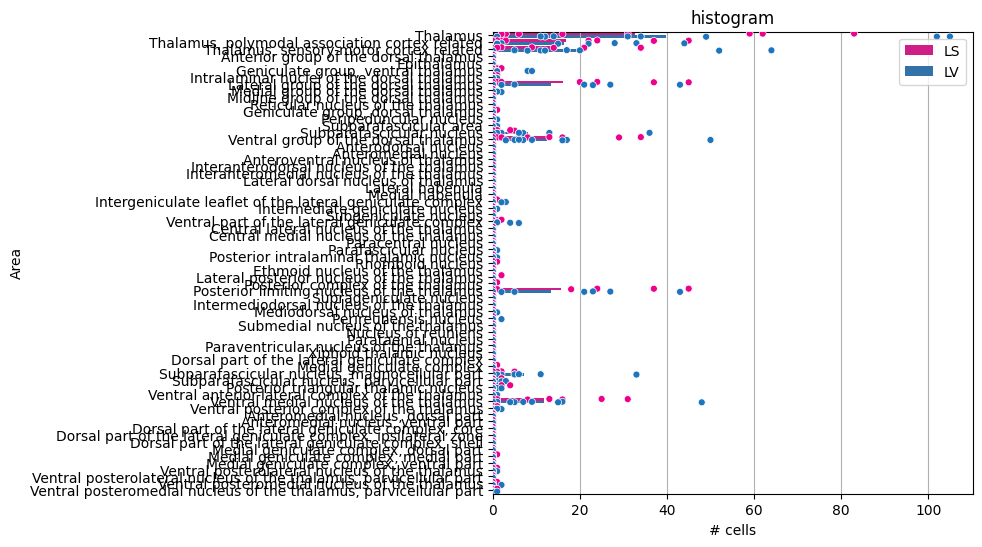

In [13]:
parent, children = bt.children_from(549, depth=0)
areas = [parent] + children
btp.custom_plot('r', areas, normalisation=None, title='histogram', log=False)

(17, 3)
(3,)
[]


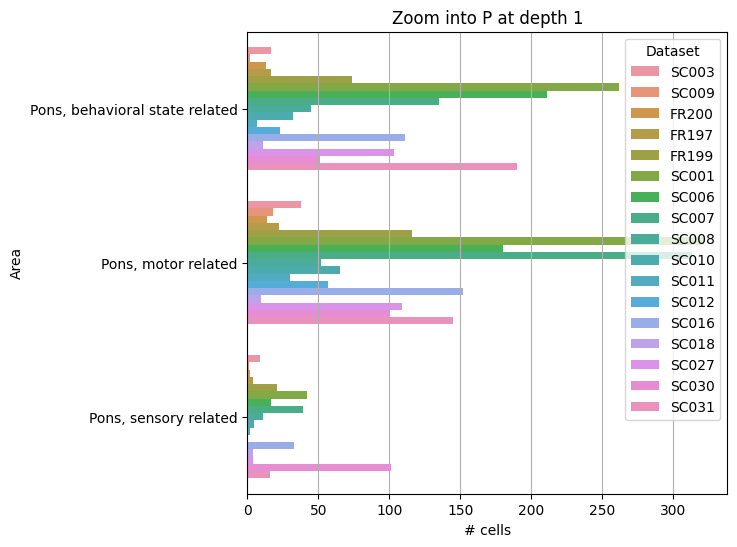

In [9]:
btp.zoom_plot('r', 'P', depth=1, threshold=0.5)
# zoom plots show areas within a parent region at given depth(s)
# depth=0 for all children, depth=1/2/3 for specified slice through inheritance tree

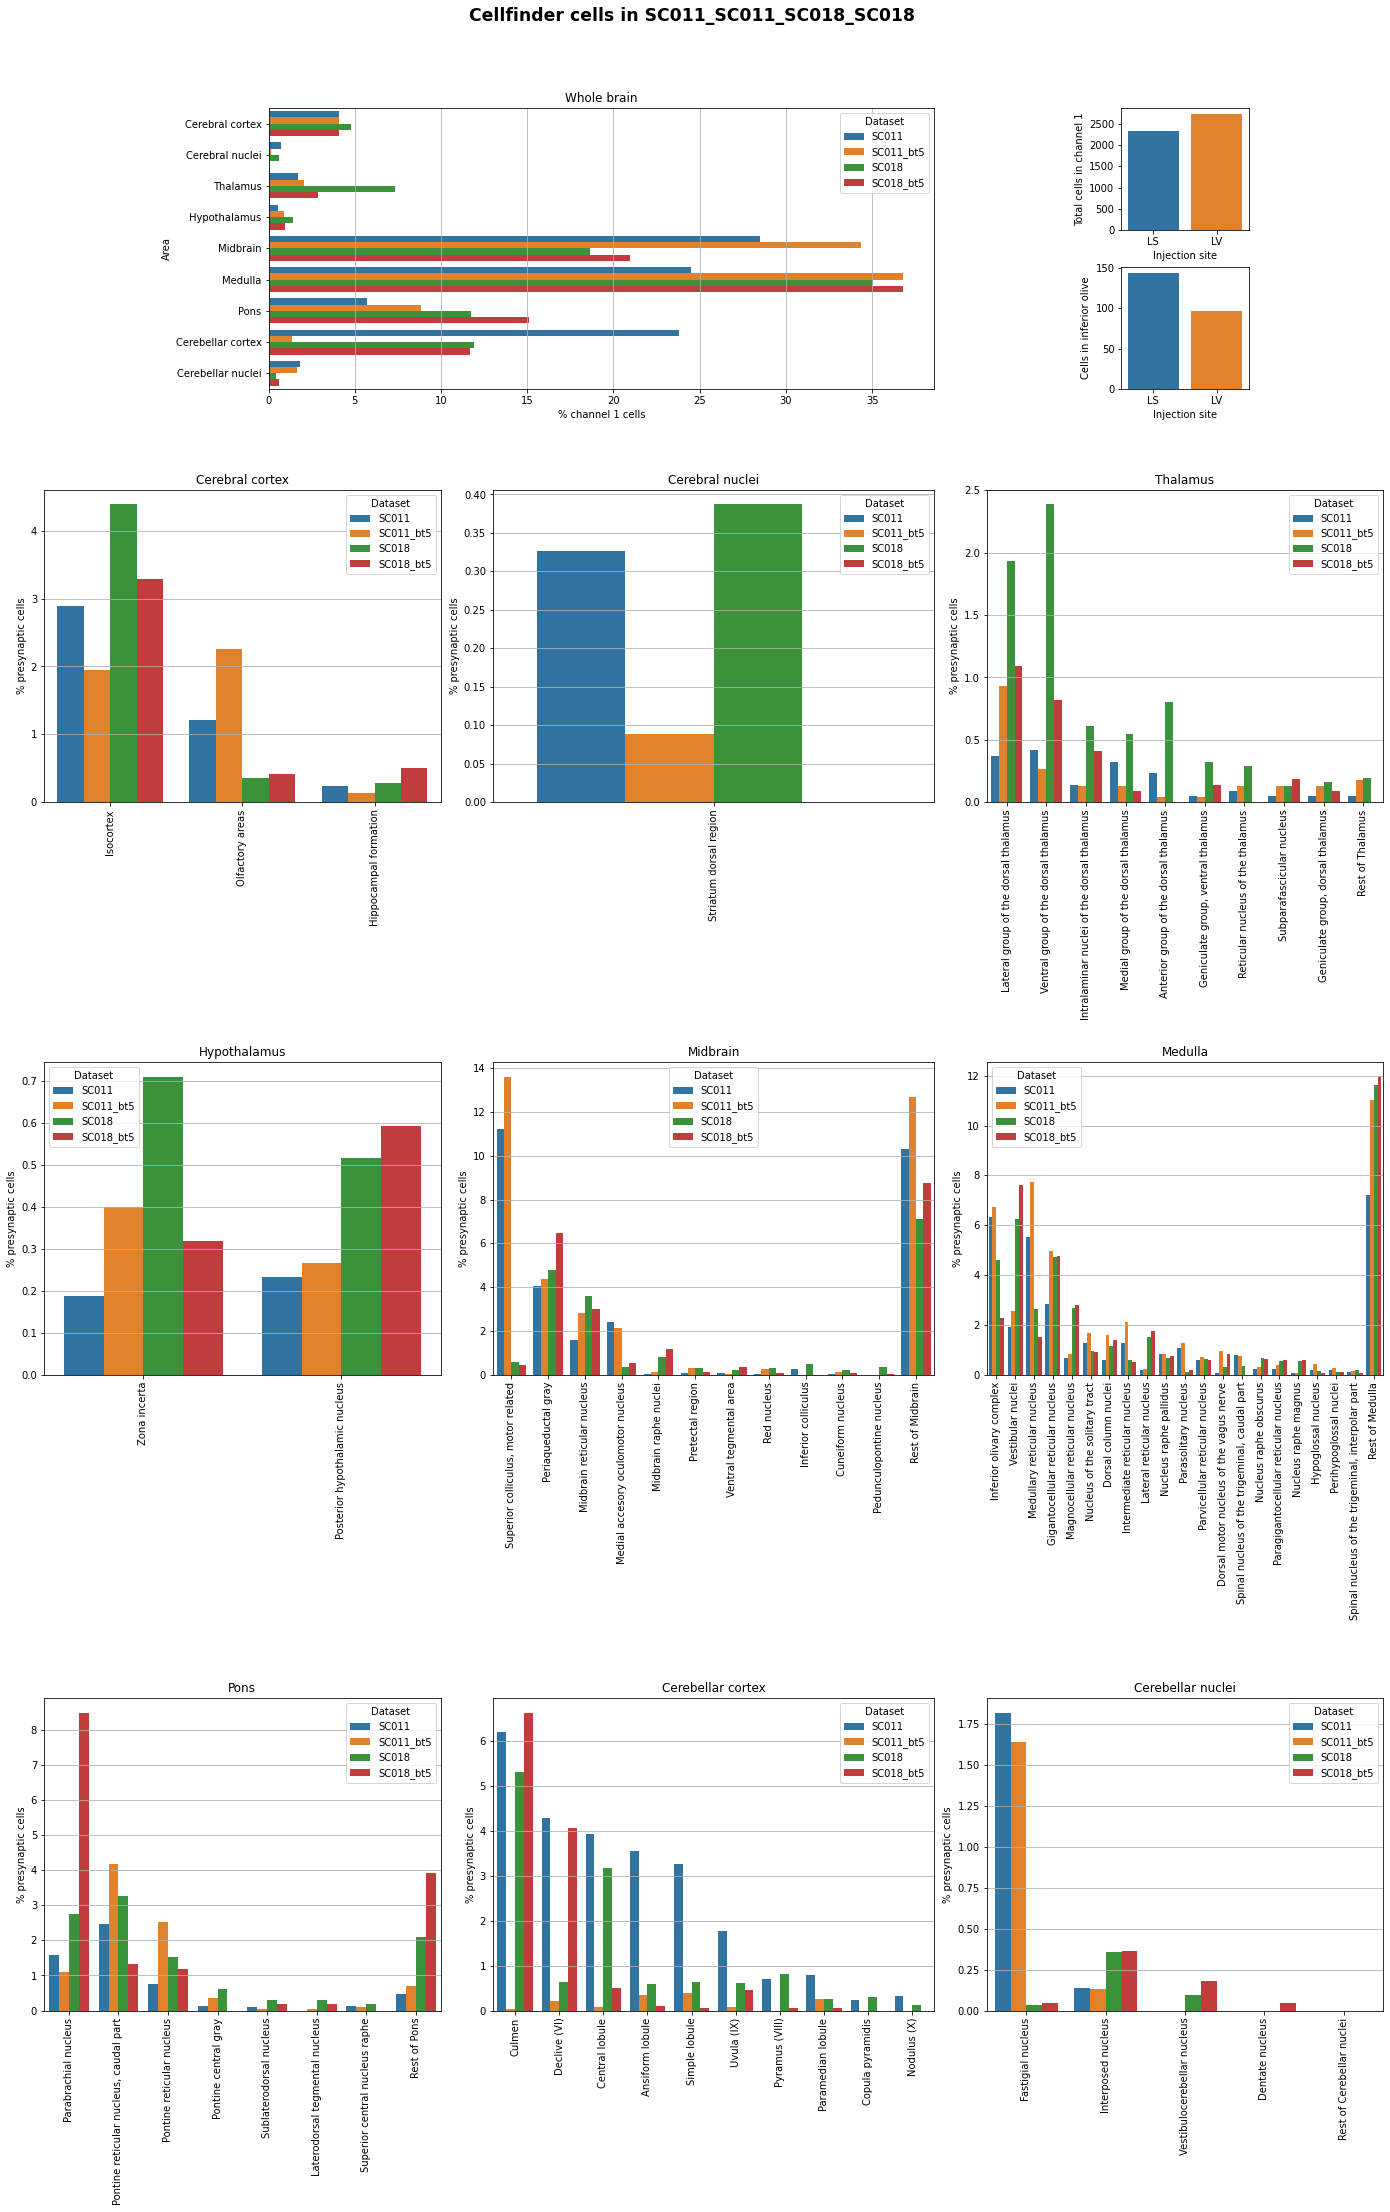

In [7]:
btp.generate_mega_overview_figure(f'Cellfinder cells in {title}')
#btf.save(f'areas_overview_{title}', as_type='png')

## Heatmaps

In [1]:
btp.generate_heatmap('r', bt.datasets[3], position=6500, vmax=None, normalisation='total', legend=False)
#btf.save('FR200_overview_heatmap', as_type='png')
# show heatmap for one dataset

NameError: name 'btp' is not defined

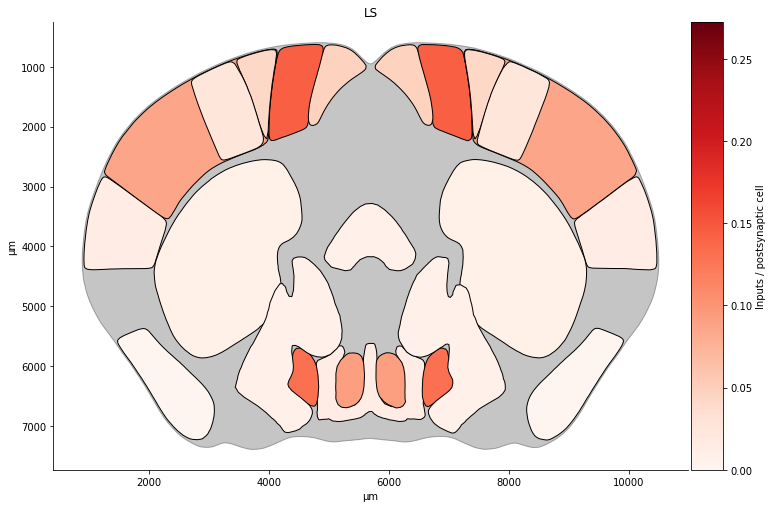

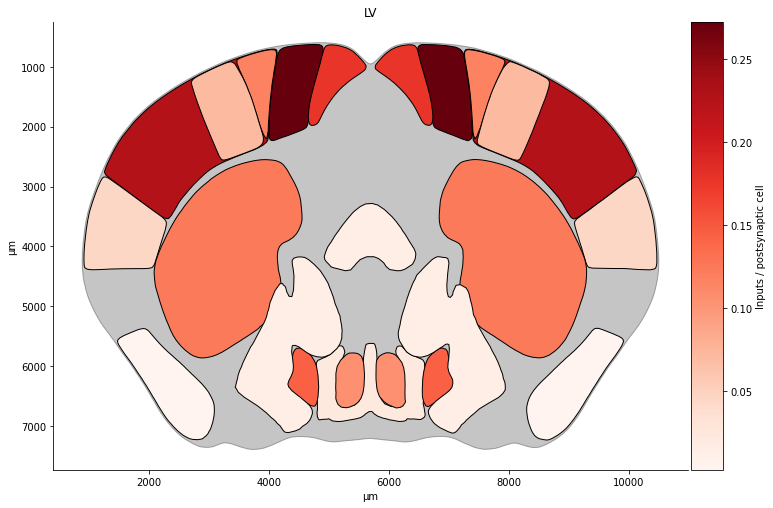

In [7]:
btp.generate_heatmap_comparison(ctx, orientation='frontal', position=5500, normalisation='postsynaptics', legend=False)
#btf.save(f'ctx_comparison_{title}', as_type='jpg')
# show heatmap of means by group

['LRNm', 'LRNp', 'MDRNd', 'MDRNv', 'AMBd', 'AMBv', 'PGRNd', 'PGRNl', 'NR', 'PRP', 'LAV', 'MV', 'SPIV', 'SUV', 'DCO', 'VCO', 'CU', 'GR', 'KF', 'SOCl', 'SOCm', 'POR', 'FF', 'LM', 'MM', 'SUM', 'TM', 'AD', 'AM', 'AV', 'IAD', 'IAM', 'LD', 'LH', 'MH', 'IGL', 'IntG', 'SubG', 'LGv', 'CL', 'CM', 'PCN', 'PF', 'PIL', 'RH', 'Eth', 'LP', 'PO', 'POL', 'SGN', 'IMD', 'MD', 'PR', 'SMT', 'RE', 'PT', 'PVT', 'Xi', 'LGd', 'MG', 'SPFm', 'SPFp', 'PoT', 'VAL', 'VM', 'VP', 'IPA', 'IPC', 'IPDL', 'IPDM', 'IPI', 'IPL', 'IPR', 'IPRL', 'CA', 'DG', 'FC', 'IG', 'APr', 'ENT', 'HATA', 'PAR', 'POST', 'PRE', 'ProS', 'SUB', 'AId', 'AIp', 'AIv', 'ACAd', 'ACAv', 'AUDd', 'AUDpo', 'AUDp', 'AUDv', 'ECT1', 'ECT2/3', 'ECT5', 'ECT6a', 'ECT6b', 'FRP1', 'FRP2/3', 'FRP5', 'FRP6a', 'FRP6b', 'GU1', 'GU2/3', 'GU4', 'GU5', 'GU6a', 'GU6b', 'ILA1', 'ILA2/3', 'ILA5', 'ILA6a', 'ILA6b', 'ORBl', 'ORBm', 'ORBvl', 'PERI1', 'PERI2/3', 'PERI5', 'PERI6a', 'PERI6b', 'VISa', 'VISrl', 'PL1', 'PL2/3', 'PL5', 'PL6a', 'PL6b', 'RSPd', 'RSPagl', 'RSPv', '

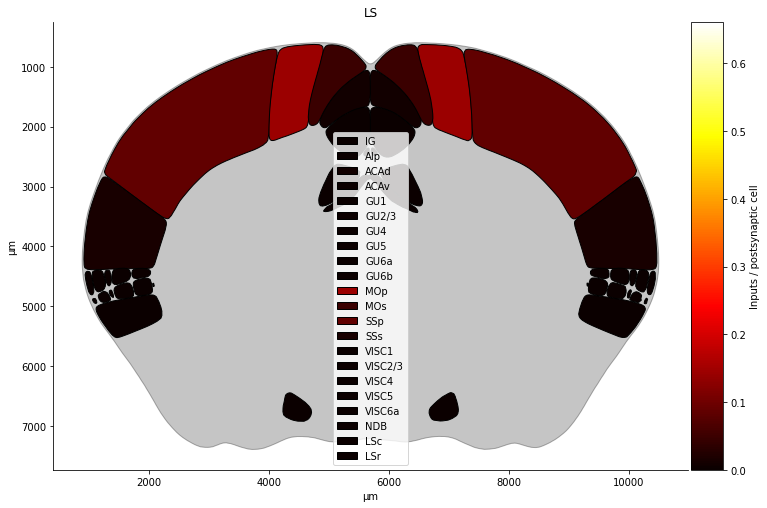

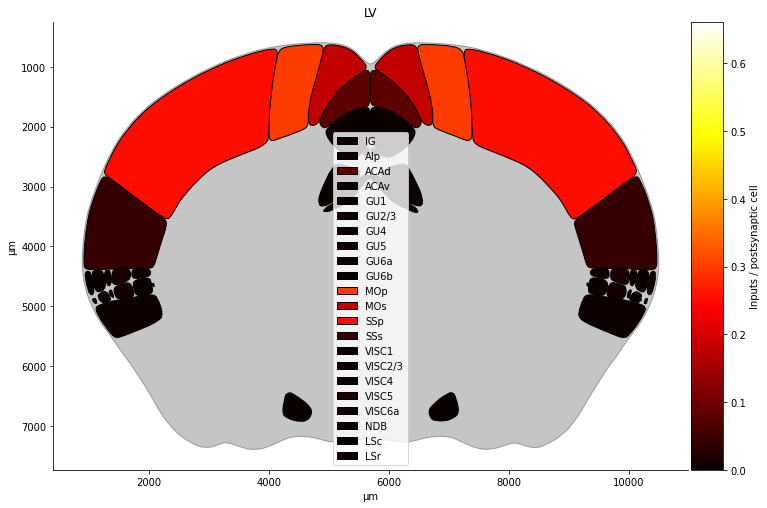

In [15]:
btp.generate_slice_heatmap(position=5500, normalisation='postsynaptics', depth=7)
# show heatmap of areas by depth in inheritance tree (frequently crashes)

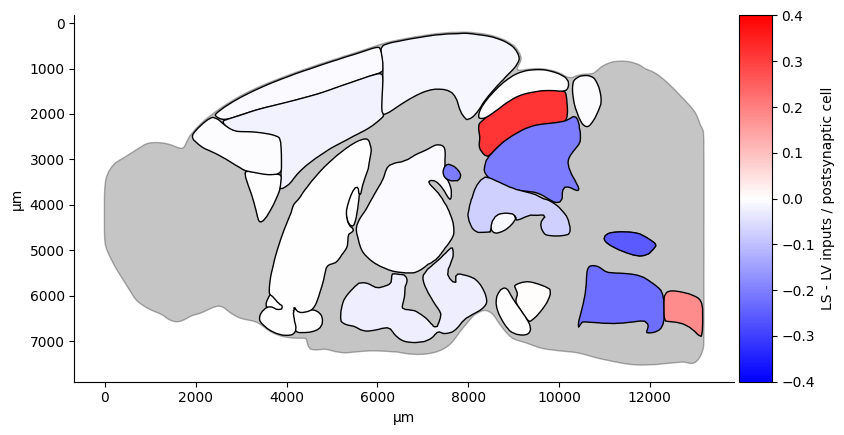

In [31]:
btp.generate_heatmap_difference(areas_6100, orientation='sagittal', position=6100, normalisation='postsynaptics', legend=False, limit=0.4)
#btf.save('heatmap_differences_absolute', as_type='png')
# show difference heatmap across groups

In [5]:
# convert area codes to acronyms
codes = [313, 688, 354, 771, 1097, 549, 323, 379, 370, 386, 1117, 987, 290, 128, 795, 294, 230, 1048, 136, 235, 307, 395, 938, 852, 701, 720, 651, 437, 146, 1093, 797, 10, 17, 500, 453, 955, 1098, 1107, 978, 202, 225, 711, 985]
names = bt.area_indexes.loc[codes]['acronym'].tolist()

[]


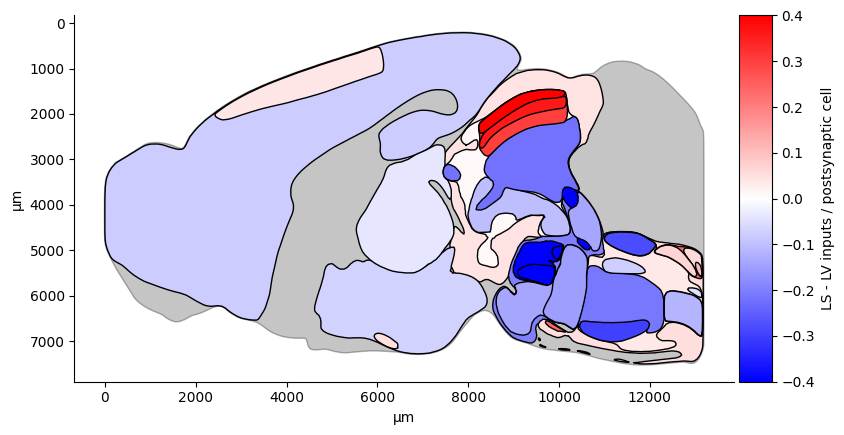

In [27]:
btp.generate_heatmap_ratios(names, orientation='sagittal', position=6100, normalisation='postsynaptics', legend=False, limit=0.4, add=False)
# show ratio difference heatmap across groups

## Statistics

In [33]:
bt.mwu('r', 'PAG', norm='postsynaptics')

MannwhitneyuResult(statistic=14.0, pvalue=0.03595228301110654)

In [109]:
bt.mwu('r', True, 'IO', norm='custom_pedestal')

MannwhitneyuResult(statistic=16.0, pvalue=0.02857142857142857)

In [5]:
areas = [1129, 313, 688, 354, 771, 1097, 549, 323, 379, 370, 386, 1117, 987, 290, 128, 795, 294, 230, 1048, 136, 235, 307, 395, 938, 852, 701, 720, 651, 437, 146, 1093, 797, 10, 17, 500, 453, 955, 1098, 1107, 978, 202, 225, 711, 985]

In [9]:
areas = bt.area_indexes.loc[areas, 'acronym'].tolist()

In [28]:
#areas = ['VTA','SCm','TH']
bt.anova('r', True, areas, parametric=True, norm='custom_division')

                          Area Dataset     Cells
0            Vestibular nuclei      LS  0.173870
1                 Pontine gray      LS  2.501045
2  Tegmental reticular nucleus      LS  1.350492
3    Lateral reticular nucleus      LS  0.270254
4      Infracerebellar nucleus      LS  0.113747
                          Area Dataset  Cells
0            Vestibular nuclei      LS  181.0
1                 Pontine gray      LS  227.0
2  Tegmental reticular nucleus      LS  221.0
3    Lateral reticular nucleus      LS  199.0
4      Infracerebellar nucleus      LS  173.0


sum_sq 
 df 
 F 
 PR(>F) 
 
 
 
 
 C(Area) 
 731612.750000 
 28.0 
 23.633579 
 1.814011e-45 
 
 
 C(Dataset) 
 7716.568966 
 1.0 
 6.979599 
 8.995717e-03 
 
 
 C(Area):C(Dataset) 
 108876.181034 
 28.0 
 3.517071 
 1.936350e-07 
 
 
 Residual 
 192372.500000 
 174.0 
 NaN 
 NaN